In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from tqdm import tqdm, trange, tqdm_notebook

from matplotlib.pylab import get_cmap
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import sys, os
import cPickle as pickle
from glob import glob

fs=20
fs_ticks = 16
sys.path.append('/Users/mhuber/PointSource/skylab/')
from SkyMap import SkyMap

from scipy.stats import norm

# define sfb colors
colors = ['#3850A1', '#F79645', '#993A91']
#new trial
colors = ['#0D589A', '#5DB5D0', '#A9DBB7','blue']

from matplotlib.ticker import (AutoMinorLocator, FixedLocator, FuncFormatter,
                               MultipleLocator, NullLocator, LogLocator)
import healpy as hp

from scipy.interpolate import UnivariateSpline
from matplotlib.lines import Line2D


from scipy.interpolate import splrep, splev
from copy import deepcopy 

In [2]:
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from PyAstronomy import pyasl

In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [4]:
sys.path.append('../')
from core.tools import *
from core.tools import _trans

# define binning on skymap

In [5]:
NSIDE = 2**6
npix = hp.nside2npix(NSIDE)

ngrid=500


# this gives the pixel size in sterradian (also called square radian)
psize = hp.nside2pixarea(NSIDE)
print(npix*psize, 4*np.pi)

(12.566370614359172, 12.566370614359172)


# use mceq for the background flux estimation

In [6]:
import mceq_config as config
from MCEq.core import MCEqRun
import crflux.models as pm

In [7]:
config.e_min = 1#86e-3
config.e_max = 1e9#1e11
config.debug_level = 2
config.enable_em = False
config.mkl_threads = 32
config.hybrid_crossover = 0.5

In [8]:
base_model = 'SIBYLL23C'
mceq = MCEqRun(
    interaction_model=base_model,
    theta_deg=0.,
    primary_model=(pm.GlobalSplineFitBeta,
             '/Users/mhuber/AtmosphericShowers/Data/GSF_spline_20171007.pkl.bz2'))

HDF5Backend::__init__(): Opening HDF5 file mceq_db_lext_dpm191_v12.h5
MCEqRun::set_interaction_model(): SIBYLL23C
HDF5Backend::decay_db(): Using helicity dependent decays.
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
Hadrons and stable particles:
"pbar-", "p+"

Mixed:
"K_L0", "pi-", "pi+", "K_S0", "K-", 
"K+", "D-", "D+", "Dbar0", "D0", 
"D_s-", "D_s+", "nbar0", "n0", "Lambdabar0", 
"Lambda0"

Resonances:
"pi0"

Leptons:
"e+", "e-", "antinue", "nue", "mu+_l", 
"mu+", "mu+_r", "mu-_l", "mu-", "mu-_r", 
"antinumu", "numu", "antinutau", "nutau", "gamma"

Tracking:
"pi_antinue", "pi_nue", "pi_mu+_l", "pi_mu+_r", "pi_mu-_l", 
"pi_mu-_r", "pi_antinumu", "pi_numu", "k_antinue", "k_nue", 
"k_mu+_l", "k_mu+_r", "k_mu-_l", "k_mu-_r", "k_antinumu", 
"k_numu", "mulr_antinue", "mulr_nue", "mulr_antinumu", "mulr_numu", 
"mu_h0_antinue", "mu_h0_nue", "mu_h0_antinumu", "mu_h0_numu", "mu_antinue", 
"mu_nue", "mu_antinumu", "mu_numu", "K0_antinue", "K0_

In [9]:
mag = 0


#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(0.5,0,3))*180./np.pi

flux_def = dict()
#Initialize empty grid
for frac in ['numu_conv','numu_pr','numu_total',
             'mu_conv','mu_pr','mu_total',
             'nue_conv','nue_pr','nue_total','nutau_pr']:
    flux_def[frac] = np.zeros_like(mceq.e_grid)

    
#Sum fluxes, calculated for different angles
for theta in angles:
    mceq.set_theta_deg(theta)
    mceq.solve()
    
    # same meaning of prefixes for muon neutrinos as for muons
    flux_def['mu_conv'] += (mceq.get_solution('conv_mu+', mag)
                         + mceq.get_solution('conv_mu-', mag))

    flux_def['mu_pr'] += (mceq.get_solution('pr_mu+', mag)
                       + mceq.get_solution('pr_mu-', mag))

    flux_def['mu_total'] += (mceq.get_solution('total_mu+', mag)
                          + mceq.get_solution('total_mu-', mag))
    
    
    # same meaning of prefixes for muon neutrinos as for muons
    flux_def['numu_conv'] += (mceq.get_solution('conv_numu', mag)
                         + mceq.get_solution('conv_antinumu', mag))

    flux_def['numu_pr'] += (mceq.get_solution('pr_numu', mag)
                       + mceq.get_solution('pr_antinumu', mag))

    flux_def['numu_total'] += (mceq.get_solution('total_numu', mag)
                          + mceq.get_solution('total_antinumu', mag))

    # same meaning of prefixes for electron neutrinos as for muons
    flux_def['nue_conv'] += (mceq.get_solution('conv_nue', mag)
                        + mceq.get_solution('conv_antinue', mag))

    flux_def['nue_pr'] += (mceq.get_solution('pr_nue', mag)
                      + mceq.get_solution('pr_antinue', mag))

    flux_def['nue_total'] += (mceq.get_solution('total_nue', mag)
                         + mceq.get_solution('total_antinue', mag))


    # since there are no conventional tau neutrinos, prompt=total
    flux_def['nutau_pr'] += (mceq.get_solution('total_nutau', mag)
                        + mceq.get_solution('total_antinutau', mag))

#average the results
for frac in [
             'numu_conv','numu_pr','numu_total',
            'mu_conv','mu_pr','mu_total',
             'nue_conv','nue_pr','nue_total','nutau_pr']:
    flux_def[frac] = flux_def[frac]/float(len(angles))



MCEqRun::set_theta_deg(): Zenith angle  60.00
MCEqRun::solve(): Launching euler solver
MCEqRun::_calculate_integration_path(): X_surface = 2060.60g/cm2
MCEqRun::solve(): for 875 integration steps.
solv_numpy(): Performance:   3.53ms/iteration
MCEqRun::solve(): time elapsed during integration:  3.12sec
MCEqRun::set_theta_deg(): Zenith angle  75.52
MCEqRun::solve(): Launching euler solver
MCEqRun::_calculate_integration_path(): X_surface = 4067.55g/cm2
MCEqRun::solve(): for 1614 integration steps.
solv_numpy(): Performance:   3.61ms/iteration
MCEqRun::solve(): time elapsed during integration:  5.84sec
MCEqRun::set_theta_deg(): Zenith angle  90.00
MCEqRun::solve(): Launching euler solver
MCEqRun::_calculate_integration_path(): X_surface = 36583.25g/cm2
MCEqRun::solve(): for 6310 integration steps.
solv_numpy(): Performance:   4.90ms/iteration
MCEqRun::solve(): time elapsed during integration: 30.92sec


# Show the background spectrum

<IPython.core.display.Javascript object>


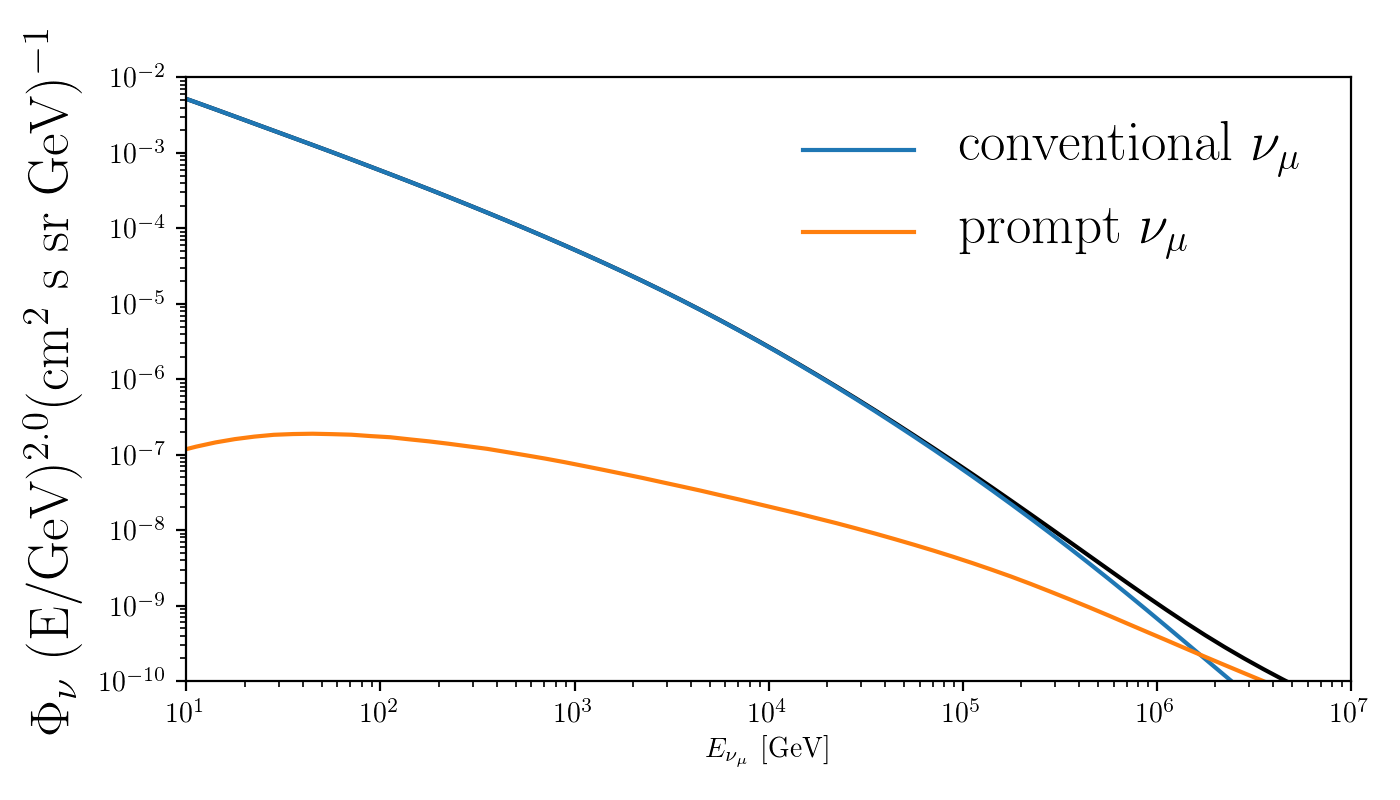

In [10]:
fig, ax = plt.subplots( figsize=(7,4))
e_grid = mceq.e_grid

spec = 2.
for i,(pref, lab) in enumerate([('numu_',r'\nu_\mu')]):
    
    p0 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'total'], color='k', ls='solid', lw=1.5)
    p1 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'conv'],  ls='solid', lw=1.5,
               label=r'conventional ${0}$'.format(lab))
    p2 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'pr'], ls='solid', lw=1.5, 
               label='prompt ${0}$'.format(lab))
    
    
    
    ax.set_xlim(10,1e7)
    
    ax.set_ylim(1e-10,1e-2)
    #ax.set_ylim(0.8,1.2)
    ax.set_xlabel(r"$E_{{{0}}}$ [GeV]".format(lab))
    
    ax.legend(loc='upper right',frameon=False,numpoints=1,fontsize=fs)

ax.set_ylabel(r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) +" }$" + 
           "(cm$^{2}$ s sr GeV)$^{-1}$", fontsize=fs)
    
    

fig.tight_layout()

# Now use the effective areas that i created for plenum to get signal and background event number descriptions

In [11]:
path = 'resources/'
results = np.load(os.path.join(path, 'effective_areas_av_per_day_fine_binning.npy'))

etrue_bins = np.arange(2,8.1,0.1) # np.linspace(2.,9.,num=25)
etrue_mids = 10**get_mids(etrue_bins)
etrue_bins = 10**etrue_bins

sd_bins = np.linspace(-1.,1.,35)
n_sd, n_e = len(sd_bins)-1, len(etrue_bins)-1

etrue_bin_width = np.diff(etrue_bins)

<IPython.core.display.Javascript object>


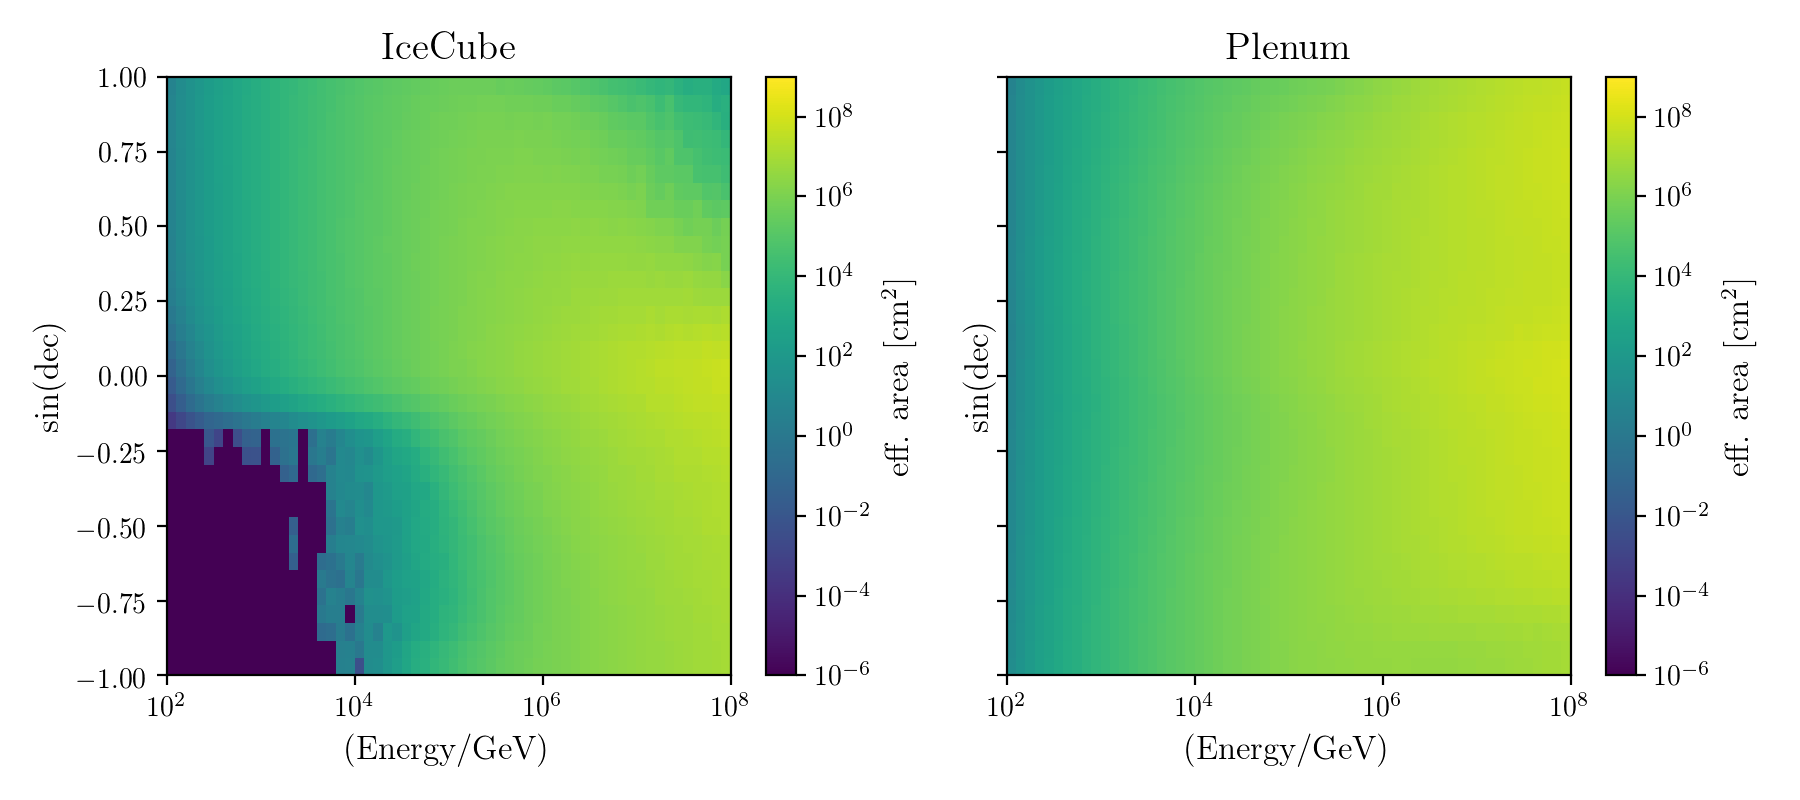

In [12]:
# get the mceq flux values within the respective energy bins
ind_mceq = [np.argmin(np.abs(mceq.e_grid-ei)) for ei in etrue_mids]


fig, axes=plt.subplots(ncols=2, figsize=(9,4), sharey=True)

ax = axes[0]
ax.set_title('IceCube', fontsize=14)
p = ax.pcolormesh(etrue_bins, sd_bins, #Res_effA*1e4
                  results['effA_icecube'].reshape((n_sd, n_e)) 
                  , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e9, vmin=1e-6)

ax.set_xlabel(r'(Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)

cb=fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]', fontsize=12)
ax.set_xscale('log')

ax = axes[1]
ax.set_title('Plenum', fontsize=14)
p = ax.pcolormesh(etrue_bins, sd_bins,
                  results['effA_plenum'].reshape((n_sd, n_e))  
                  , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e9, vmin=1e-6)

ax.set_xlabel(r'(Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)

cb=fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]', fontsize=12)


ax.set_xscale('log')
fig.tight_layout()

# Get also the public energy smearing function 

In [13]:
ereco_bins = np.arange(2,7.1,0.1) # np.linspace(2.,9.,num=25)
ereco_mids = 10**get_mids(ereco_bins)
ereco_bins = 10**ereco_bins

n_ereco = len(ereco_mids)

In [14]:
d_public_2021_smearing = np.genfromtxt('/Users/mhuber/Downloads/icecube_10year_ps/irfs/IC86_II_smearing.csv',
                        skip_header=1)

In [15]:
log_emin_smearing, log_emax_smearing = d_public_2021_smearing[:,0], d_public_2021_smearing[:,1]
log_emids_smearing = (log_emin_smearing+log_emax_smearing)/2.
sdec_min_smearing, sdec_mac_smearing = (np.sin(np.deg2rad(d_public_2021_smearing[:,2])), 
                      np.sin(np.deg2rad(d_public_2021_smearing[:,3])))

log_erec_min_smearing, log_erec_max_smearing = d_public_2021_smearing[:,4], d_public_2021_smearing[:,5]
log_erec_mids_smearing = (log_erec_min_smearing+log_erec_max_smearing)/2.

<IPython.core.display.Javascript object>


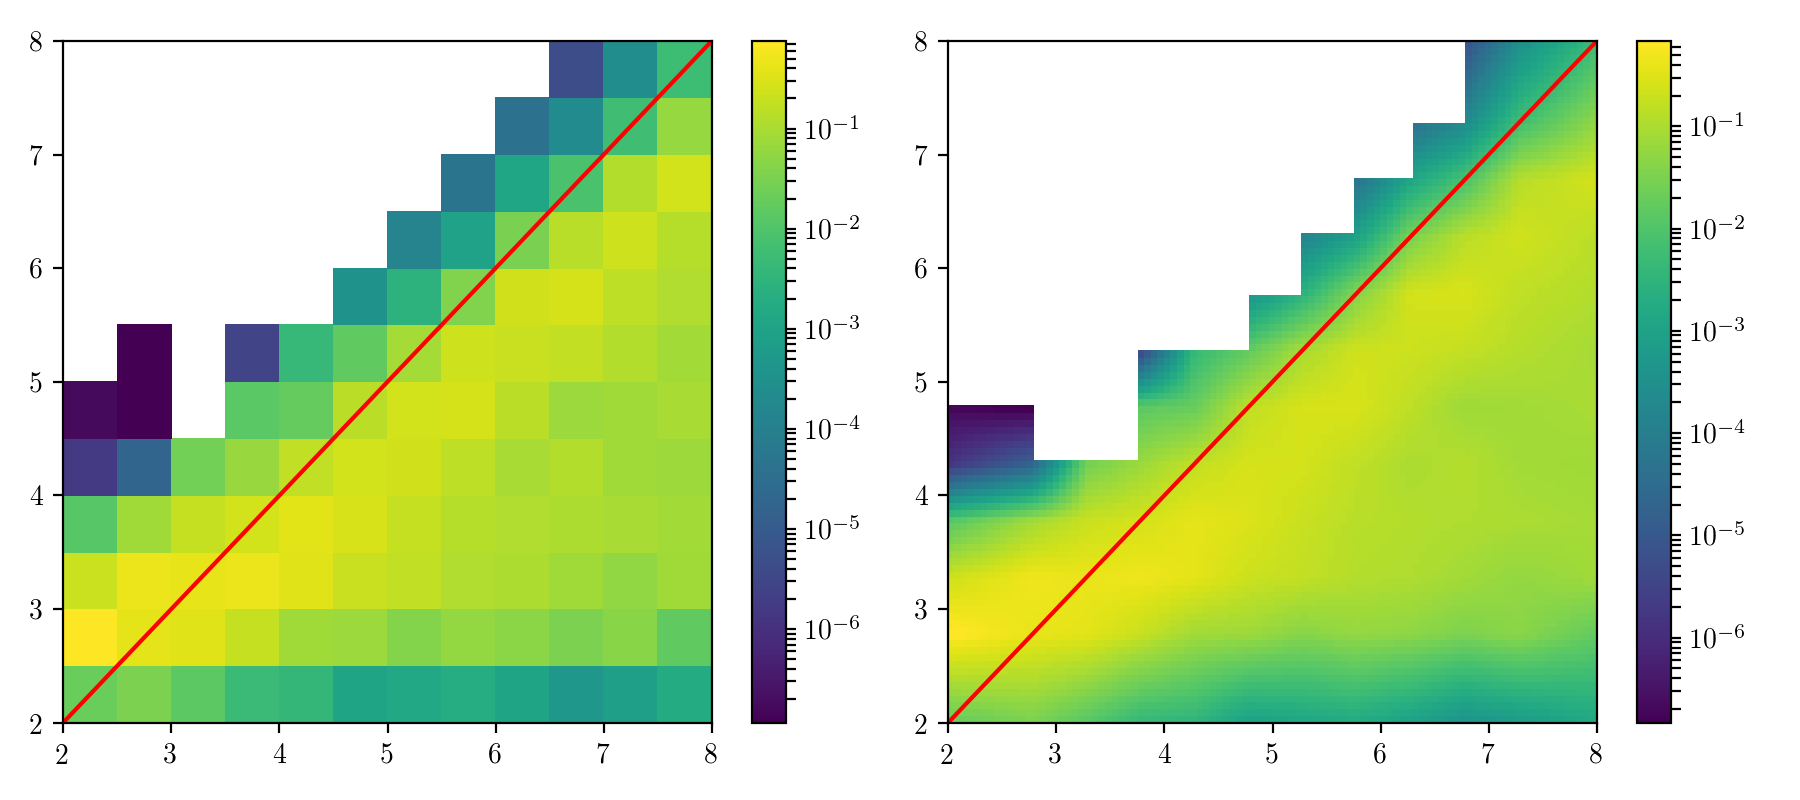

In [16]:
fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(9,4))
counts = d_public_2021_smearing[:,-1]



    
    
bins = (np.arange(2,8.1,0.5), np.arange(2,8.1,0.5))
h,_,_= np.histogram2d(log_emids_smearing,log_erec_mids_smearing, 
          bins=bins, weights=counts)

h = h / h.sum(axis=1)[:,np.newaxis]


binmids = tuple([get_mids(bi, ext=True) for bi in bins])
smearing_spline = sp.interpolate.RegularGridInterpolator(
                    binmids, np.log(h),
                    method="linear",
                    bounds_error=False,
                    fill_value=0.
                    )

ax = axes[0]
p=ax.pcolormesh(bins[0], bins[1], h.T, norm=LogNorm())
ax.plot([2,8], [2,8], color='red')
cb=fig.colorbar(p,ax=ax)

ax = axes[1]
grid_etrue = np.linspace(bins[0][0], bins[0][-1],100) 
grid_ereco = np.linspace(bins[1][0], bins[1][-1],100) 

xx,yy = np.meshgrid(grid_etrue, grid_ereco,indexing='ij')

p=ax.pcolormesh(grid_etrue, grid_ereco, np.exp(smearing_spline((xx, yy))).T, norm=LogNorm())
ax.plot([2,8], [2,8], color='red')
cb=fig.colorbar(p,ax=ax)

    
fig.tight_layout()

In [17]:
sys.path.append('/Users/mhuber/Python_Tools/')
from my_functions import weighted_median
idata = np.load('/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')
k_mc = 'muon_energy_entry'
mask = np.isnan(idata[k_mc])
idata = idata[~mask]


bins_reco = np.linspace(2, 8.1, 45)
mids_reco = 10**get_mids(bins_reco)
bins_reco = 10**bins_reco



fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(9,3.5), squeeze=True) 
ax = axes[1]

k_mc = 'trueE'
k_reco = 'energy'
bins_mc = np.linspace(2, 8.2, 50)
mids_mc = 10**get_mids(bins_mc)
bins_mc = 10**bins_mc


gamma=2.
w = np.ones_like(idata['ow'])# * idata['trueE']**(-gamma)# np.ones_like(idata[k_mc])
h,_,_ = np.histogram2d(idata[k_mc], idata[k_reco], bins = (bins_mc, bins_reco), weights=w)
# normalize along the mc axis to get P(E_reco| E_entry)
norm = h.sum(axis=1)
norm[norm==0] = 1.
h /= norm[:,np.newaxis]

binmids = tuple([get_mids(bi, ext=True) for bi in (np.log10(bins_mc), np.log10(bins_reco))])
smearing_spline = sp.interpolate.RegularGridInterpolator(
                    binmids, np.log(h),
                    method="linear",
                    bounds_error=False,
                    fill_value=0.
                    )

grid_etrue = np.linspace(bins[0][0], bins[0][-1],100) 
grid_ereco = np.linspace(bins[1][0], bins[1][-1],100) 

xx,yy = np.meshgrid(grid_etrue, grid_ereco,indexing='ij')
p=axes[0].pcolormesh(grid_etrue, grid_ereco, np.exp(smearing_spline((xx, yy))).T, norm=LogNorm())
fig.colorbar(p, ax=axes[0])


med_low,_  = weighted_median(bins_mc, idata[k_mc], idata[k_reco], w, (1-0.68)/2.)
med_up,_  = weighted_median(bins_mc, idata[k_mc], idata[k_reco], w, 1-(1-0.68)/2.)
med50,_ = weighted_median(bins_mc, idata[k_mc], idata[k_reco], w, 0.5)


p = ax.pcolormesh( bins_mc, bins_reco, h.T, norm=LogNorm(), cmap='GnBu', vmin=1e-5, vmax=h.max())
cb = fig.colorbar(p, ax=ax)
#cb.set_label(r'P(E$_{\mathrm{reco}}$ $|$ E$_{\nu}$)', fontsize=fs)

c = 'black'
ax.plot(mids_mc, med50, color=c, label=r'Median')
ax.plot(mids_mc, med_low, ls='dashed', color=c)
ax.plot(mids_mc, med_up, ls='dashed', color=c)
ax.fill_between(mids_mc, med_low,med_up, color=c, alpha=0.3,  label=r'68\%')

ax.plot([1,1e7],[1,1e7], ls='dashed', color='red', alpha=0.5)

# also show the actual deviation between muon (entry) and neutrino energy
med_low,_  = weighted_median(bins_mc, idata[k_mc], idata['muon_energy_entry'], w, (1-0.68)/2.)
med_up,_  = weighted_median(bins_mc, idata[k_mc], idata['muon_energy_entry'], w, 1-(1-0.68)/2.)
med50,_ = weighted_median(bins_mc, idata[k_mc], idata['muon_energy_entry'], w, 0.5)

c = 'grey'
ax.plot(mids_mc, med50, color=c, label=r'Median (E$_{\mu}$)')
ax.plot(mids_mc, med_low, ls='dashed', color=c)
ax.plot(mids_mc, med_up, ls='dashed', color=c)
ax.fill_between(mids_mc, med_low,med_up, color=c, alpha=0.3, linestyle='dashed', label=r'68\% (E$_{\mu}$)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e2, 1e8)
ax.set_ylim(1e2, 1e7)
ax.set_xlabel(r'E$_{\nu}$ [GeV]', fontsize=fs)
ax.set_ylabel(r'E$_{\mathrm{reco}}$ [GeV]', fontsize=fs)


handles, labels = ax.get_legend_handles_labels()
hmu68 = handles.pop(-1)
h68 = handles.pop(-1)
hmu = handles.pop(-1)
h = handles.pop(-1)
handles.append(hmu)
handles.append(hmu68)
handles.append(h)
handles.append(h68)

ax.legend(handles=handles, frameon=False, loc='upper left', fontsize=fs-6)
for ax in axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=fs_ticks-4)

fig.tight_layout()

<IPython.core.display.Javascript object>

# Now get the background expectations 

In [18]:
from copy import copy

In [19]:
Res_mu = dict()
Res_numu = dict()
Res_mu_prompt = dict()
Res_numu_prompt = dict()

Res_mu_reco = dict()
Res_numu_reco = dict()
Res_mu_prompt_reco = dict()
Res_numu_prompt_reco = dict()


tck_numu = splrep(mceq.e_grid, np.log(flux_def['numu_conv'])  , s=1.e-2)
tck_numu_pr = splrep(mceq.e_grid, np.log(flux_def['numu_pr'])  , s=1.e-2)

tck_mu = splrep(mceq.e_grid[:-1], np.log(flux_def['mu_conv'])[:-1]  , s=1.e-2)
tck_mu_pr = splrep(mceq.e_grid[:-1], np.log(flux_def['mu_pr'])[:-1]  , s=1.e-2)

for exp in ['icecube', 'plenum']:
    
    NTOT_numu = np.zeros((n_e,n_sd), dtype=float)
    NTOT_mu = np.zeros((n_e,n_sd), dtype=float)
    NTOT_numu_prompt = np.zeros((n_e,n_sd), dtype=float)
    NTOT_mu_prompt = np.zeros((n_e,n_sd), dtype=float)

    NTOT_numu_reco = np.zeros((n_ereco,n_sd), dtype=float)
    NTOT_mu_reco = np.zeros((n_ereco,n_sd), dtype=float)
    NTOT_numu_prompt_reco = np.zeros((n_ereco,n_sd), dtype=float)
    NTOT_mu_prompt_reco = np.zeros((n_ereco,n_sd), dtype=float)
    
    effA = copy(results['effA_'+exp].reshape((n_sd, n_e)))

    for i, sd_i in enumerate(get_mids(sd_bins)):
    
        h_aeff = effA[i]

        for k,ei in enumerate(etrue_mids):

            
            Ni = np.sum(h_aeff[k] * np.exp(splev(ei, tck_numu))  * etrue_bin_width[k]) 
            
            # flux_def['numu_conv'][ind_mceq][k]
            NTOT_numu[k,i] = Ni
            
            Ni = np.sum(h_aeff[k] * np.exp(splev(ei, tck_numu_pr)) * etrue_bin_width[k])
            #flux_def['numu_pr'][ind_mceq][k] 
            NTOT_numu_prompt[k,i] = Ni

            Ni = np.sum(h_aeff[k] * np.exp(splev(ei, tck_mu)) * etrue_bin_width[k])
            
            #flux_def['mu_conv'][ind_mceq][k]
            NTOT_mu[k,i] = Ni
            
            Ni = np.sum(h_aeff[k] * np.exp(splev(ei, tck_mu_pr)) * etrue_bin_width[k])
            #flux_def['mu_pr'][ind_mceq][k] 
            NTOT_mu_prompt[k,i] = Ni
        
        # Now also get the event rates in reco energy bins
        xx,yy = np.meshgrid(np.log10(etrue_mids), np.log10(ereco_mids), indexing='ij')
        smearing = np.exp(smearing_spline((xx,yy)))
        smearing = smearing / smearing.sum(axis=1)[:,np.newaxis]
    
    
        NTOT_numu_reco[:,i] = np.dot(smearing.T, NTOT_numu[:,i])
        NTOT_mu_reco[:,i] = np.dot(smearing.T, NTOT_mu[:,i])
        NTOT_numu_prompt_reco[:,i] = np.dot(smearing.T, NTOT_numu_prompt[:,i])
        NTOT_mu_prompt_reco[:,i] = np.dot(smearing.T, NTOT_mu_prompt[:,i])
        
        
    Res_mu[exp] = NTOT_mu
    Res_numu[exp] = NTOT_numu
    Res_mu_prompt[exp] = NTOT_mu_prompt
    Res_numu_prompt[exp] = NTOT_numu_prompt
    
    Res_mu_reco[exp] = NTOT_mu_reco
    Res_numu_reco[exp] = NTOT_numu_reco
    Res_mu_prompt_reco[exp] = NTOT_mu_prompt_reco
    Res_numu_prompt_reco[exp] = NTOT_numu_prompt_reco

# Now also some signal expectations 

In [20]:
def int_powerlaw(gamma, emin, emax):
    if gamma!=1:
        return 1./(1-gamma) * (emax**(1-gamma) - emin**(1-gamma))

    else:
        return np.log(emax/emin)
    
    
from scipy.stats import poisson
from scipy.special import gammainc, expn

def broken_power_law(E, phi100, gamma0, gamma1, E_th, E0=1e5):
    return phi100 * ((E/E0)**(-gamma0) + (E_th/E0)**(gamma1 -gamma0) * (E/E0)**(-gamma1))

def cutoff_power_law(E, phi100, gamma, E_cut, E0=1e5):
    return phi100 * (E/E0)**(-gamma) * np.exp(-E/E_cut)

def int_cutoff_powerlaw(gamma, Ecut, emin, emax, E0=1e5):
    
    #rmax = -Ecut * (emax/E0)**(-gamma) * (emax/Ecut)**(gamma) * gammainc(np.abs(1-gamma), emax/Ecut)
    #rmin = -Ecut * (emin/E0)**(-gamma) * (emin/Ecut)**(gamma) * gammainc(np.abs(1-gamma), emin/Ecut)
    rmax = -emax * (emax/E0)**(-gamma) * expn(gamma, emax/Ecut)
    rmin = -emin * (emin/E0)**(-gamma) * expn(gamma, emin/Ecut)
    
    #print(rmax,rmin,gammainc(1-gamma, emax/Ecut) )
    return rmax - rmin
    
def int_broken_powerlaw(gamma0, gamma1, E_th, emin, emax, E0=1e5):
    
    p0 = E0**gamma0 * int_powerlaw(gamma0, emin, emax)
    p1 = (E_th/E0)**(gamma1-gamma0) * E0**gamma1 * int_powerlaw(gamma1, emin, emax)

    return p0+p1

In [21]:
print(int_powerlaw(gamma=2., emin=1e4, emax=2e4))
print(int_cutoff_powerlaw(gamma=2., Ecut=1e6, emin=1e4, emax=2e4))

5e-05
493118.2791635063


use for instance some limit on the diffuse emission from the galaxy from 
https://arxiv.org/pdf/1707.03416.pdf

In [22]:
gamma_gal = 2.28
phi_gal = 1.44e-18 *10**(5*gamma_gal) # last part accounts for the fraction of the sky covered by gp

# define values for a broken pwer law as well
gamma0 = 3.
gamma1 = 2.1
E_th = 1e5 # 100TeV

phi_broken = 2e-18 # normalisation at 100TeV

In [23]:
ResSig = dict()
ResSig_broken = dict()
ResSig_cutoff = dict()

ResSig_reco = dict()
ResSig_broken_reco = dict()
ResSig_cutoff_reco = dict()


xx,yy = np.meshgrid(np.log10(etrue_mids), np.log10(ereco_mids), indexing='ij')
smearing = np.exp(smearing_spline((xx,yy)))
smearing = smearing / smearing.sum(axis=1)[:,np.newaxis]


for exp in ['icecube', 'plenum']:

    
    NTOT_Sig = np.zeros((n_e,n_sd), dtype=float)
    NTOT_Sig_reco = np.zeros((n_ereco, n_sd), dtype=float)
    
    NTOT_Sig_cutoff = np.zeros((n_e,n_sd), dtype=float)
    NTOT_Sig_cutoff_reco = np.zeros((n_ereco, n_sd), dtype=float)
    
    NTOT_Sig_broken = np.zeros((n_e,n_sd), dtype=float)
    NTOT_Sig_broken_reco = np.zeros((n_ereco, n_sd), dtype=float)
    effA = copy(results['effA_'+exp].reshape((n_sd, n_e)))

    for i, sd_i in enumerate(get_mids(sd_bins)):
    
        h_aeff = effA[i]

        for k,ei in enumerate(etrue_mids):

            # get the results of the single power-law case
            fluxk = phi_gal * int_powerlaw(gamma_gal, etrue_bins[k], etrue_bins[k+1] )
            Ni = h_aeff[k] * fluxk
            NTOT_Sig[k,i] = Ni
            
            # get the results of the single power-law case with cutoff
            fluxk = 1.44e-18 * int_cutoff_powerlaw(gamma_gal, 1e7, etrue_bins[k], etrue_bins[k+1] )
            Ni = h_aeff[k] * fluxk
            NTOT_Sig_cutoff[k,i] = Ni

            # get the results of the broken two component power-law case
            flux_broken = phi_broken * int_broken_powerlaw(gamma0, gamma1, E_th, 
                                                           etrue_bins[k], etrue_bins[k+1] )
            Ni_broken = h_aeff[k] * flux_broken
            NTOT_Sig_broken[k,i] = Ni_broken

        NTOT_Sig_reco[:,i] = np.dot(smearing.T, NTOT_Sig[:,i])
        NTOT_Sig_cutoff_reco[:,i] = np.dot(smearing.T, NTOT_Sig_cutoff[:,i])
        NTOT_Sig_broken_reco[:,i] = np.dot(smearing.T, NTOT_Sig_broken[:,i])
            
            
    ResSig[exp] = NTOT_Sig
    ResSig_broken[exp] = NTOT_Sig_broken
    ResSig_cutoff[exp] = NTOT_Sig_cutoff
    
    ResSig_reco[exp] = NTOT_Sig_reco
    ResSig_broken_reco[exp] = NTOT_Sig_broken_reco
    ResSig_cutoff_reco[exp] = NTOT_Sig_cutoff_reco

---
# Now generate the northern hemisphere template for icecube
---

# Map around random location

In [24]:
new_vals = np.ones(npix)#copy(bckg_vals)

dec, ra = hp.pix2ang(NSIDE, np.arange(npix))
dec -= np.pi/2
ra ,dec = _trans(ra, dec)

mask_north = np.ones(npix, dtype=bool)
mask_north[dec<np.deg2rad(-5.)] = 0

new_vals[~mask_north] = 0

# Full sky mask

In [25]:
mask_full_sky = np.ones(npix, dtype=bool)

new_vals = np.ones(npix)#copy(bckg_vals)

new_vals[~mask_full_sky] = 0

<IPython.core.display.Javascript object>


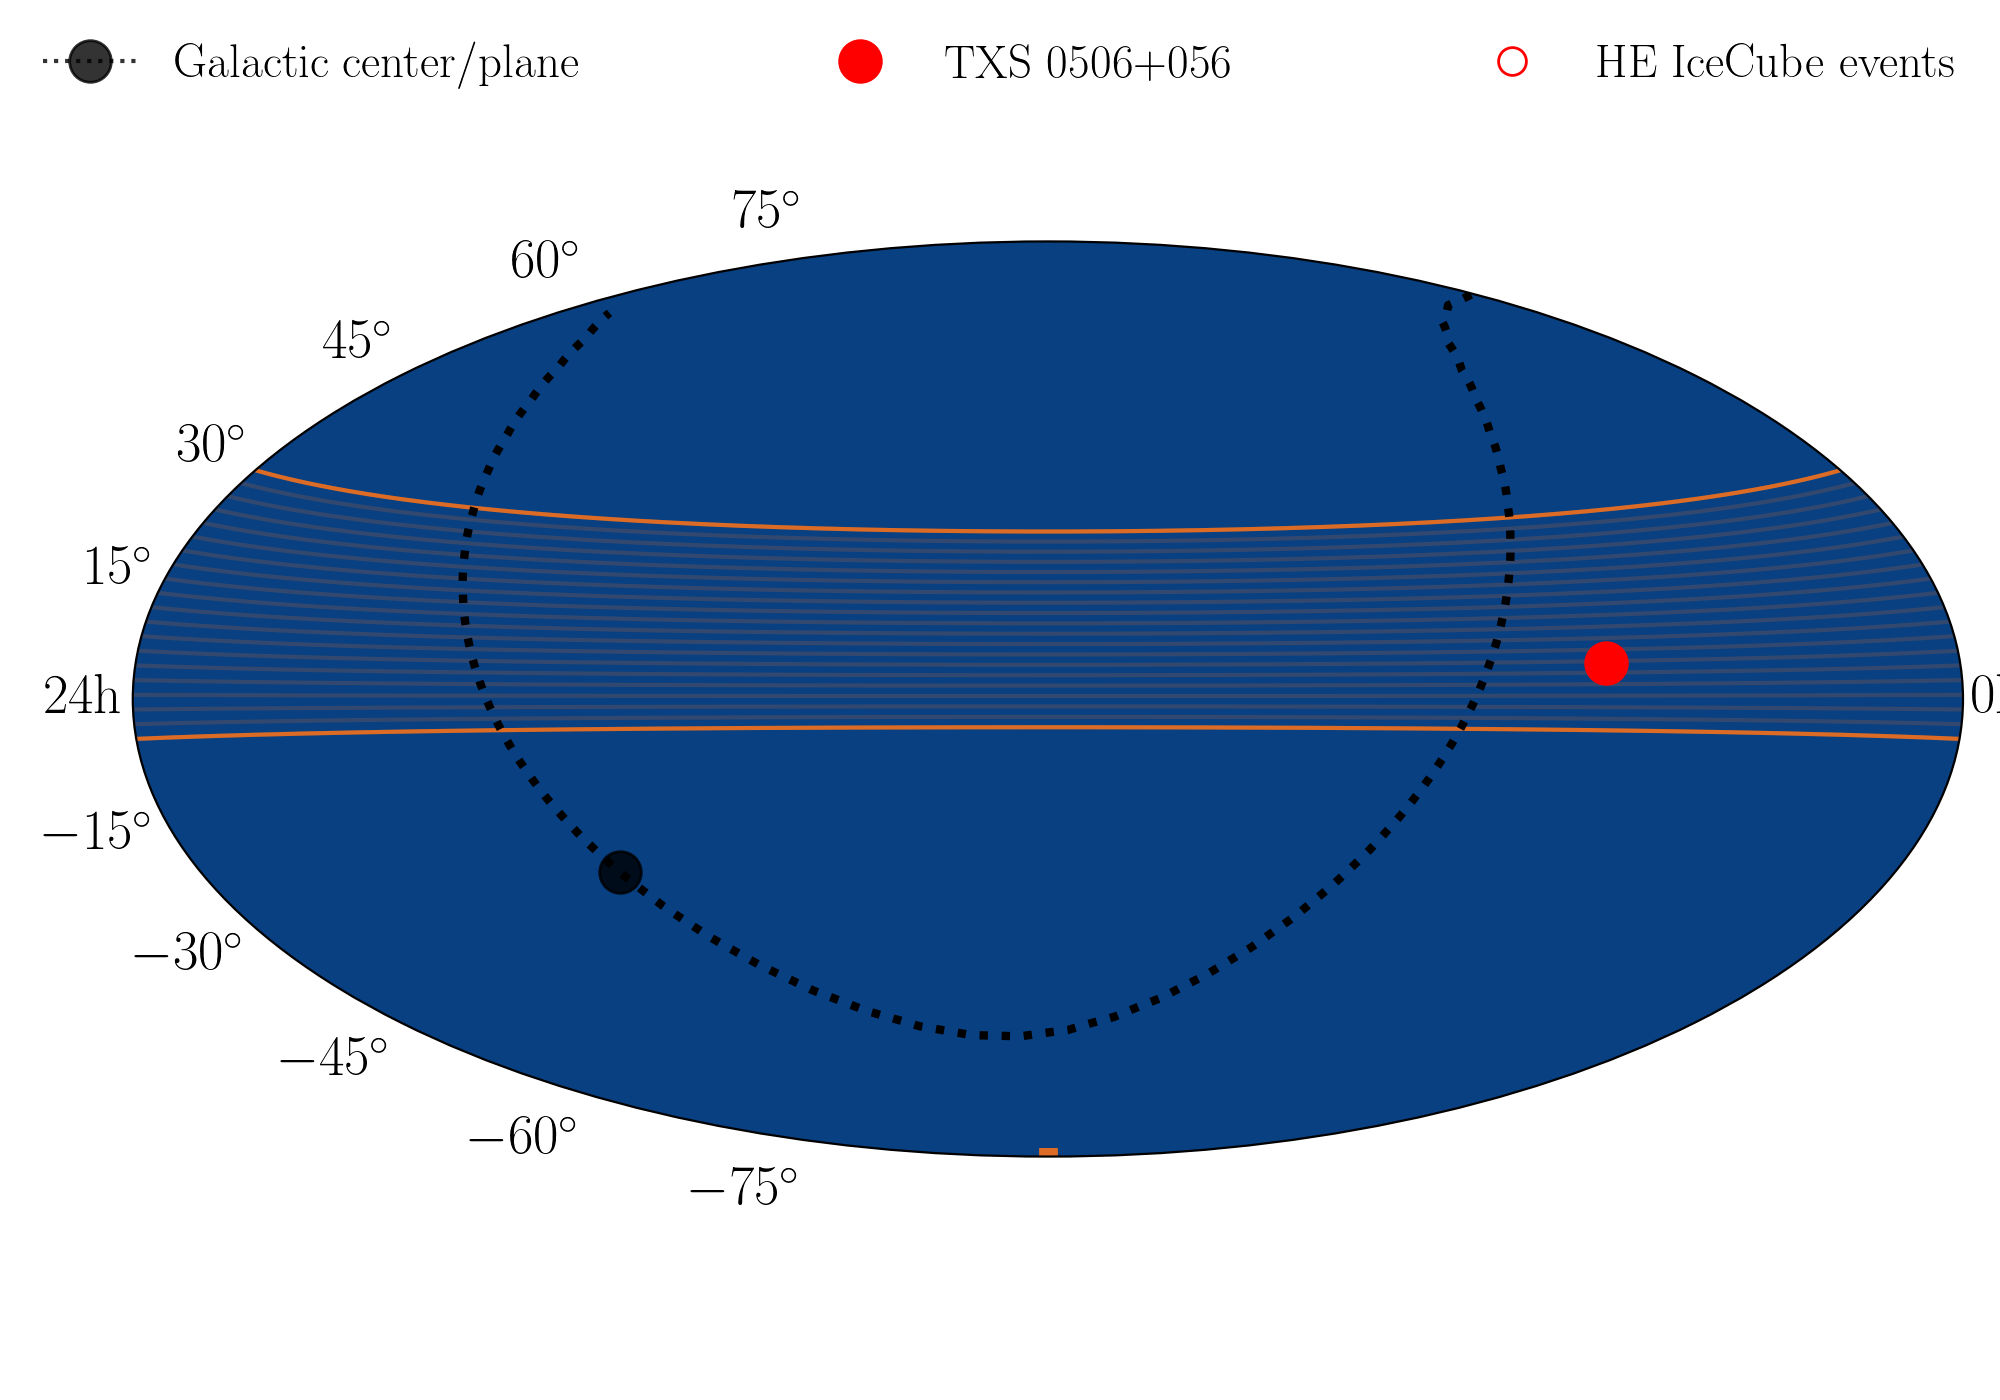

('N pixels:', 49152.0, 49152)


In [26]:
fig =  plt.figure(figsize=(10,7.))

ax= fig.add_subplot(111, projection='hammer',
                                       rasterized=True)

#-------------------------------
#plot everything
#-------------------------------


cax=plot_area(new_vals, ax, npix=ngrid,  alpha=1., #vmin=2.e-1, #vmax=1.,
             shading='gouraud', cmap='GnBu_r',norm=LogNorm())

print('N pixels:', np.sum(new_vals), len(new_vals))

#cbar = fig.colorbar(cax,  orientation='horizontal')
#cbar.set_label(r'$N_{\mathrm{bckg}}$ / pixel', 
#               fontsize=fs)
#cbar.ax.tick_params(labelsize=fs)


#---------------------------------------
# show the IceCube lines between -5 and 30 deg
#---------------------------------------
c = '#DC6C25'
num = 10
x = np.linspace(0,2*np.pi, num)
y = np.tile(np.radians(-5.) ,num)

_x,_y =  _trans(x, y)
ind = np.argsort(_x)
ax.plot(_x[ind], _y[ind], color=c)

for y_i in np.linspace(-5, 30,num=20, endpoint=True): 
    y2 = np.tile(y_i ,len(x))
    
    _x2, _y2 = _trans(x, np.radians(y2))
    ind = np.argsort(_x2)
    ax.plot(np.sort(_x2), _y2[ind], color=c, alpha=0.2)

ind = np.argsort(_x2)
ax.plot(_x2[ind], _y2[ind], color=c)

loc1, loc2 = _trans(0, -np.pi/2)
ax.plot(loc1, loc2, marker='s', c=c, linestyle='None')




#-------------------------------
# fix the labels
#-------------------------------

set_ticks(ax, fs=fs)
    

#---------------------------------------
# add the galactic center and plane
#---------------------------------------

add_plane(ax, color='black')

add_txs(ax)



#get all legend entries and add the circle for the HE events
handles, labels = ax.get_legend_handles_labels()
HE_events = Line2D(range(1), range(1), color="red", marker='o',markersize=10, markerfacecolor="None",
              linewidth=0, label='HE IceCube events')

handles.append(HE_events)

fig.legend(handles=handles, fontsize=fs-3, loc='best', mode='expand',
            ncol=3, frameon=False)




fig.tight_layout()

plt.subplots_adjust(top = 0.98)#, bottom=0.2)
#fig.savefig('plots/Galactic_Center_Template.png',
#               bbox_inches="tight", dpi=200)

--------
# This is the start for the analysis chain
-------

# get the background values vs energy


In [27]:
lt = 10*365.25*86400.

In [28]:
# this is the template that we want to use
t_masks = {'icecube':mask_north, 'plenum':mask_full_sky}
template = 'north'


num = 5000#5000
x = np.linspace(0,2*np.pi, num)
y = np.linspace(-np.pi/2,np.pi/2 , 200)  # 500

Background_values = dict()
Background_values_prompt = dict()
Background_values_reco = dict()
Background_values_prompt_reco = dict()

Signal_values = dict()
Signal_values_cutoff = dict()
Signal_values_broken = dict()
Signal_values_reco = dict()
Signal_values_broken_reco = dict()
Signal_values_cutoff_reco = dict()
    
for exp in ['icecube', 'plenum']:

    t_mask = t_masks[exp]
    
    Bckg_vals = np.zeros_like(etrue_mids, dtype=float)
    Bckg_vals_pr = np.zeros_like(etrue_mids, dtype=float)
    Bckg_vals_reco = np.zeros_like(ereco_mids, dtype=float)
    Bckg_vals_pr_reco = np.zeros_like(ereco_mids, dtype=float)

    Sig_vals = np.zeros_like(etrue_mids, dtype=float)
    Sig_vals_broken = np.zeros_like(etrue_mids, dtype=float)
    Sig_vals_cutoff = np.zeros_like(etrue_mids, dtype=float)
    Sig_vals_reco = np.zeros_like(ereco_mids, dtype=float)
    Sig_vals_cutoff_reco = np.zeros_like(ereco_mids, dtype=float)
    Sig_vals_broken_reco = np.zeros_like(ereco_mids, dtype=float)

    ntot_numu = Res_numu[exp]
    ntot_numu_prompt = Res_numu_prompt[exp]
    ntot_mu = Res_mu[exp]
    ntot_mu_prompt = Res_mu_prompt[exp]
    ntot_sig = ResSig[exp]
    ntot_sig_broken = ResSig_broken[exp]
    ntot_sig_cutoff = ResSig_cutoff[exp]
    
    ntot_numu_reco = Res_numu_reco[exp]
    ntot_numu_prompt_reco = Res_numu_prompt_reco[exp]
    ntot_mu_reco = Res_mu_reco[exp]
    ntot_mu_prompt_reco = Res_mu_prompt_reco[exp]
    ntot_sig_reco = ResSig_reco[exp]
    ntot_sig_broken_reco = ResSig_broken_reco[exp]
    ntot_sig_cutoff_reco = ResSig_cutoff_reco[exp]


    
    ############################################################
    # get first the bin expectations in true energy bins
    ############################################################
    for k, i in enumerate(etrue_mids):    
    
        # spline fit all distributions to get more accurate results
        max_val = np.max(ntot_numu[k])
        tck = splrep(get_mids(sd_bins), ntot_numu[k]/max_val , s=1.e-2)

        max_val_numu_pr = np.max(ntot_numu_prompt[k])
        tck_numu_pr = splrep(get_mids(sd_bins), ntot_numu_prompt[k]/max_val_numu_pr , s=1.e-2)

        max_val_mu = np.max(ntot_mu[k])
        tck_mu = splrep(get_mids(sd_bins), ntot_mu[k]/max_val_mu , s=1.e-2)

        max_val_mu_pr = np.max(ntot_mu_prompt[k])
        tck_mu_pr = splrep(get_mids(sd_bins), ntot_mu_prompt[k]/max_val_mu_pr , s=1.e-2)

        max_val_sig = np.max(ntot_sig[k])
        tck_sig = splrep(get_mids(sd_bins), ntot_sig[k]/max_val_sig , s=1.e-2)
        
        max_val_sig_cutoff = np.max(ntot_sig_cutoff[k])
        tck_sig_cutoff = splrep(get_mids(sd_bins), ntot_sig_cutoff[k]/max_val_sig_cutoff , s=1.e-2)
        
        max_val_sig_broken = np.max(ntot_sig_broken[k])
        tck_sig_broken = splrep(get_mids(sd_bins), ntot_sig_broken[k]/max_val_sig_broken , s=1.e-2)

        bckg_vals2 = np.ones(npix)
        bckg_vals_pr = np.ones(npix)
        sig_vals2 = np.ones(npix)
        sig_vals_broken = np.ones(npix)
        sig_vals_cutoff = np.ones(npix)
        for dec_i in y:

            #get the pixels
            p = hp.ang2pix(NSIDE, dec_i+np.pi/2, x)
            #fill them 
            # psize account for the pixel size that was chosen
            # hence bckg_vals describe the bckg expectation N from atm numu 
            # per second


            if (dec_i < np.deg2rad(-5.))&(exp=='icecube'):
                bckg_vals2[p] = (splev(np.sin(dec_i), tck)*max_val * psize
                                 + splev(np.sin(dec_i), tck_mu)*max_val_mu * psize)

                bckg_vals_pr[p] = (splev(np.sin(dec_i), tck_numu_pr)*max_val_numu_pr * psize
                                   + splev(np.sin(dec_i), tck_mu_pr)*max_val_mu_pr * psize)
            else:    
                bckg_vals2[p] = splev(np.sin(dec_i), tck)*max_val * psize
                bckg_vals_pr[p] = splev(np.sin(dec_i), tck_numu_pr)*max_val_numu_pr * psize


            sig_vals2[p] = splev(np.sin(dec_i), tck_sig)*max_val_sig * psize
            sig_vals_broken[p] = splev(np.sin(dec_i), tck_sig_broken)*max_val_sig_broken * psize
            sig_vals_cutoff[p] = splev(np.sin(dec_i), tck_sig_cutoff)*max_val_sig_cutoff * psize


        

        bckg_vals2[~t_mask] = 0
        Bckg_vals[k] = np.sum(bckg_vals2*lt)

        bckg_vals_pr[~t_mask] = 0
        Bckg_vals_pr[k] = np.sum(bckg_vals_pr*lt)

        sig_vals2[~t_mask] = 0
        Sig_vals[k] = np.sum(sig_vals2*lt)
        
        sig_vals_broken[~t_mask] = 0
        Sig_vals_broken[k] = np.sum(sig_vals_broken*lt)
        
        sig_vals_cutoff[~t_mask] = 0
        Sig_vals_cutoff[k] = np.sum(sig_vals_cutoff*lt)

    
    Background_values[exp] = Bckg_vals
    Background_values_prompt[exp] = Bckg_vals_pr
    Signal_values[exp] = Sig_vals
    Signal_values_broken[exp] = Sig_vals_broken
    Signal_values_cutoff[exp] = Sig_vals_cutoff
    
    ############################################################
    # get the bin expectations in reco energy bins
    ############################################################
    for k, i in enumerate(ereco_mids):    
    
        # spline fit all distributions to get more accurate results
        max_val = np.max(ntot_numu_reco[k])
        tck = splrep(get_mids(sd_bins), ntot_numu_reco[k]/max_val , s=1.e-2)

        max_val_numu_pr = np.max(ntot_numu_prompt_reco[k])
        tck_numu_pr = splrep(get_mids(sd_bins), ntot_numu_prompt_reco[k]/max_val_numu_pr , s=1.e-2)

        max_val_mu = np.max(ntot_mu_reco[k])
        tck_mu = splrep(get_mids(sd_bins), ntot_mu_reco[k]/max_val_mu , s=1.e-2)

        max_val_mu_pr = np.max(ntot_mu_prompt_reco[k])
        tck_mu_pr = splrep(get_mids(sd_bins), ntot_mu_prompt_reco[k]/max_val_mu_pr , s=1.e-2)

        max_val_sig = np.max(ntot_sig_reco[k])
        tck_sig = splrep(get_mids(sd_bins), ntot_sig_reco[k]/max_val_sig , s=1.e-2)
        
        max_val_sig_broken = np.max(ntot_sig_broken_reco[k])
        tck_sig_broken = splrep(get_mids(sd_bins), ntot_sig_broken_reco[k]/max_val_sig_broken , s=1.e-2)
        
        max_val_sig_cutoff = np.max(ntot_sig_cutoff_reco[k])
        tck_sig_cutoff = splrep(get_mids(sd_bins), ntot_sig_cutoff_reco[k]/max_val_sig_cutoff , s=1.e-2)

        bckg_vals2 = np.ones(npix)
        bckg_vals_pr = np.ones(npix)
        sig_vals2 = np.ones(npix)
        sig_vals_broken = np.ones(npix)
        sig_vals_cutoff = np.ones(npix)
        for dec_i in y:

            #get the pixels
            p = hp.ang2pix(NSIDE, dec_i+np.pi/2, x)
            #fill them 
            # psize account for the pixel size that was chosen
            # hence bckg_vals describe the bckg expectation N from atm numu 
            # per second


            if (dec_i < np.deg2rad(-5.))&(exp=='icecube'):
                bckg_vals2[p] = (splev(np.sin(dec_i), tck)*max_val * psize
                                 + splev(np.sin(dec_i), tck_mu)*max_val_mu * psize)

                bckg_vals_pr[p] = (splev(np.sin(dec_i), tck_numu_pr)*max_val_numu_pr * psize
                                   + splev(np.sin(dec_i), tck_mu_pr)*max_val_mu_pr * psize)
            else:    
                bckg_vals2[p] = splev(np.sin(dec_i), tck)*max_val * psize
                bckg_vals_pr[p] = splev(np.sin(dec_i), tck_numu_pr)*max_val_numu_pr * psize


            sig_vals2[p] = splev(np.sin(dec_i), tck_sig)*max_val_sig * psize
            sig_vals_broken[p] = splev(np.sin(dec_i), tck_sig_broken)*max_val_sig_broken * psize
            sig_vals_cutoff[p] = splev(np.sin(dec_i), tck_sig_cutoff)*max_val_sig_cutoff * psize


        

        bckg_vals2[~t_mask] = 0
        Bckg_vals_reco[k] = np.sum(bckg_vals2*lt)

        bckg_vals_pr[~t_mask] = 0
        Bckg_vals_pr_reco[k] = np.sum(bckg_vals_pr*lt)

        sig_vals2[~t_mask] = 0
        Sig_vals_reco[k] = np.sum(sig_vals2*lt)
        
        sig_vals_broken[~t_mask] = 0
        Sig_vals_broken_reco[k] = np.sum(sig_vals_broken*lt)
        
        sig_vals_cutoff[~t_mask] = 0
        Sig_vals_cutoff_reco[k] = np.sum(sig_vals_cutoff*lt)

    
    Background_values_reco[exp] = Bckg_vals_reco
    Background_values_prompt_reco[exp] = Bckg_vals_pr_reco
    Signal_values_reco[exp] = Sig_vals_reco
    Signal_values_broken_reco[exp] = Sig_vals_broken_reco
    Signal_values_cutoff_reco[exp] = Sig_vals_cutoff_reco
    

<IPython.core.display.Javascript object>


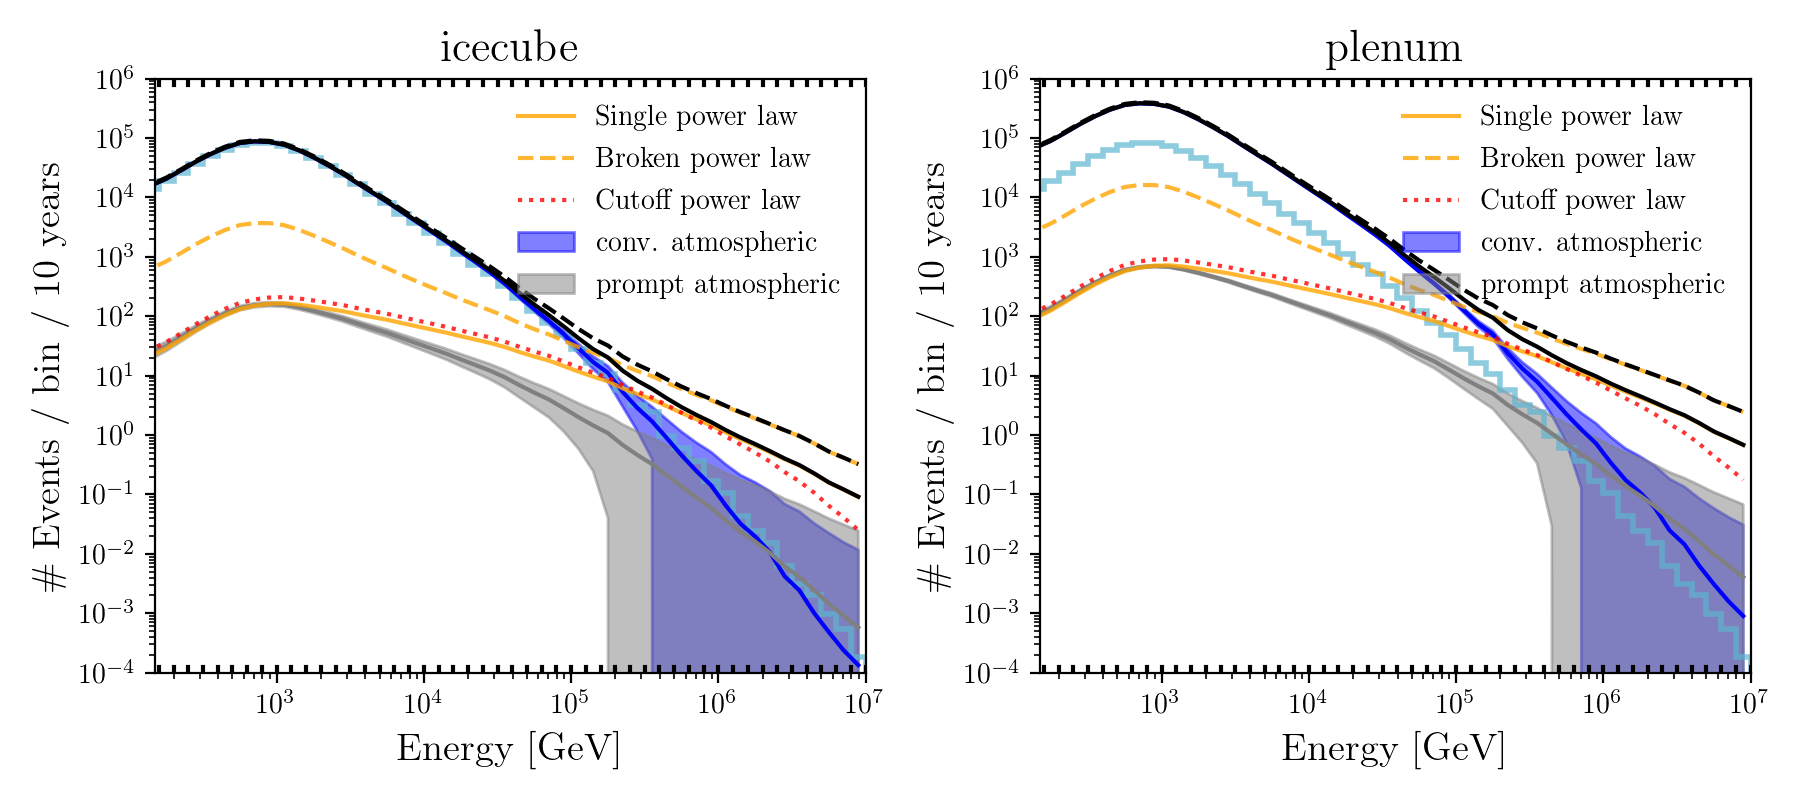

('icecube', 798057.264996316)
('mc', 755411.406648681)
('plenum', 3485849.5606062803)
('mc', 755411.406648681)


In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

for k, exp in enumerate(['icecube', 'plenum']):

    ax = axes[k]
    ax.set_title(exp, fontsize=16)
    Bckg_vals = Background_values_reco[exp]
    Bckg_vals_pr = Background_values_prompt_reco[exp]
    Sig_vals = Signal_values_reco[exp]
    Sig_vals_broken = Signal_values_broken_reco[exp]
    Sig_vals_cutoff = Signal_values_cutoff_reco[exp]
    #print(Sig_vals_cutoff_reco)
    
    
    
    Bckg_vals[Bckg_vals<=0] = 0
    yerr=np.sqrt(Bckg_vals)
    ax.plot(ereco_mids, Bckg_vals, color='blue')
    ax.fill_between(ereco_mids, Bckg_vals-yerr, Bckg_vals+yerr, alpha=0.5, color='blue',
                   label = r'conv. atmospheric')

    Bckg_vals_pr[Bckg_vals_pr<=0] = 0
    yerr=np.sqrt(Bckg_vals_pr)
    ax.plot(ereco_mids, Bckg_vals_pr, color='grey')
    ax.fill_between(ereco_mids, Bckg_vals_pr-yerr, Bckg_vals_pr+yerr, alpha=0.5, color='grey',
                   label = r'prompt atmospheric')


    Sig_vals[Sig_vals<=0] = 0
    ax.plot(ereco_mids, Sig_vals, color='orange', label='Single power law', alpha=0.8)
    
    Sig_vals_broken[Sig_vals_broken<=0] = 0
    ax.plot(ereco_mids, Sig_vals_broken, color='orange', ls='dashed', label='Broken power law', alpha=0.8)
    
    Sig_vals_cutoff[Sig_vals_cutoff<=0] = 0
    ax.plot(ereco_mids, Sig_vals_cutoff, color='red', ls='dotted', label='Cutoff power law', alpha=0.8)



    res_tot = Bckg_vals+Bckg_vals_pr+Sig_vals
    res_tot_broken = Bckg_vals+Bckg_vals_pr+Sig_vals_broken
    
    ax.plot(ereco_mids, res_tot, color='black', ls='solid')
    ax.plot(ereco_mids, res_tot_broken, color='black', ls='dashed')
    
    
    # indicate the binning in energy
    for ei in ereco_bins:
        ax.axvline(ei, ymin=0, ymax=0.01, color='black')
        ax.axvline(ei, ymin=0.99, ymax=1, color='black')


    ax.set_xlim(1.5e2,1e7)
    ax.set_ylim(1e-4,1.e6)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel('Energy [GeV]', fontsize=14)
    ax.set_ylabel(r'\# Events / bin / 10 years', fontsize=14)
    ax.legend(loc='upper right', frameon=False)

    idata = np.load('/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')
    
    w = (idata['conv']+idata['prompt'])*lt #* idata['trueE']**(-gamma)
    print(exp, np.sum(Bckg_vals))
    print('mc', np.sum(w))
    
    ax.hist(10**(idata['logE']), bins=ereco_bins, weights=w, color=colors[1],
            label=r'Atm. $\nu_{\mu}$', linewidth=2., histtype='step', alpha=0.7)
    
    
    
fig.tight_layout()


# in order fo fit the spectral index and flux normalisation we need a function that relates the expected bin entries to the physical parameters 

here this is $\lambda_i = f(i|\phi_0, \gamma)$

In [30]:
def conv_phi100_to_phi0(phi100, gamma):
    return 10**(5.*gamma) * phi100
    

In [31]:
phi100s = 10**np.linspace(-23,-16, 10)
gammas = np.arange(1.5,4.1,0.5)

# function relating physical parameters to expected bin counts
# (dec, energy, phi0, gamma)
F = dict()
xx,yy = np.meshgrid(np.log10(etrue_mids), np.log10(ereco_mids), indexing='ij')
smearing = np.exp(smearing_spline((xx,yy)))
smearing = smearing / smearing.sum(axis=1)[:,np.newaxis]

for exp in ['icecube', 'plenum']:

    fexp  = np.zeros((n_sd, n_ereco, len(phi100s), len(gammas)), dtype=float)
    effA = copy(results['effA_'+exp].reshape((n_sd, n_e)))

    for i, sd_i in enumerate(get_mids(sd_bins)):
    
        h_aeff = effA[i]
        for k, phi100i in enumerate(phi100s):
            for l, gamma_l in enumerate(gammas):
                phi0i = conv_phi100_to_phi0(phi100i, gamma_l)
                fexp_ikl = [phi0i * int_powerlaw(gamma_l, etrue_bins[j], etrue_bins[j+1]) * h_aeff[j] 
                                for j,ej in enumerate(etrue_mids)] 
                
                # Now also get the event rates in reco energy bins
                fexp[i,:,k,l] = np.dot(smearing.T, fexp_ikl)
                
    F[exp] = fexp
    print('{0} done!'.format(exp))
    

icecube done!
plenum done!


In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

F_TEMPLATE = dict()

for k, exp in enumerate(['icecube', 'plenum']):

    t_mask = t_masks[exp]
    
    ax = axes[k]
    Bckg_vals = Background_values_reco[exp]
    Bckg_vals_pr = Background_values_prompt_reco[exp]
    Sig_vals = Signal_values_reco[exp]

    Bckg_vals[Bckg_vals<=0] = 0
    yerr=np.sqrt(Bckg_vals)
    ax.plot(ereco_mids, Bckg_vals, color='blue')
    ax.fill_between(ereco_mids, Bckg_vals-yerr, Bckg_vals+yerr, alpha=0.5, color='blue',
                   label = r'conv. atmospheric')

    Bckg_vals_pr[Bckg_vals_pr<=0] = 0
    yerr=np.sqrt(Bckg_vals_pr)
    ax.plot(ereco_mids, Bckg_vals_pr, color='grey')
    ax.fill_between(ereco_mids, Bckg_vals_pr-yerr, Bckg_vals_pr+yerr, alpha=0.5, color='grey',
                   label = r'prompt atmospheric')

    # add all possible outcomes to the final plot jus to see if the calculation of F makes sense

    f = F[exp]
    cs = ['orange','red','pink']

    F_template = np.zeros(( len(phi100s), len(gammas), n_ereco), dtype=float)

    for l, phi100l in enumerate(phi100s):

        for m, gamma_m in enumerate(gammas):
            sig_final = np.zeros_like(ereco_mids, dtype=float)
            for k, i in enumerate(ereco_mids):

                max_val_sig = np.max(f[:,k,l,m])
                tck_sig = splrep(get_mids(sd_bins), f[:,k,l,m]/max_val_sig , s=1.e-2)
                
                # this might be faster
                dec_i = hp.pix2ang(NSIDE, range(npix))[0]
                dec_i -= np.pi/2
                sig_valsi = splev(np.sin(dec_i), tck_sig)*max_val_sig * psize
                
                #sig_valsi = np.ones(npix)
                #for dec_i in y:
                #    #get the pixels
                #    p = hp.ang2pix(NSIDE, dec_i+np.pi/2, x)
                #    sig_valsi[p] = splev(np.sin(dec_i), tck_sig)*max_val_sig * psize


                sig_valsi[~t_mask] = 0
                sig_final[k] = np.sum(sig_valsi*lt)

            sig_final[sig_final<=0] = 0
            F_template[l,m,:] = sig_final

            ax.plot(ereco_mids, sig_final,  alpha=0.3) # color=cs[m] ,
        print('{0} out of {1} normalisations done!'.format(l+1, len(phi100s)))

    F_TEMPLATE[exp] = F_template
    # indicate the binning in energy
    for ei in ereco_bins:
        ax.axvline(ei, ymin=0, ymax=0.01, color='black')
        ax.axvline(ei, ymin=0.99, ymax=1, color='black')


    ax.set_xlim(1e2,1e7)
    #ax.set_ylim(1e-4,1.e5)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel('Energy [GeV]', fontsize=14)
    ax.set_ylabel(r'\# Events / 10 years', fontsize=14)
    ax.legend(loc='upper right', frameon=False)

fig.tight_layout()

<IPython.core.display.Javascript object>

1 out of 10 normalisations done!
2 out of 10 normalisations done!
3 out of 10 normalisations done!
4 out of 10 normalisations done!
5 out of 10 normalisations done!
6 out of 10 normalisations done!
7 out of 10 normalisations done!
8 out of 10 normalisations done!
9 out of 10 normalisations done!
10 out of 10 normalisations done!
1 out of 10 normalisations done!
2 out of 10 normalisations done!
3 out of 10 normalisations done!
4 out of 10 normalisations done!
5 out of 10 normalisations done!
6 out of 10 normalisations done!
7 out of 10 normalisations done!
8 out of 10 normalisations done!
9 out of 10 normalisations done!
10 out of 10 normalisations done!


# Try to spline fit the functions 

<IPython.core.display.Javascript object>


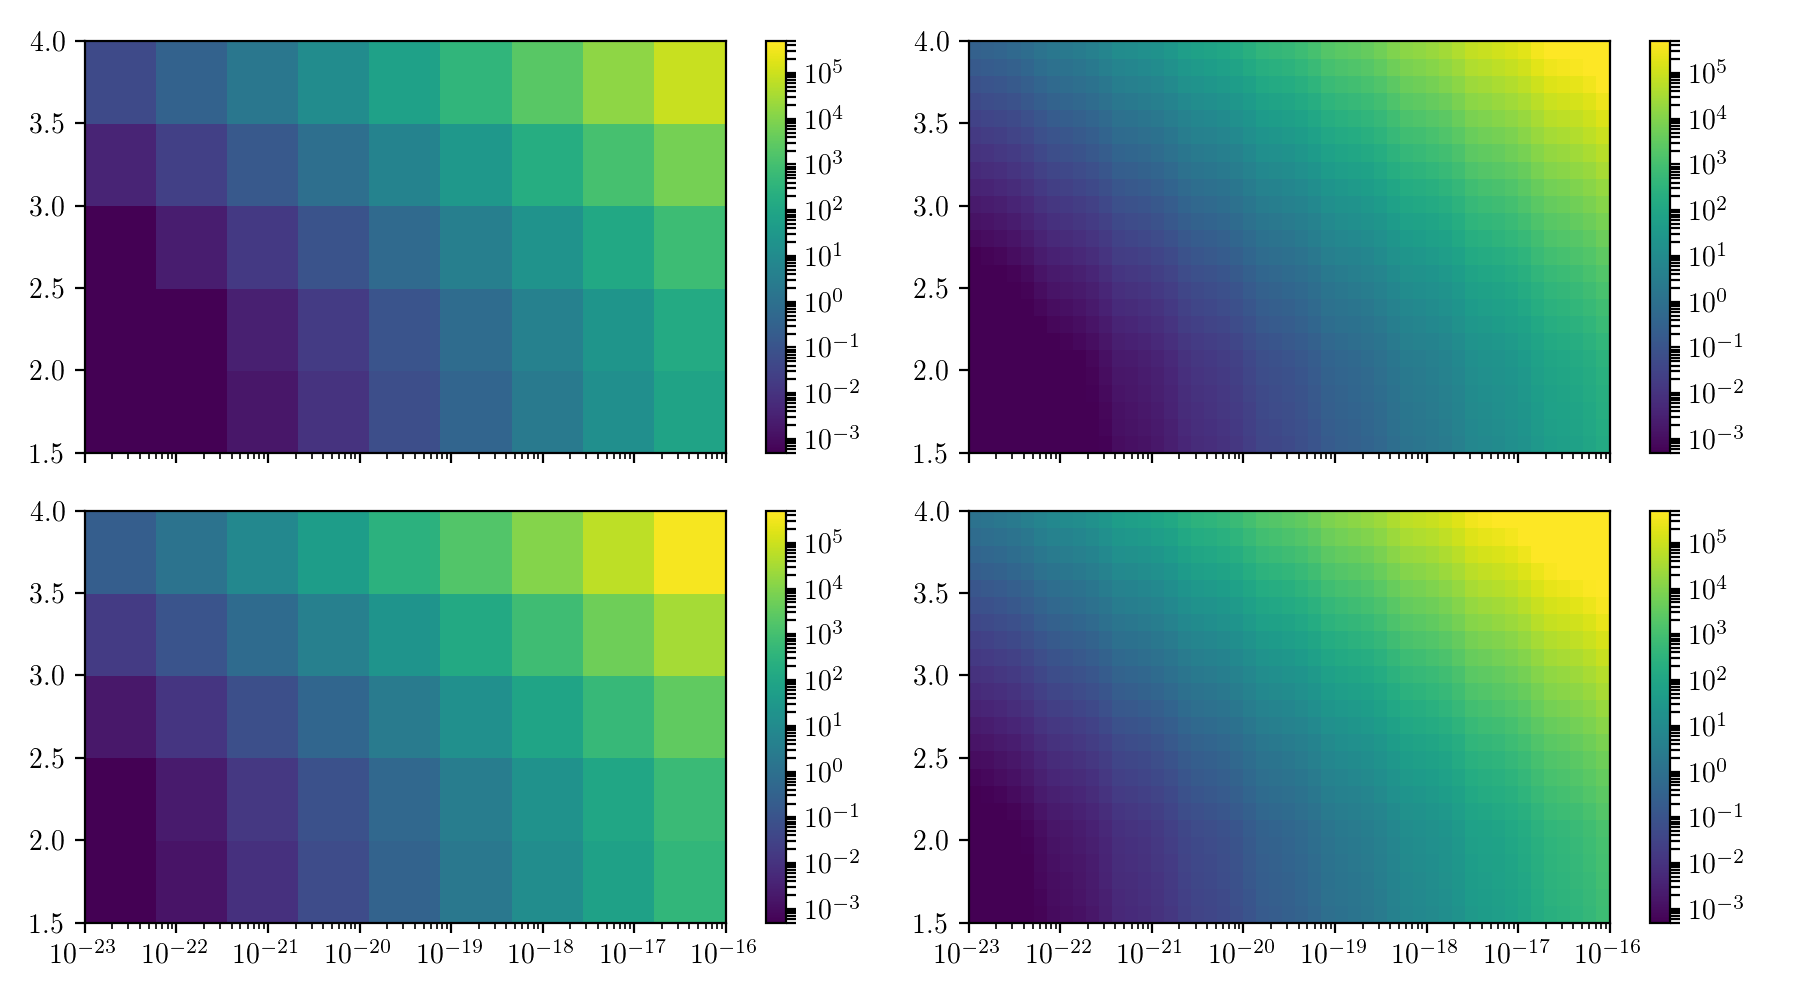

In [33]:
import scipy
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9,5), sharex=True)

Splines = dict()

for k, exp in enumerate(['icecube', 'plenum']):
    
    
    F_template = copy(F_TEMPLATE[exp])
    F_template[F_template==0] = 1e-15

    
    binmids = (phi100s, gammas, ereco_mids)
    spline = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(F_template),
                    method="linear",
                    bounds_error=False,
                    fill_value=1e-15,
                    )

    Splines[exp] = spline
    ax = axes[k,0]
    p = ax.pcolormesh(phi100s, gammas, F_template[...,2].T, norm=LogNorm(), 
                      vmax=5e5,vmin=5e-4)
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')

    ax = axes[k,1]
    _phis = 10**np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 50 )
    _gs = np.linspace(np.min(gammas), np.max(gammas), 25)
    xx, yy = np.meshgrid(_phis, _gs, indexing='ij')
    spline_res = np.exp(spline((xx,yy,ereco_mids[0])))


    p = ax.pcolormesh(_phis, _gs, spline_res.T, norm=LogNorm(),  vmax=5e5,vmin=5e-4)
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')

fig.tight_layout()

# Now that we have the splines for the single power law we also need them for broken power-laws

In [34]:
# function relating physical parameters to expected bin counts
# (dec, energy, phi0, gamma0, gamma1)

F_broken = dict()
E_thresholds = [2e4, 1e5] # fix this value for now

for exp in ['icecube', 'plenum']:

    F_broken[exp] = dict()
    for ek, E_threshold in enumerate(E_thresholds):
        fexp  = np.zeros((n_sd, n_ereco, len(phi100s), len(gammas), len(gammas)), dtype=float)
        effA = copy(results['effA_'+exp].reshape((n_sd, n_e)))

        for i, sd_i in enumerate(get_mids(sd_bins)):

            h_aeff = effA[i]
            for k, phi100i in enumerate(phi100s):
                for l0, gamma_l0 in enumerate(gammas):
                    for l1, gamma_l1 in enumerate(gammas):
                        # not necessay since these are exactly the same as the other way round
                        if gamma_l1 > gamma_l0:
                            continue
                        fexp_ikl0l1 = [(phi100i * int_broken_powerlaw(gamma_l0, gamma_l1, 
                                                                           E_threshold, etrue_bins[j], 
                                                                           etrue_bins[j+1]) * h_aeff[j]) 
                                    for j,ej in enumerate(etrue_mids)] 

                        fexp[i,:,k,l0,l1] = np.dot(smearing.T, fexp_ikl0l1)

        F_broken[exp][ek] = fexp
    print('{0} done!'.format(exp))


icecube done!
plenum done!


In [35]:
print(np.log10(phi100s), gammas)

(array([-23.        , -22.22222222, -21.44444444, -20.66666667,
       -19.88888889, -19.11111111, -18.33333333, -17.55555556,
       -16.77777778, -16.        ]), array([1.5, 2. , 2.5, 3. , 3.5, 4. ]))


<IPython.core.display.Javascript object>


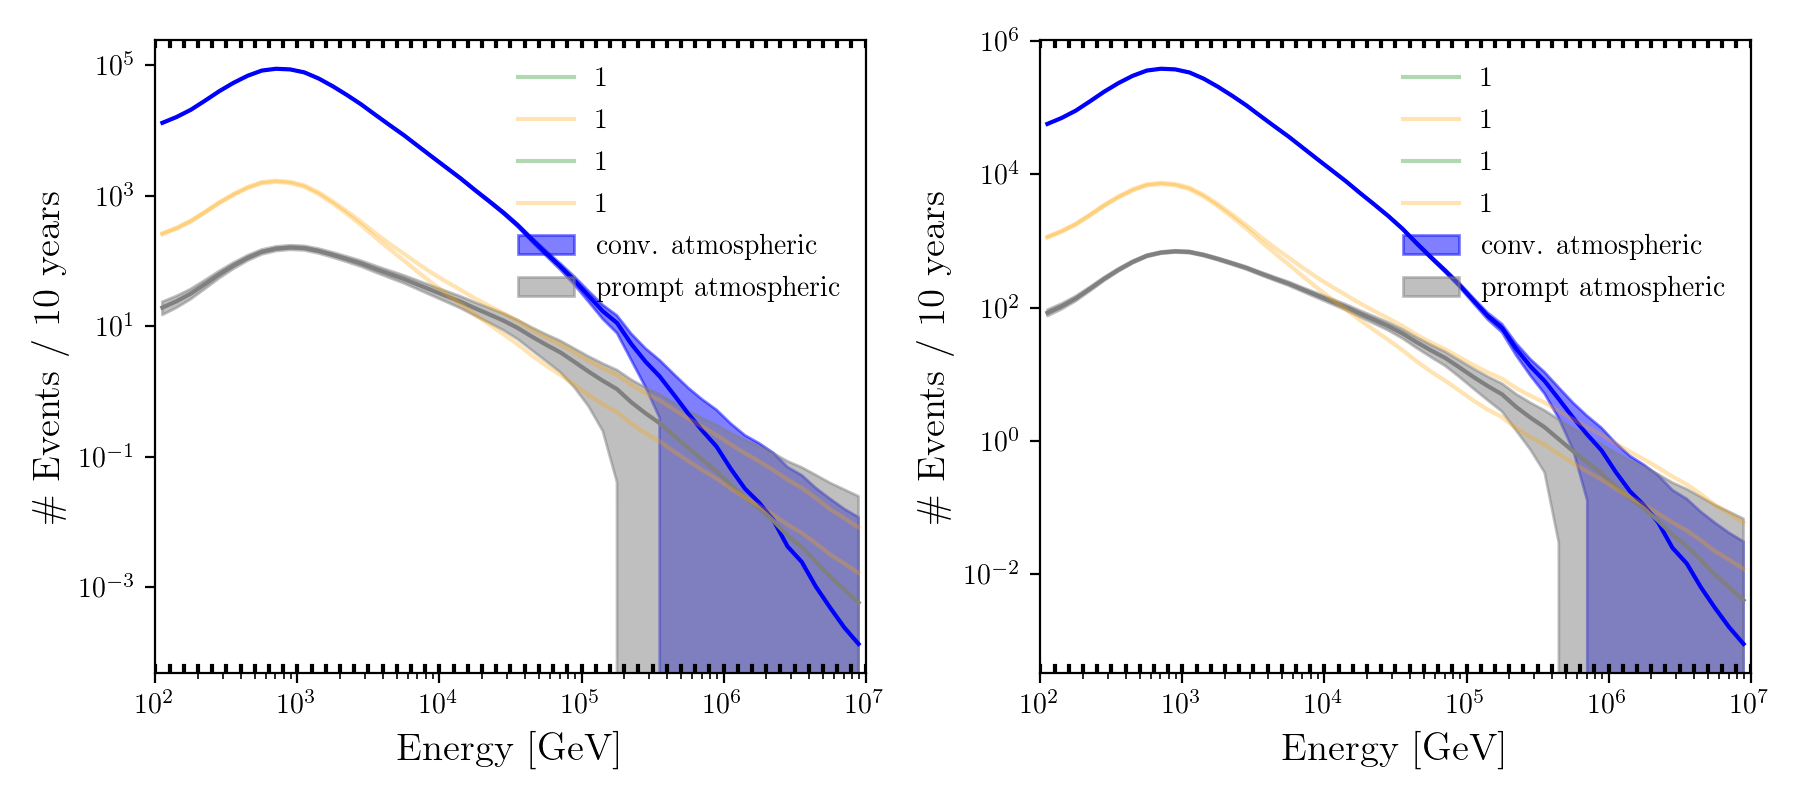

1 out of 10 normalisations done!
2 out of 10 normalisations done!
3 out of 10 normalisations done!
4 out of 10 normalisations done!
5 out of 10 normalisations done!
6 out of 10 normalisations done!
7 out of 10 normalisations done!
8 out of 10 normalisations done!
9 out of 10 normalisations done!
10 out of 10 normalisations done!
1 out of 10 normalisations done!
2 out of 10 normalisations done!
3 out of 10 normalisations done!
4 out of 10 normalisations done!
5 out of 10 normalisations done!
6 out of 10 normalisations done!
7 out of 10 normalisations done!
8 out of 10 normalisations done!
9 out of 10 normalisations done!
10 out of 10 normalisations done!
1 out of 10 normalisations done!
2 out of 10 normalisations done!
3 out of 10 normalisations done!
4 out of 10 normalisations done!
5 out of 10 normalisations done!
6 out of 10 normalisations done!
7 out of 10 normalisations done!
8 out of 10 normalisations done!
9 out of 10 normalisations done!
10 out of 10 normalisations done!
1 out o

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

F_TEMPLATE_broken = dict()

for k, exp in enumerate(['icecube', 'plenum']):

    t_mask = t_masks[exp]
    ax = axes[k]
    Bckg_vals = Background_values_reco[exp]
    Bckg_vals_pr = Background_values_prompt_reco[exp]
    Sig_vals = Signal_values_reco[exp]

    Bckg_vals[Bckg_vals<=0] = 0
    yerr=np.sqrt(Bckg_vals)
    ax.plot(ereco_mids, Bckg_vals, color='blue')
    ax.fill_between(ereco_mids, Bckg_vals-yerr, Bckg_vals+yerr, alpha=0.5, color='blue',
                   label = r'conv. atmospheric')

    Bckg_vals_pr[Bckg_vals_pr<=0] = 0
    yerr=np.sqrt(Bckg_vals_pr)
    ax.plot(ereco_mids, Bckg_vals_pr, color='grey')
    ax.fill_between(ereco_mids, Bckg_vals_pr-yerr, Bckg_vals_pr+yerr, alpha=0.5, color='grey',
                   label = r'prompt atmospheric')

    cs = ['orange','red','pink']
    F_TEMPLATE_broken[exp] = dict()
    for ek, E_threshold in enumerate(E_thresholds):
    
    # add all possible outcomes to the final plot jus to see if the calculation of F makes sense

        f = F_broken[exp][ek]
        F_template = np.zeros((len(phi100s), len(gammas), len(gammas), n_ereco), dtype=float)

        for l, phi100l in enumerate(phi100s):

            for m0, gamma_m0 in enumerate(gammas):
                for m1, gamma_m1 in enumerate(gammas):
                    sig_final = np.zeros_like(ereco_mids, dtype=float)

                    if gamma_m1 <= gamma_m0:    
                        for k, i in enumerate(ereco_mids):

                            max_val_sig = np.max(f[:,k,l,m0,m1])
                            tck_sig = splrep(get_mids(sd_bins), f[:,k,l,m0,m1]/max_val_sig , s=1.e-2)


                            # this might be faster
                            dec_i = hp.pix2ang(NSIDE, range(npix))[0]
                            dec_i -= np.pi/2
                            sig_valsi = splev(np.sin(dec_i), tck_sig)*max_val_sig * psize

                            #sig_valsi = np.ones(npix)
                            #for dec_i in y:
                            #    #get the pixels
                            #    p = hp.ang2pix(NSIDE, dec_i+np.pi/2, x)
                            #    sig_valsi[p] = splev(np.sin(dec_i), tck_sig)*max_val_sig * psize


                            sig_valsi[~t_mask] = 0
                            sig_final[k] = np.sum(sig_valsi*lt)

                    sig_final[sig_final<=0] = 0
                    F_template[l,m0,m1,:] = sig_final

                    if (m0 == 4) and (m1 == 2) and (l==5):
                        ax.plot(ereco_mids, sig_final,  alpha=0.3, color='orange', label='1')
                    if (m0 == 2) and (m1 == 4) and (l==5):
                        ax.plot(ereco_mids, sig_final,  alpha=0.3, color='green', label='1')
                        # color=cs[m] ,
            print('{0} out of {1} normalisations done!'.format(l+1, len(phi100s)))

        F_TEMPLATE_broken[exp][ek] = F_template
    
    # indicate the binning in energy
    for ei in ereco_bins:
        ax.axvline(ei, ymin=0, ymax=0.01, color='black')
        ax.axvline(ei, ymin=0.99, ymax=1, color='black')


    ax.set_xlim(1e2,1e7)
    #ax.set_ylim(1e-4,1.e5)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel('Energy [GeV]', fontsize=14)
    ax.set_ylabel(r'\# Events / 10 years', fontsize=14)
    ax.legend(loc='upper right', frameon=False)

fig.tight_layout()

<IPython.core.display.Javascript object>


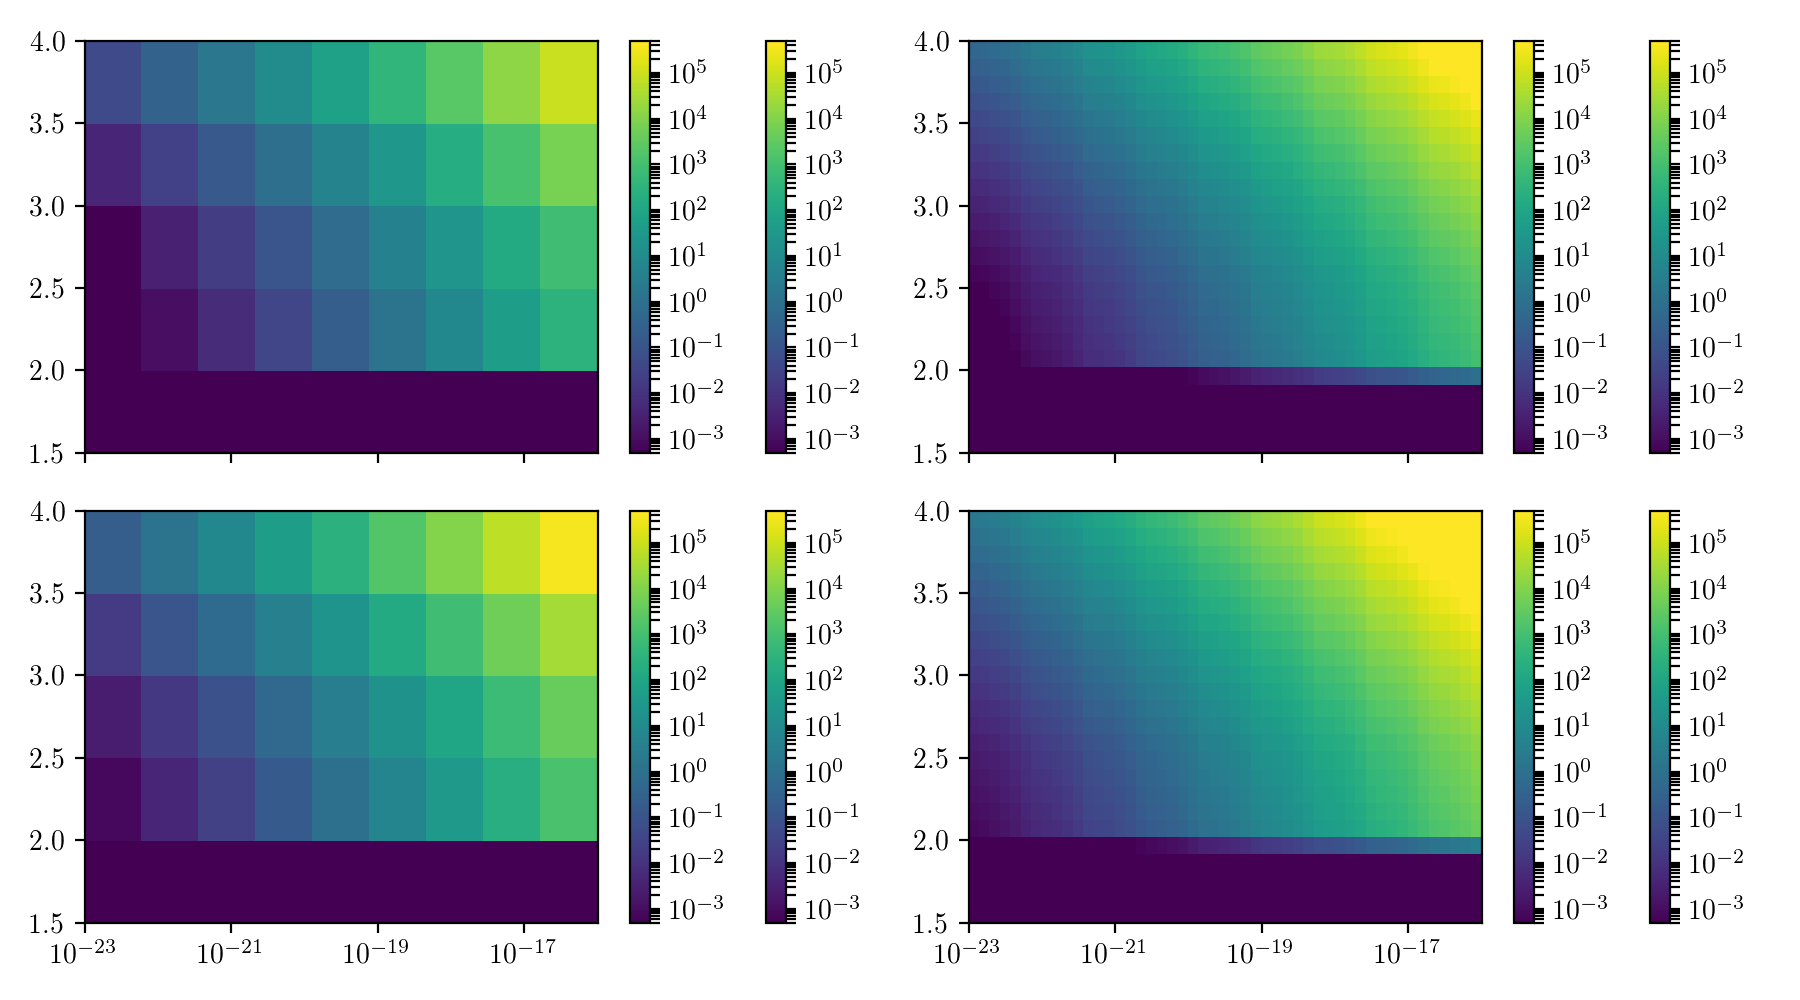

In [37]:
import scipy
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9,5), sharex=True)

Splines_broken = dict()

for k, exp in enumerate(['icecube', 'plenum']):
    
    Splines_broken[exp] = dict()
    for ek, E_threshold in enumerate(E_thresholds):
        F_template = copy(F_TEMPLATE_broken[exp][ek])
        F_template[F_template==0] = 1e-15

        binmids = (phi100s, gammas, gammas, ereco_mids)
        spline_br = scipy.interpolate.RegularGridInterpolator(
                        binmids, np.log(F_template),
                        method="linear",
                        bounds_error=False,
                        fill_value=1e-15,
                        )

        Splines_broken[exp][ek] = spline_br
        ax = axes[k,0]
        p = ax.pcolormesh(phi100s, gammas, F_template[...,1,2].T, norm=LogNorm(), 
                          vmax=5e5,vmin=5e-4)
        cb=fig.colorbar(p,ax=ax)
        ax.set_xscale('log')

        ax = axes[k,1]
        _phis = 10**np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 50 )

        _gs = np.linspace(np.min(gammas), np.max(gammas), 25)
        xx, yy = np.meshgrid(_phis, _gs, indexing='ij')
        spline_res = np.exp(spline_br((xx,yy, gammas[1], ereco_mids[2])))


        p = ax.pcolormesh(_phis, _gs, spline_res.T, norm=LogNorm(),  vmax=5e5,vmin=5e-4)
        cb=fig.colorbar(p,ax=ax)
        ax.set_xscale('log')

fig.tight_layout()

# and now finally also for power laws with exponential cut-offs 

In [38]:
# function relating physical parameters to expected bin counts
# (dec, energy, phi0, gamma0, gamma1)

cutoffs = 10**np.linspace(5,9,15)
F_cutoff = dict()

for exp in ['icecube', 'plenum']:
    
    
    fexp  = np.zeros((n_sd, n_ereco, len(phi100s), len(gammas), len(cutoffs)), dtype=float)
    effA = copy(results['effA_'+exp].reshape((n_sd, n_e)))

    for i, sd_i in enumerate(get_mids(sd_bins)):

        h_aeff = effA[i]
        for k, phi100i in enumerate(phi100s):
            for l0, gamma_l0 in enumerate(gammas):
                for ci, cutoffi in enumerate(cutoffs):
                    fexp_ikl0l1 = [(phi100i * int_cutoff_powerlaw(gamma_l0, cutoffi, etrue_bins[j], 
                                                                       etrue_bins[j+1]) * h_aeff[j]) 
                                for j,ej in enumerate(etrue_mids)] 

                    fexp[i,:,k,l0,ci] = np.dot(smearing.T, fexp_ikl0l1)

    F_cutoff[exp] = fexp
    print('{0} done!'.format(exp))



icecube done!
plenum done!


<IPython.core.display.Javascript object>


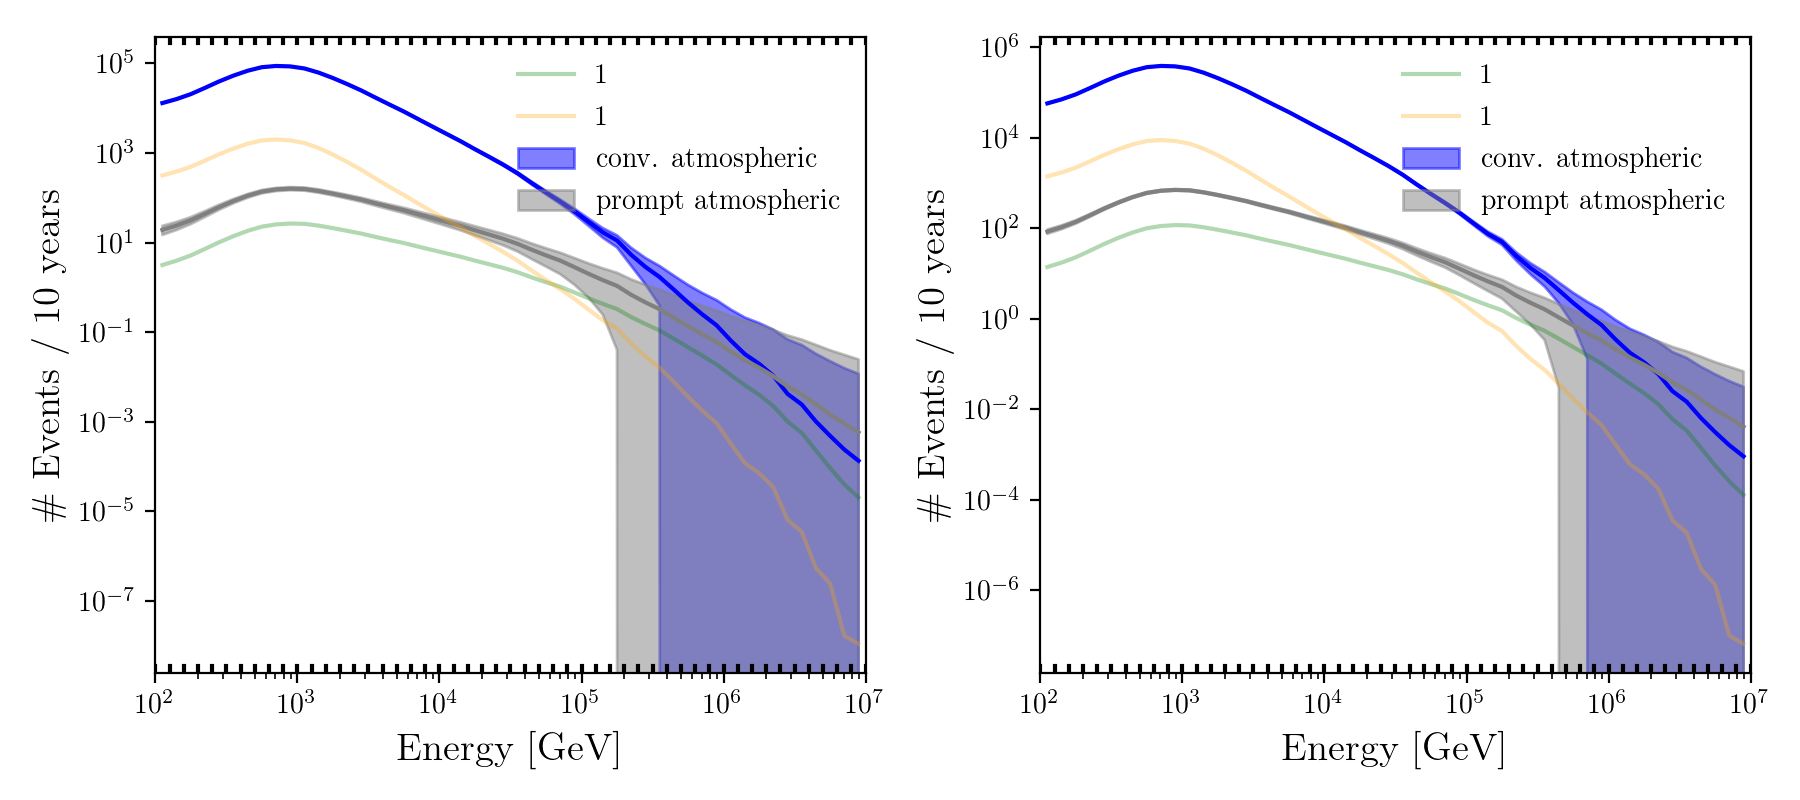

1 out of 10 normalisations done!
2 out of 10 normalisations done!
3 out of 10 normalisations done!
4 out of 10 normalisations done!
5 out of 10 normalisations done!
6 out of 10 normalisations done!
7 out of 10 normalisations done!
8 out of 10 normalisations done!
9 out of 10 normalisations done!
10 out of 10 normalisations done!
1 out of 10 normalisations done!
2 out of 10 normalisations done!
3 out of 10 normalisations done!
4 out of 10 normalisations done!
5 out of 10 normalisations done!
6 out of 10 normalisations done!
7 out of 10 normalisations done!
8 out of 10 normalisations done!
9 out of 10 normalisations done!
10 out of 10 normalisations done!


In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

F_TEMPLATE_cutoff = dict()

for k, exp in enumerate(['icecube', 'plenum']):

    t_mask = t_masks[exp]
    ax = axes[k]
    Bckg_vals = Background_values_reco[exp]
    Bckg_vals_pr = Background_values_prompt_reco[exp]
    Sig_vals = Signal_values_reco[exp]

    Bckg_vals[Bckg_vals<=0] = 0
    yerr=np.sqrt(Bckg_vals)
    ax.plot(ereco_mids, Bckg_vals, color='blue')
    ax.fill_between(ereco_mids, Bckg_vals-yerr, Bckg_vals+yerr, alpha=0.5, color='blue',
                   label = r'conv. atmospheric')

    Bckg_vals_pr[Bckg_vals_pr<=0] = 0
    yerr=np.sqrt(Bckg_vals_pr)
    ax.plot(ereco_mids, Bckg_vals_pr, color='grey')
    ax.fill_between(ereco_mids, Bckg_vals_pr-yerr, Bckg_vals_pr+yerr, alpha=0.5, color='grey',
                   label = r'prompt atmospheric')

    cs = ['orange','red','pink']
    # add all possible outcomes to the final plot jus to see if the calculation of F makes sense

    f = F_cutoff[exp]
    F_template = np.zeros((len(phi100s), len(gammas), len(cutoffs), n_ereco), dtype=float)

    for l, phi100l in enumerate(phi100s):

        for m0, gamma_m0 in enumerate(gammas):
            for ci, cutoffi in enumerate(cutoffs):
                sig_final = np.zeros_like(ereco_mids, dtype=float)
   
                for k, i in enumerate(ereco_mids):

                    max_val_sig = np.max(f[:,k,l,m0,ci])
                    tck_sig = splrep(get_mids(sd_bins), f[:,k,l,m0,ci]/max_val_sig , s=1.e-2)


                    # this might be faster
                    dec_i = hp.pix2ang(NSIDE, range(npix))[0]
                    dec_i -= np.pi/2
                    sig_valsi = splev(np.sin(dec_i), tck_sig)*max_val_sig * psize

                    #sig_valsi = np.ones(npix)
                    #for dec_i in y:
                    #    #get the pixels
                    #    p = hp.ang2pix(NSIDE, dec_i+np.pi/2, x)
                    #    sig_valsi[p] = splev(np.sin(dec_i), tck_sig)*max_val_sig * psize


                    sig_valsi[~t_mask] = 0
                    sig_final[k] = np.sum(sig_valsi*lt)

                sig_final[sig_final<=0] = 0
                F_template[l,m0,ci,:] = sig_final

                if (m0 == 4) and (ci == 2) and (l==5):
                    ax.plot(ereco_mids, sig_final,  alpha=0.3, color='orange', label='1')
                if (m0 == 2) and (ci == 4) and (l==5):
                    ax.plot(ereco_mids, sig_final,  alpha=0.3, color='green', label='1')
                    # color=cs[m] ,
        print('{0} out of {1} normalisations done!'.format(l+1, len(phi100s)))

    F_TEMPLATE_cutoff[exp] = F_template
    
    # indicate the binning in energy
    for ei in ereco_bins:
        ax.axvline(ei, ymin=0, ymax=0.01, color='black')
        ax.axvline(ei, ymin=0.99, ymax=1, color='black')


    ax.set_xlim(1e2,1e7)
    #ax.set_ylim(1e-4,1.e5)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel('Energy [GeV]', fontsize=14)
    ax.set_ylabel(r'\# Events / 10 years', fontsize=14)
    ax.legend(loc='upper right', frameon=False)

fig.tight_layout()

<IPython.core.display.Javascript object>


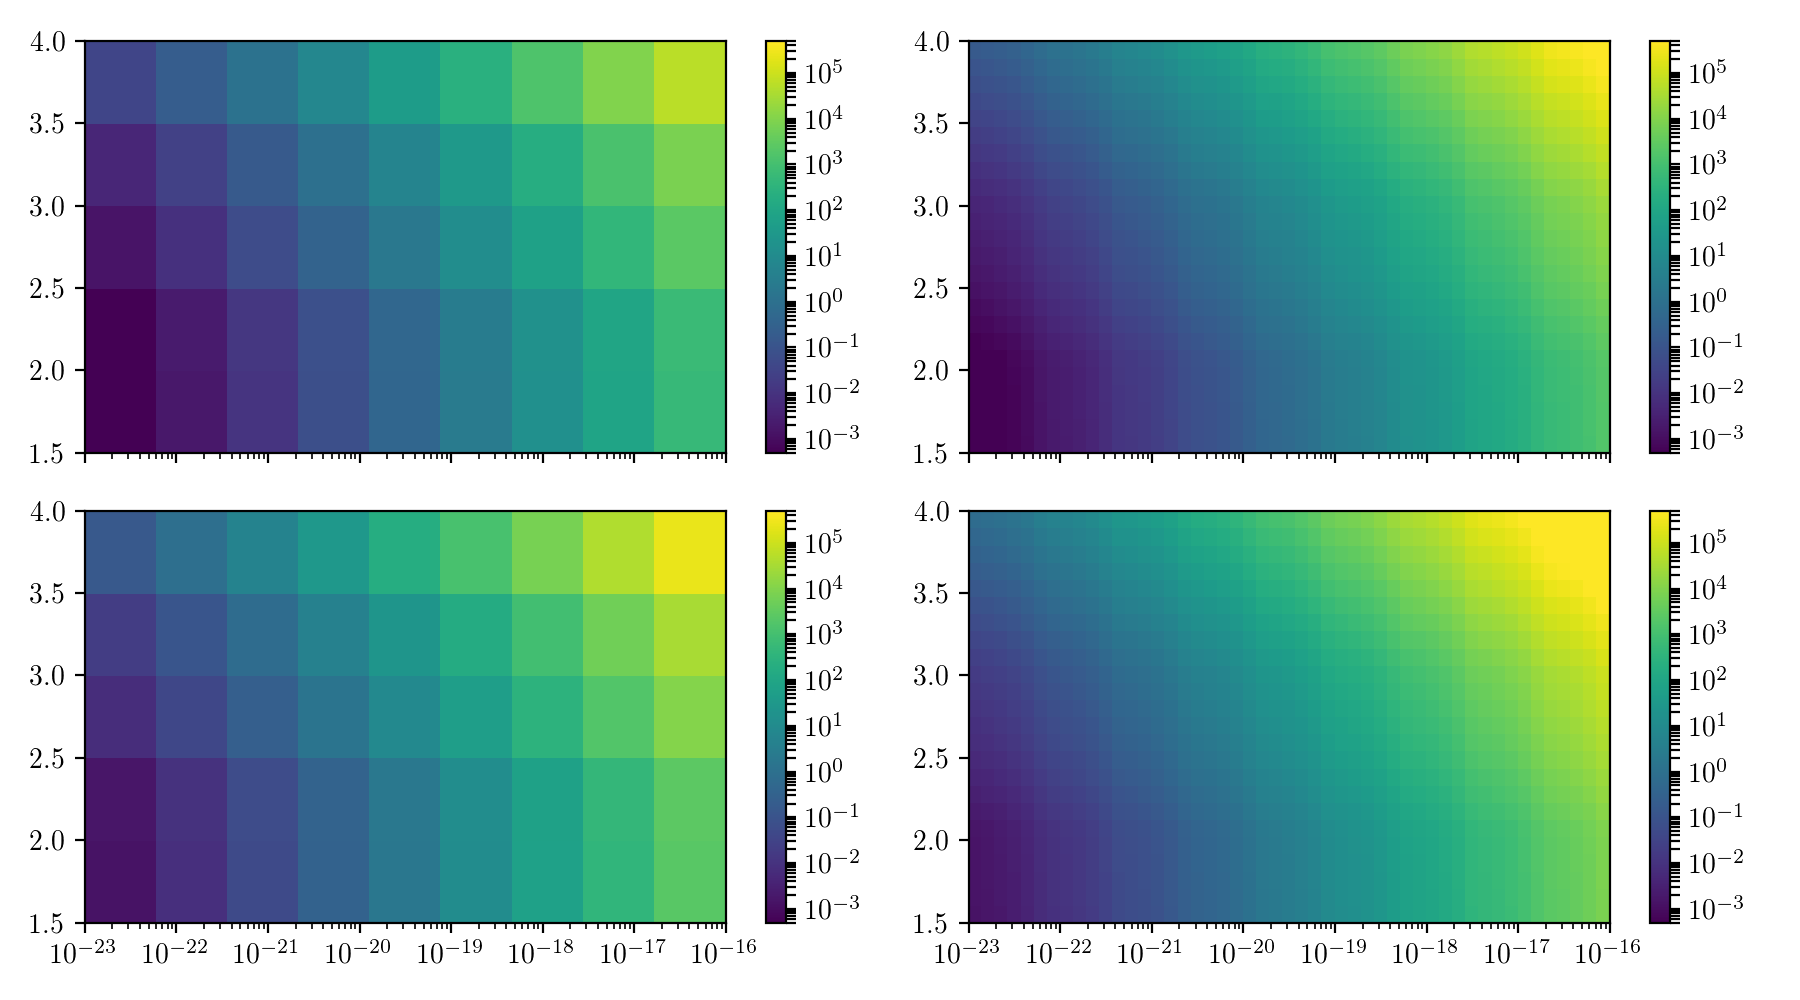

In [40]:
import scipy
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9,5), sharex=True)

Splines_cutoff = dict()

for k, exp in enumerate(['icecube', 'plenum']):
    
    F_template = copy(F_TEMPLATE_cutoff[exp])
    F_template[F_template==0] = 1e-15

    binmids = (phi100s, gammas, cutoffs, ereco_mids)
    spline_co = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(F_template),
                    method="linear",
                    bounds_error=False,
                    fill_value=-15,
                    )

    Splines_cutoff[exp] = spline_co
    ax = axes[k,0]
    p = ax.pcolormesh(phi100s, gammas, F_template[...,1,15].T, norm=LogNorm(), 
                      vmax=5e5,vmin=5e-4)
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')

    ax = axes[k,1]
    _phis = 10**np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 50 )

    _gs = np.linspace(np.min(gammas), np.max(gammas), 25)
    xx, yy = np.meshgrid(_phis, _gs, indexing='ij')
    spline_res = np.exp(spline_co((xx,yy, cutoffs[1], ereco_mids[15])))


    p = ax.pcolormesh(_phis, _gs, spline_res.T, norm=LogNorm(),  vmax=5e5,vmin=5e-4)
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')

fig.tight_layout()

---
# define a test statistic function based on poisson statistics 
---

In [41]:
def conv_func(log10_phi100, gamma, spline):
    _phi100 = np.atleast_1d(10**log10_phi100)
    gamma = np.atleast_1d(gamma)
    return np.exp(spline((_phi100, gamma, ereco_mids[:,np.newaxis]))).T


def conv_func_broken_pl(log10_phi100, gamma0, gamma1, spline):
    _phi100 = np.atleast_1d(10**log10_phi100)
    gamma0 = np.atleast_1d(gamma0)
    gamma1 = np.atleast_1d(gamma1)    
    return np.exp(spline((_phi100, gamma0, gamma1, ereco_mids[:,np.newaxis]))).T

def conv_func_cutoff(log10_phi100, gamma0, coff, spline):
    _phi100 = np.atleast_1d(10**log10_phi100)
    gamma0 = np.atleast_1d(gamma0)
    coff = np.atleast_1d(coff)    
    return np.exp(spline((_phi100, gamma0, coff, ereco_mids[:,np.newaxis]))).T

In [42]:
rand = np.random.RandomState(0)
def generate_bckg_data(lambda_b, n_trials):
    out = rand.poisson(lambda_b, size=(n_trials, len(lambda_b)))
    return out
    
def generate_signal_data(log10_phi100, gamma, n_trials, spline):
    lambda_s = conv_func(log10_phi100, gamma, spline)[0]
    out = rand.poisson(lambda_s, size=(n_trials, len(lambda_s)))
    return out

def generate_signal_data_broken(log10_phi100, gamma0, gamma1, n_trials, spline):
    lambda_s = conv_func_broken_pl(log10_phi100, gamma0, gamma1, spline)[0]
    out = rand.poisson(lambda_s, size=(n_trials, len(lambda_s)))
    return out

def generate_signal_data_cutoff(log10_phi100, gamma0, coff, n_trials, spline):
    lambda_s = conv_func_cutoff(log10_phi100, gamma0, coff, spline)[0]
    out = rand.poisson(lambda_s, size=(n_trials, len(lambda_s)))
    return out


# I fill define the TS for both scenarios (single and broken power-law) separately. 
in order to compare them we can just take the difference between both TS values

In [43]:
def LambdaTS(log10_phi100, gamma, data, lambda_b, spline):
    r'''
    phi100: flux normalisation at 100TeV of the singal
    gamma: spectral index of the singal
    data: observed number of events in each energy bin
    lambda_b: expected number of background events in each bin
    '''
    
    lambda_s = conv_func(log10_phi100, gamma, spline)
    r = lambda_s / lambda_b #background expectation should not be 0
    
    _mask = (np.ones_like(lambda_s)*lambda_b) == 0
    r[_mask] = 0
    res = 2 * np.sum(np.log(1+r) * data[:,np.newaxis] - lambda_s, axis=2)
    return res


def LambdaTS_broken(log10_phi100, gamma0, gamma1, data, lambda_b, spline):
    r'''
    phi100: flux normalisation at 100TeV of the singal
    gamma: spectral index of the singal
    data: observed number of events in each energy bin
    lambda_b: expected number of background events in each bin
    '''
    
    lambda_s = conv_func_broken_pl(log10_phi100, gamma0, gamma1, spline)
    r = lambda_s / lambda_b #background expectation should not be 0
    
    _mask = (np.ones_like(lambda_s)*lambda_b) == 0
    r[_mask] = 0
    res = 2 * np.sum(np.log(1+r) * data[:,np.newaxis] - lambda_s, axis=2)
    return res


def LambdaTS_cutoff(log10_phi100, gamma0, coff, data, lambda_b, spline):
    r'''
    phi100: flux normalisation at 100TeV of the singal
    gamma: spectral index of the singal
    data: observed number of events in each energy bin
    lambda_b: expected number of background events in each bin
    '''
    
    lambda_s = conv_func_cutoff(log10_phi100, gamma0, coff, spline)
    r = lambda_s / lambda_b #background expectation should not be 0 
    _mask = (np.ones_like(lambda_s)*lambda_b) == 0
    r[_mask] = 0
    res = 2 * np.sum(np.log(1+r) * data[:,np.newaxis] - lambda_s, axis=2)
    return res

# Do trialscfor both hypothesis
we have to calculate trials in bunches of 1e4 otherwise the matrix gets too big

In [44]:
import time

# check if we can recover the physics parameters 

In [45]:
def add_diffuse_10years(ax , color='red', label=r'Astro. $\nu_{\mu}+\bar{\nu}_{\mu}$', E='GeV'):
    #########################
    #   add diffuse flux from northern hemisphere (10 year result)
    # https://arxiv.org/pdf/1908.09551.pdf
    ########################

    phi = 1.44e-18 #*3 #[GeV^(-1)/cm^2/s/sr] fixed at 100TeV
    phi_low = (1.44-0.24)*1.e-18 #*3
    phi_up = (1.44+0.25)*1.e-18 #*3
    y = 2.28
    y_low =  2.28 - 0.09
    y_up = 2.28 + 0.08


    Emin_diff, Emax_diff = 40e3, 3.5e6
    E_bins = 10**np.linspace(np.log10(Emin_diff),np.log10(Emax_diff),num=100)
    diff = phi * 10**(5*y) * E_bins**(2-y)
    diff_low = np.copy(diff)
    diff_up = np.copy(diff)
    for yi in np.linspace(y_low, y_up, 50):
        di_low = phi_low * 10**(5*yi) * E_bins**(2-yi)
        di_up = phi_up * 10**(5*yi) * E_bins**(2-yi)
        ml = di_low < diff_low
        diff_low[ml] = di_low[ml]
        mu = di_up > diff_up
        diff_up[mu] = di_up[mu]

    if E != 'TeV':
        ax.fill_between(E_bins, diff_low, diff_up, color=color, alpha=0.5,label=label)
        ax.plot(E_bins,diff,color=color,linestyle='--')
        
    else:
        ax.fill_between(E_bins*1e-3, diff_low, diff_up, color=color, alpha=0.5,label=label)
        ax.plot(E_bins*1e-3,diff,color=color,linestyle='--')
        
    return

def add_hese(ax, label='HESE unfolding', **kwargs):
    hese = np.genfromtxt('/Users/mhuber/Documents/IceCubeData/3FHL/HESE_bestFitPoints_ICRC2017.csv',
                    delimiter=',')
    hesepath = '/Users/mhuber/Documents/IceCubeData/3FHL/'
    hese_x = hese[:,0] 
    hese_y = hese[:,1] 
    #x in GeV
    xerrminus = np.genfromtxt(os.path.join(hesepath,'HESE_lxPoints_ICRC2017.csv'),
                        delimiter=',')[:,0] 
    xerrplus = np.genfromtxt(os.path.join(hesepath,'HESE_rxPoints_ICRC2017.csv'),
                        delimiter=',')[:,0] 

    yerrminus = np.genfromtxt(os.path.join(hesepath,'HESE_lyPoints_ICRC2017.csv'),
                        delimiter=',')[:,1] 
    yerrplus = np.genfromtxt(os.path.join(hesepath,'HESE_uyPoints_ICRC2017.csv'),
                        delimiter=',')[:,1] 

    ax.errorbar(hese_x, hese_y, xerr=[hese_x-xerrminus, xerrplus-hese_x],
                yerr=[hese_y-yerrminus, yerrplus-hese_y],
               linestyle='None', color='black', label=label, **kwargs)

    mask = np.array([0,0,0,1,0,0,1],dtype=bool)
    ax.errorbar(hese_x[mask], hese_y[mask], xerr=[(hese_x-xerrminus)[mask], (xerrplus-hese_x)[mask]], 
               uplims=True,
                yerr=[(hese_y-yerrminus)[mask], (yerrplus-hese_y)[mask]],
               linestyle='None', color='black', **kwargs)
    
    return


# Now we want to test some scenarios in order to check wether we can distinguish a lower power law contribution from the high energy astro part

In [46]:
phi_inj = 1.44e-18
g_inj1 = 2.28#2.3
# we will fix the high energy part to the diffuse results 
# and fix phi0 such that it't always the same at 500TeV

g_inj0s = np.arange(2.5,2.85,0.05) #[2.4,2.5,2.6,2.7]
PHI_injs = dict()
for ek, E_threshold in enumerate(E_thresholds):
    PHI_injs[ek] = [(phi_inj*5**(-2.28)) / (5**(-g_inji)+ 5**(-g_inj1) * (E_threshold/1.0e5)**(g_inj1 - g_inji)) 
            for g_inji in g_inj0s]

<IPython.core.display.Javascript object>


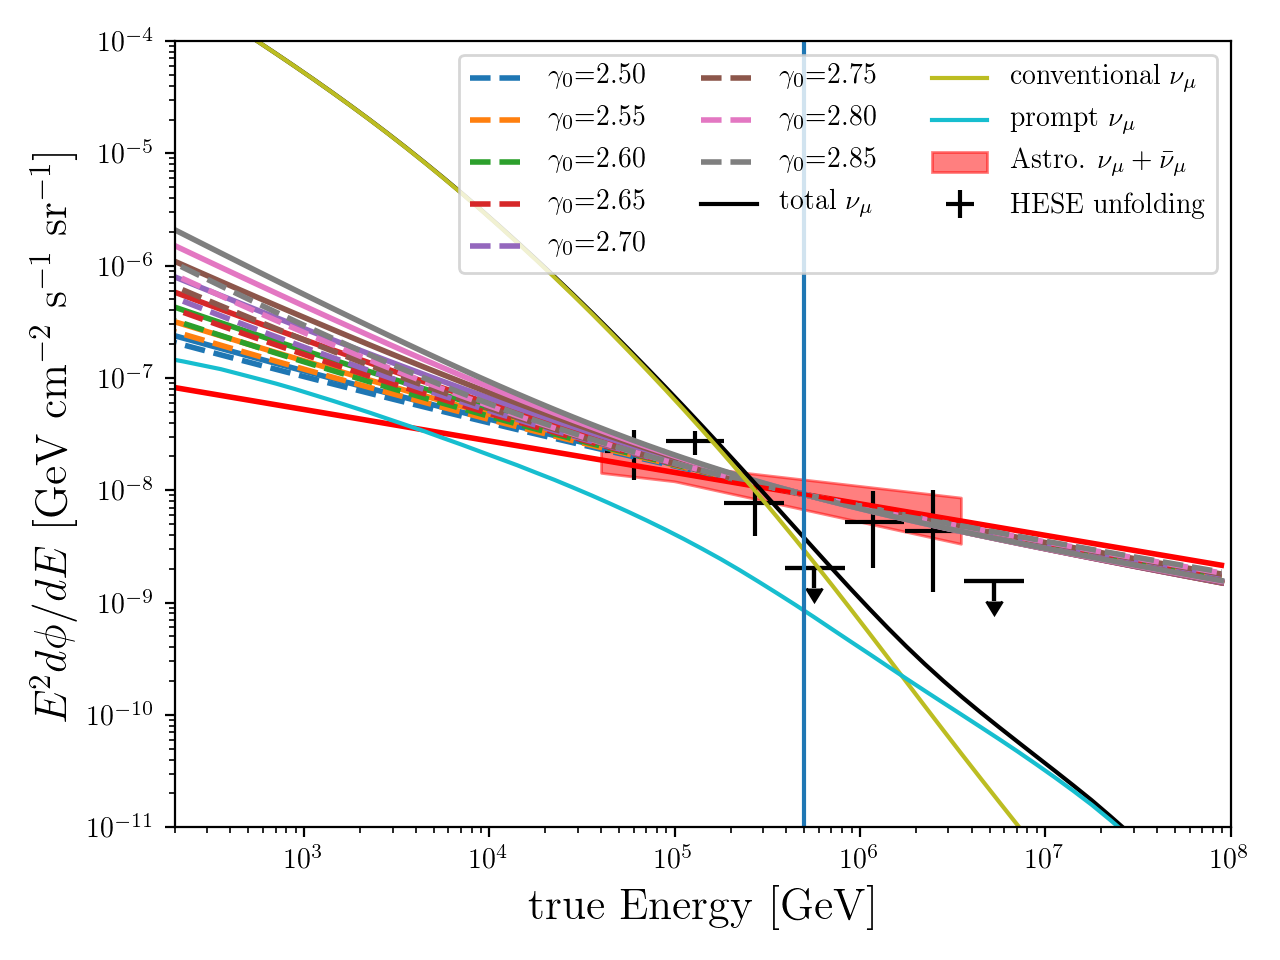

2.5
2.55
2.5999999999999996
2.6499999999999995
2.6999999999999993
2.749999999999999
2.799999999999999
2.8499999999999988


In [61]:
# show the spectrum compared to the diffuse
fig, ax = plt.subplots()

ax.plot(etrue_mids, etrue_mids**2 * 1.44e-18 * (etrue_mids/1e5)**(-2.28), c='red',lw=2)
for g_inji in g_inj0s:
    print(g_inji)
    E_thi = E_thresholds[0]
    phi_inji = (phi_inj*5**(-2.28)) / (5**(-g_inji)+ 5**(-g_inj1) * (E_thi/1.0e5)**(g_inj1 - g_inji))
    p=ax.plot(etrue_mids, etrue_mids**2 *broken_power_law(etrue_mids, phi_inji, g_inji, g_inj1, E_th=E_thi), 
       lw=2, ls='dashed', label='$\gamma_0$={0:.2f}'.format(g_inji))
    E_thi = E_thresholds[1]
    phi_inji = (phi_inj*5**(-2.28)) / (5**(-g_inji)+ 5**(-g_inj1) * (E_thi/1.0e5)**(g_inj1 - g_inji))
    ax.plot(etrue_mids, etrue_mids**2 *broken_power_law(etrue_mids, phi_inji, g_inji, g_inj1, E_th=E_thi), 
       lw=2, ls='solid', color=p[0].get_color())
add_diffuse_10years(ax)
add_hese(ax)


for i,(pref, lab) in enumerate([('numu_',r'\nu_\mu')]):
    
    p0 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'total'], color='k', ls='solid', lw=1.5,
                  label=r'total ${0}$'.format(lab))
    p1 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'conv'],  ls='solid', lw=1.5,
               label=r'conventional ${0}$'.format(lab))
    p2 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'pr'], ls='solid', lw=1.5, 
               label='prompt ${0}$'.format(lab))

ax.set_xlim(2e2, 1e8)
ax.set_ylim(1e-11,1e-4)

ax.legend(ncol=3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('true Energy [GeV]', fontsize=fs)
ax.set_ylabel(r'$E^2 d\phi/dE$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]', fontsize=fs)

ax.axvline(5e5)
fig.tight_layout()
fig.savefig('plots/diffuse_analysis_broken_pl_illustration.pdf')

<IPython.core.display.Javascript object>


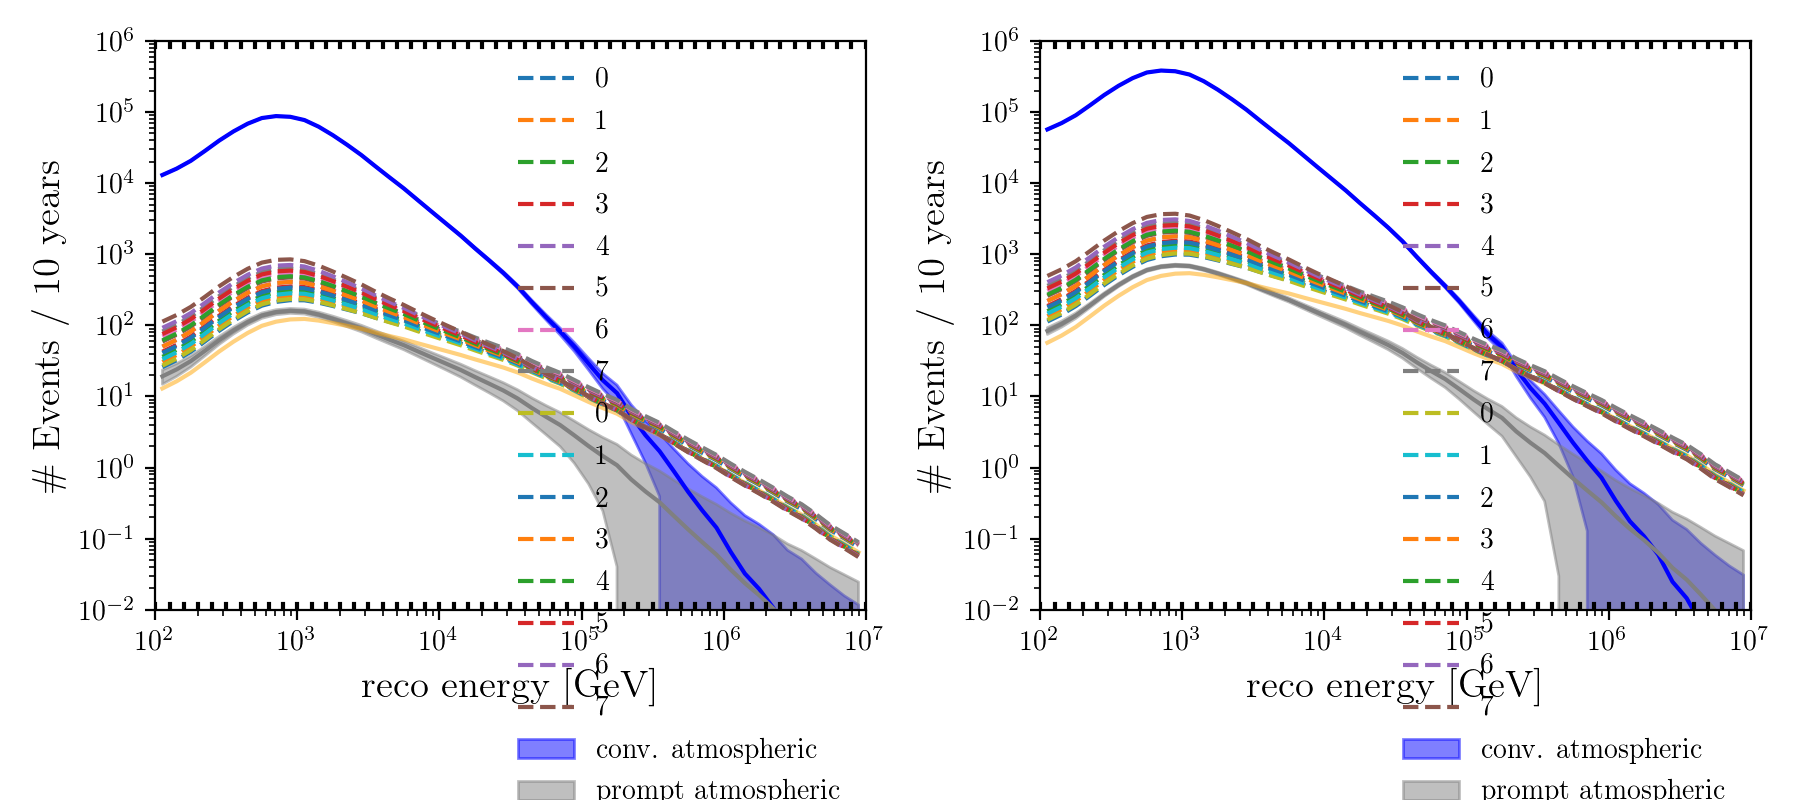

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))



for k, exp in enumerate(['icecube', 'plenum']):

    ax = axes[k]
    Bckg_vals = Background_values_reco[exp]
    Bckg_vals_pr = Background_values_prompt_reco[exp]
    

    Bckg_vals[Bckg_vals<=0] = 0
    yerr=np.sqrt(Bckg_vals)
    ax.plot(ereco_mids, Bckg_vals, color='blue')
    ax.fill_between(ereco_mids, Bckg_vals-yerr, Bckg_vals+yerr, alpha=0.5, color='blue',
                   label = r'conv. atmospheric')

    Bckg_vals_pr[Bckg_vals_pr<=0] = 0
    yerr=np.sqrt(Bckg_vals_pr)
    ax.plot(ereco_mids, Bckg_vals_pr, color='grey')
    ax.fill_between(ereco_mids, Bckg_vals_pr-yerr, Bckg_vals_pr+yerr, alpha=0.5, color='grey',
                   label = r'prompt atmospheric')

    # add all possible outcomes to the final plot jus to see if the calculation of F makes sense
    spline = Splines[exp]
    lambda_s = conv_func(np.log10(1.44e-18), 2.28, spline)[0]
    ax.plot(ereco_mids, lambda_s, color='orange', alpha=0.5)
    
    for ek, E_threshold in enumerate(E_thresholds):
        spline_br = Splines_broken[exp][ek]
        for gi, g_inji in enumerate(g_inj0s):
            phi_inji = PHI_injs[ek][gi]
            lambda_s2 = conv_func_broken_pl(np.log10(phi_inji), g_inji, g_inj1, spline_br)[0]
            ax.plot(ereco_mids, lambda_s2,  ls='dashed', label=str(gi))
    
    # indicate the binning in energy
    for ei in ereco_bins:
        ax.axvline(ei, ymin=0, ymax=0.01, color='black')
        ax.axvline(ei, ymin=0.99, ymax=1, color='black')


    ax.set_xlim(1e2,1e7)
    ax.set_ylim(1e-2,1.e6)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel('reco energy [GeV]', fontsize=14)
    ax.set_ylabel(r'\# Events / 10 years', fontsize=14)
    ax.legend(loc='upper right', frameon=False)

    

fig.tight_layout()

# Now check how well we can distinguish between the two spectral shapes

get the background distribution first 

# Now move to a minimizer instead of using a grid scan

In [49]:
from iminuit import Minuit 
def max_LambdaTS(data, lambda_b, spline,initials=None, **kwargs):
    r'''
    data: observed number of events in each energy bin
    lambda_b: expected number of background events in each bin
    '''
    def func(*args):
        log10_phi100, gamma = args
        #print(log10_phi100)
        lambda_s = conv_func(log10_phi100, gamma, spline)[0]
        r = lambda_s / lambda_b #background expectation should not be 0
    
        _mask = (np.ones_like(lambda_s)*lambda_b) == 0
        r[_mask] = 0
        res = 2 * np.sum(np.log(1+r) * data - lambda_s)
        return -res
        
    if initials is None:
        initials = [np.log10(phi100s[5]), 2.5]
    #print(initials)
    
    bounds = [(np.log10(phi100s[0])+0.2, np.log10(phi100s[-1]) -0.2 ),
              (gammas[0]+0.2, gammas[-1]-0.2)]

    #set initial values for the fitting parameters
    p_names = ['p{}'.format(_) for _ in range(len(initials))]
    fit_arg = dict(zip(p_names, initials))

    p_bounds = ['limit_p{}'.format(_) for _ in range(len(initials))]
    pbounds = [bounds[i] for i in range(len(p_bounds))]
    fit_arg.update(dict(zip(p_bounds, pbounds)))

    fit_min = Minuit(fcn=func,
                    forced_parameters=p_names,
                    pedantic=False,
                    print_level=0,
                    **fit_arg)

    fit_min.migrad(resume=False)
    ncalls = fit_min.ncalls
    for l in range(50):
        r = fit_min.migrad(resume=True)
        ncalls += fit_min.ncalls
        if r[0]['has_valid_parameters']:
            break

    xmin = fit_min.args
    fmin = fit_min.fval

    status = dict()
    status['warnflag'] = 0
    status['nit'] = ncalls

    return (xmin, fmin, status)
    


def max_LambdaTS_broken(data, lambda_b, spline, initials=None, **kwargs):
    r'''
    data: observed number of events in each energy bin
    lambda_b: expected number of background events in each bin
    '''
    def func(*args):
        log10_phi100, gamma0, gamma1 = args
        #print(log10_phi100)
        
        #if gamma1 > gamma0:
        #    return 0
        
        lambda_s = conv_func_broken_pl(log10_phi100, gamma0, gamma1, spline)
        r = lambda_s / lambda_b #background expectation should not be 0
    
        _mask = (np.ones_like(lambda_s)*lambda_b) == 0
        r[_mask] = 0
        res = 2 * np.sum(np.log(1+r) * data - lambda_s)
        return -res
        
    
    if initials is None:
        initials = [np.log10(phi100s[5]), 2.5, 2.4]
    #print(initials)
    
    bounds = [(np.log10(phi100s[0])+0.1, np.log10(phi100s[-1])-0.1  ),
              (gammas[0]+0.1, gammas[-1]-0.1),
             (gammas[0]+0.1, gammas[-1]-0.1)]

    #set initial values for the fitting parameters
    p_names = ['p{}'.format(_) for _ in range(len(initials))]
    fit_arg = dict(zip(p_names, initials))

    p_bounds = ['limit_p{}'.format(_) for _ in range(len(initials))]
    pbounds = [bounds[i] for i in range(len(p_bounds))]
    fit_arg.update(dict(zip(p_bounds, pbounds)))

    fit_min = Minuit(fcn=func,
                    forced_parameters=p_names,
                    pedantic=False,
                    print_level=0,
                    **fit_arg)

    fit_min.migrad(resume=False)
    ncalls = fit_min.ncalls
    for l in range(50):
        r = fit_min.migrad(resume=True)
        ncalls += fit_min.ncalls
        if r[0]['has_valid_parameters']:
            break

    xmin = fit_min.args
    fmin = fit_min.fval

    status = dict()
    status['warnflag'] = 0
    status['nit'] = ncalls

    return (xmin, fmin, status)
    


# Background dist

In [50]:
N_trials = int(5e3)
n_trials =  int(50)

Bckg_Recover = dict()
Bckg_Recover_broken = dict()

#fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(9,5))

n_plot = 0
for k, exp in enumerate(['icecube', 'plenum']):
    
    n = 0
    start = time.clock()
    
    Res = {0:None,1:None}
    Res_single = None
    
    spline = Splines[exp]
    spline_br = Splines_broken[exp]
    start = time.clock()
    for _ in range(N_trials/n_trials):

        lambda_b = Background_values_reco[exp]
        _res = np.zeros((n_trials, ), dtype=[('ts', float), ('phi0',float), 
                                             ('gamma0',float), ('gamma1',float)])
        _res_single = np.zeros((n_trials, ), dtype=[('ts', float), ('phi0',float), 
                                             ('gamma',float)])


        # generate a signal from a broken power law
        d_bckg = generate_bckg_data(lambda_b=lambda_b, n_trials=n_trials)
        
        d_tot = d_bckg

        
        ##################################################################################
        # get the broken pl results
        ##################################################################################
        _phis = 10**np.linspace(np.log10(np.min(phi100s))+0.1, np.log10(np.max(phi100s))-0.1, 60 )
        _gs0 = np.linspace(np.min(gammas)+0.1, np.max(gammas)-0.1, 40)
        _gs1 = np.linspace(np.min(gammas)+0.1, np.max(gammas)-0.1, 40)

        xx, yy, zz = np.meshgrid(_phis, _gs0, _gs1, indexing='ij')
        
        
        for ek, E_threshold in enumerate(E_thresholds):
            llh_scan = LambdaTS_broken(np.log10(xx.flatten()), yy.flatten(),zz.flatten(), 
                                       d_tot, lambda_b ,spline_br[ek])


            llh_scan = llh_scan.reshape((n_trials,)+xx.shape)
            _mask = zz >= yy
            for si, _scan in enumerate(llh_scan):
                llh_scan[si][_mask] = -1.


            max_vals = np.max(llh_scan, axis=(1,2,3))
            max_vals[max_vals<0] = 0
            _res['ts'] = max_vals

            llh_scani = llh_scan[0]
            llh_scani[llh_scani<0] = 0

            llh_scan = llh_scan.reshape((n_trials,)+(len(xx.flatten()),))

            _m = np.argmax(llh_scan, axis=1)
            _res['phi0'] = xx.flatten()[_m]
            _res['gamma0'] = yy.flatten()[_m]
            _res['gamma1'] = zz.flatten()[_m]


            for ni in range(n_trials):
                _ints = [np.log10(_res['phi0'][ni]), _res['gamma0'][ni], _res['gamma1'][ni]]
                res_vals, res_ts, status = max_LambdaTS_broken(d_tot[ni], lambda_b, 
                                                               spline_br[ek], initials=_ints)
                res_ts = -res_ts
                if res_ts<0:
                    res_ts = 0

                if res_ts>=max_vals[ni]:
                    _res['ts'][ni] = res_ts
                    _res['phi0'][ni] = 10**res_vals[0]
                    _res['gamma0'][ni] = res_vals[1]
                    _res['gamma1'][ni] = res_vals[2]
                    n+=1
        
            if Res[ek] is None:
                Res[ek] = _res
            else:
                Res[ek] = np.append(Res[ek],_res)
                
            
        
        ##################################################################################
        # get the signle pl results
        ##################################################################################
        xx, yy = np.meshgrid(_phis, _gs0, indexing='ij')

        llh_scan = LambdaTS(np.log10(xx.flatten()), yy.flatten(), d_tot, lambda_b ,spline)
        llh_scan = llh_scan.reshape((n_trials,)+xx.shape)

        max_vals = np.max(llh_scan, axis=(1,2))
        max_vals[max_vals<0] = 0
        _res_single['ts'] = max_vals

        
        llh_scani = llh_scan[0]
        llh_scani[llh_scani<0] = 0
        
        
        
        llh_scan = llh_scan.reshape((n_trials,)+(len(xx.flatten()),))

        _m = np.argmax(llh_scan, axis=1)
        _res_single['phi0'] = xx.flatten()[_m]
        _res_single['gamma'] = yy.flatten()[_m]

        
        for ni in range(n_trials):
            _ints = [np.log10(_res_single['phi0'][ni]), _res_single['gamma'][ni]]
            res_vals, res_ts, status = max_LambdaTS(d_tot[ni], lambda_b, spline, initials=_ints)
            res_ts = -res_ts
            if res_ts<0:
                res_ts = 0
            
            
            if res_ts>=max_vals[ni]:
                #print('scan', max_vals[ni], np.log10(_res['phi0'][ni]), _res['gamma0'][ni], _res['gamma1'][ni])
                #print('minimizer',  res_ts, res_vals[0], res_vals[1], res_vals[2])
                #print(res_ts- max_vals[ni])
                
                _res_single['ts'][ni] = res_ts
                _res_single['phi0'][ni] = 10**res_vals[0]
                _res_single['gamma'][ni] = res_vals[1]
                n+=1
            
        
        if Res_single is None:
            Res_single = _res_single
        else:
            Res_single = np.append(Res_single, _res_single)
            
    
    

    
    Bckg_Recover_broken[exp] = Res
    Bckg_Recover[exp] = Res_single        
    stop = time.clock()
    mins, secs = divmod(stop-start,60)
    hours,mins = divmod(mins,60)
    print("{3} trials finished after {0:3d}h {1:2d}' {2:4.2f}''".format(int(hours),int(mins),secs, 
                                                                            (_+1)*n_trials))
        
    print(exp, n)

5000 trials finished after   0h 49' 50.86''
('icecube', 13861)
5000 trials finished after   0h 53' 15.97''
('plenum', 13854)


<IPython.core.display.Javascript object>


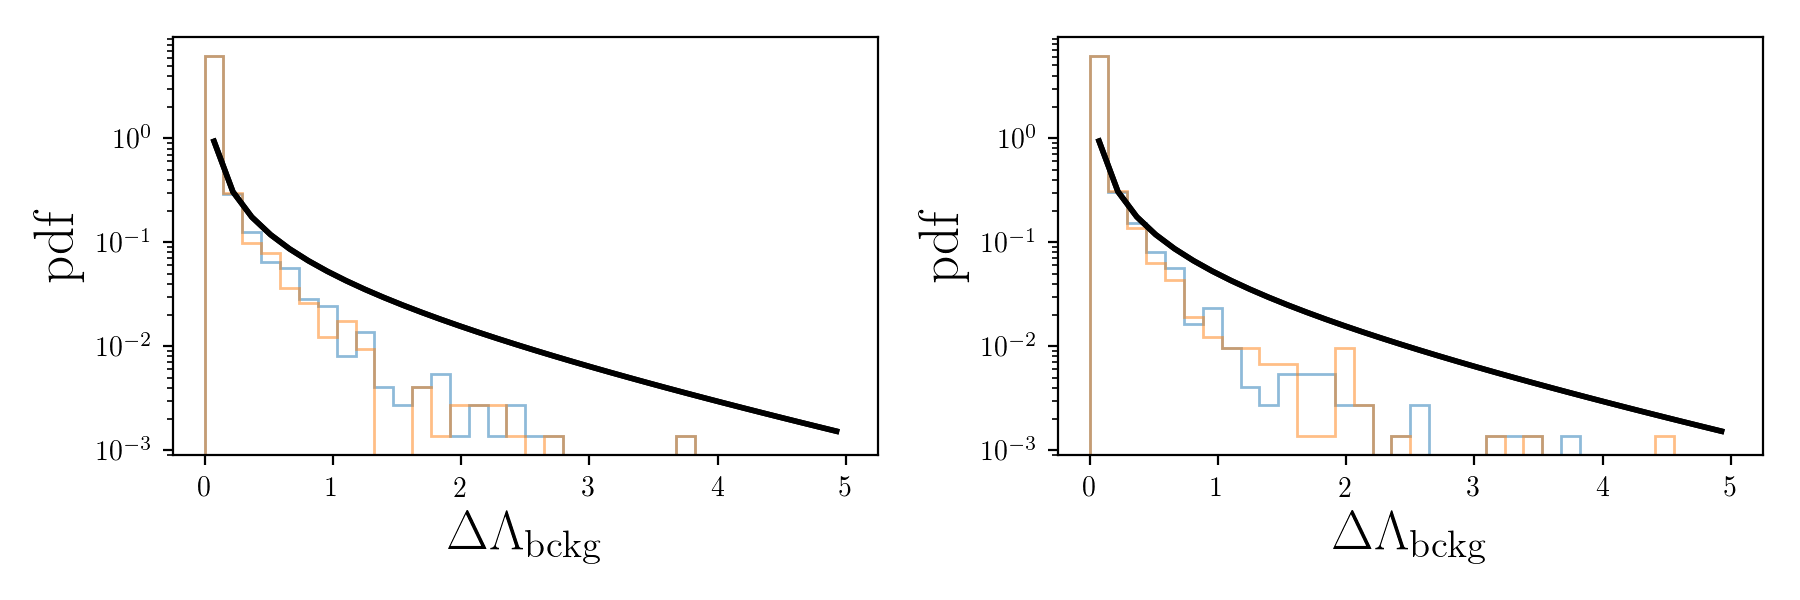

(0.4746, -0.9528637091799403)
(0.6952, 3.7642742441773995)
(0.4628, -0.862938748712045)
(0.6868, 3.69949942377377)
(0.4652, -1.218932938964187)
(0.7, 3.811754946348154)
(0.4468, -0.8733450894224895)
(0.6796, 4.432832301434836)


In [51]:
from scipy.stats import chi2
sys.path.append('/Users/mhuber/skylab/SVN_stable_v2-03/')
from _svnskylab.utils import FitDeltaChi2, delta_chi2

def fit_function(x,df,x0):
    x= np.atleast_1d(x)
    res = np.zeros_like(x)
    mask = x==0
    res[mask] = x0
    res[~mask] = (1-x0)*chi2.pdf(x[~mask], df)
    return res

def pval_function(x,df,x0):
    x= np.atleast_1d(x)
    res = np.zeros_like(x)
    mask = x == 0.
    print(mask)
    res[mask] = 1
    res[~mask] = 1-(x0+(1-x0)*chi2.cdf(x[~mask], df))
    return res
    

fig, axes = plt.subplots(ncols=2,  figsize=(9,3.), sharex='col')

for k, exp in enumerate(['icecube', 'plenum']):
    ax = axes[k]
    
    bins = np.linspace(0.,5, 35)
    
    for ek, E_threshold in enumerate(E_thresholds):
        
        res_ts = Bckg_Recover_broken[exp][ek]['ts'] - Bckg_Recover[exp]['ts']
        print(np.sum(res_ts<0)/float(len(res_ts)), np.min(res_ts))
        res_ts[res_ts<0] = 0
        print(np.sum(res_ts==0)/float(len(res_ts)), np.max(res_ts))
        h=ax.hist(res_ts , bins=bins, histtype='step', alpha=0.5, normed=True)
        
        
        
        xvals = get_mids(bins)
        fit_func = delta_chi2(eta=1-0.7, df=.1)
        fit_vals = fit_func.pdf(xvals)
        fit_vals[:] /= (np.sum(fit_vals) /(fit_func.eta))
        ax.plot(xvals, fit_vals / np.diff(xvals)[0] , color='black', lw=2., 
                label=r'$0.50\cdot \chi^2$(dof=2)')
        
    ax.set_yscale('log')
   
    ax.set_xlabel(r'$\Delta \Lambda_{\mathrm{bckg}}$', fontsize=fs)
    ax.set_ylabel(r'pdf', fontsize=fs)
    
fig.tight_layout()

In [ ]:
np.all(Bckg_Recover_broken[exp][0]['ts'] == Bckg_Recover_broken[exp][1]['ts'])

In [ ]:
print(PHI_injs)

# Signal injected stuff 

In [52]:
N_trials = int(300)
n_trials =  int(50)

RES_Recover = dict()
RES_Recover_broken = dict()

#fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(9,5))

n_plot = 0
for k, exp in enumerate(['icecube', 'plenum']):
    n = 0
    start = time.clock()
    print(exp)
    
    spline = Splines[exp]
    start = time.clock()
    RES_Recover[exp] = dict()
    RES_Recover_broken[exp] = dict()
    
    
    for ek, E_threshold in enumerate(E_thresholds):
        spline_br = Splines_broken[exp][ek]
        for gi, g_inji in enumerate(g_inj0s):
            print(ek,gi)
            phi_inji = PHI_injs[ek][gi]
            Res = None
            Res_single = None
            for _ in range(N_trials/n_trials):
                lambda_b = Background_values_reco[exp]
                _res = np.zeros((n_trials, ), dtype=[('ts', float), ('phi0',float), 
                                                     ('gamma0',float), ('gamma1',float)])
                _res_single = np.zeros((n_trials, ), dtype=[('ts', float), ('phi0',float), 
                                                     ('gamma',float)])


                # generate a signal from a broken power law
                d_bckg = generate_bckg_data(lambda_b=lambda_b, n_trials=n_trials)
                #d_sig = generate_signal_data(np.log10(phi_inj), g_inj, n_trials=n_trials, spline=spline)
                d_sig = generate_signal_data_broken(np.log10(phi_inji), g_inji, g_inj1, n_trials=n_trials, 
                                             spline=spline_br)

                d_tot = d_bckg+d_sig


                ##################################################################################
                # get the broken pl results
                ##################################################################################
                _phis = 10**np.linspace(np.log10(np.min(phi100s))+0.1, np.log10(np.max(phi100s))-0.1, 60 )
                _gs0 = np.linspace(np.min(gammas)+0.1, np.max(gammas)-0.1, 30)
                _gs1 = np.linspace(np.min(gammas)+0.1, np.max(gammas)-0.1, 30)

                xx, yy, zz = np.meshgrid(_phis, _gs0, _gs1, indexing='ij')

                llh_scan = LambdaTS_broken(np.log10(xx.flatten()), yy.flatten(),zz.flatten(), 
                                           d_tot, lambda_b ,spline_br)


                llh_scan = llh_scan.reshape((n_trials,)+xx.shape)
                _mask = zz >= yy
                for si, _scan in enumerate(llh_scan):
                    llh_scan[si][_mask] = -1.


                max_vals = np.max(llh_scan, axis=(1,2,3))
                max_vals[max_vals<0] = 0
                _res['ts'] = max_vals

                llh_scani = llh_scan[0]
                llh_scani[llh_scani<0] = 0

                llh_scan = llh_scan.reshape((n_trials,)+(len(xx.flatten()),))

                _m = np.argmax(llh_scan, axis=1)
                _res['phi0'] = xx.flatten()[_m]
                _res['gamma0'] = yy.flatten()[_m]
                _res['gamma1'] = zz.flatten()[_m]


                for ni in range(n_trials):
                    _ints = [np.log10(_res['phi0'][ni]), _res['gamma0'][ni], _res['gamma1'][ni]]
                    res_vals, res_ts, status = max_LambdaTS_broken(d_tot[ni], lambda_b, spline_br, initials=_ints)
                    res_ts = -res_ts
                    if res_ts<0:
                        res_ts = 0

                    if res_ts>=max_vals[ni]:
                        _res['ts'][ni] = res_ts
                        _res['phi0'][ni] = 10**res_vals[0]
                        _res['gamma0'][ni] = res_vals[1]
                        _res['gamma1'][ni] = res_vals[2]
                        n+=1
                    


                ##################################################################################
                # get the signle pl results
                ##################################################################################
                xx, yy = np.meshgrid(_phis, _gs0, indexing='ij')

                llh_scan = LambdaTS(np.log10(xx.flatten()), yy.flatten(), d_tot, lambda_b ,spline)
                llh_scan = llh_scan.reshape((n_trials,)+xx.shape)

                max_vals = np.max(llh_scan, axis=(1,2))
                max_vals[max_vals<0] = 0
                _res_single['ts'] = max_vals


                llh_scani = llh_scan[0]
                llh_scani[llh_scani<0] = 0



                llh_scan = llh_scan.reshape((n_trials,)+(len(xx.flatten()),))

                _m = np.argmax(llh_scan, axis=1)
                _res_single['phi0'] = xx.flatten()[_m]
                _res_single['gamma'] = yy.flatten()[_m]


                for ni in range(n_trials):
                    _ints = [np.log10(_res_single['phi0'][ni]), _res_single['gamma'][ni]]
                    res_vals, res_ts, status = max_LambdaTS(d_tot[ni], lambda_b, spline, initials=_ints)
                    res_ts = -res_ts
                    if res_ts<0:
                        res_ts = 0


                    if res_ts>=max_vals[ni]:
                        #print('scan', max_vals[ni], np.log10(_res['phi0'][ni]), _res['gamma0'][ni], _res['gamma1'][ni])
                        #print('minimizer',  res_ts, res_vals[0], res_vals[1], res_vals[2])
                        #print(res_ts- max_vals[ni])

                        _res_single['ts'][ni] = res_ts
                        _res_single['phi0'][ni] = 10**res_vals[0]
                        _res_single['gamma'][ni] = res_vals[1]
                        n+=1



                if Res is None:
                    Res = _res
                    Res_single = _res_single
                else:
                    Res = np.append(Res,_res)
                    Res_single = np.append(Res_single, _res_single)





            RES_Recover_broken[exp][(ek,gi)] = Res
            RES_Recover[exp][(ek,gi)] = Res_single        
    stop = time.clock()
    mins, secs = divmod(stop-start,60)
    hours,mins = divmod(mins,60)
    print("{3} trials finished after {0:3d}h {1:2d}' {2:4.2f}''".format(int(hours),int(mins),secs, 
                                                                            (_+1)*n_trials))

    print(exp, n)


icecube
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
300 trials finished after   0h 18' 5.47''
('icecube', 9600)
plenum
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
300 trials finished after   0h 17' 26.02''
('plenum', 9600)


(20000.0, 2.5)


<IPython.core.display.Javascript object>


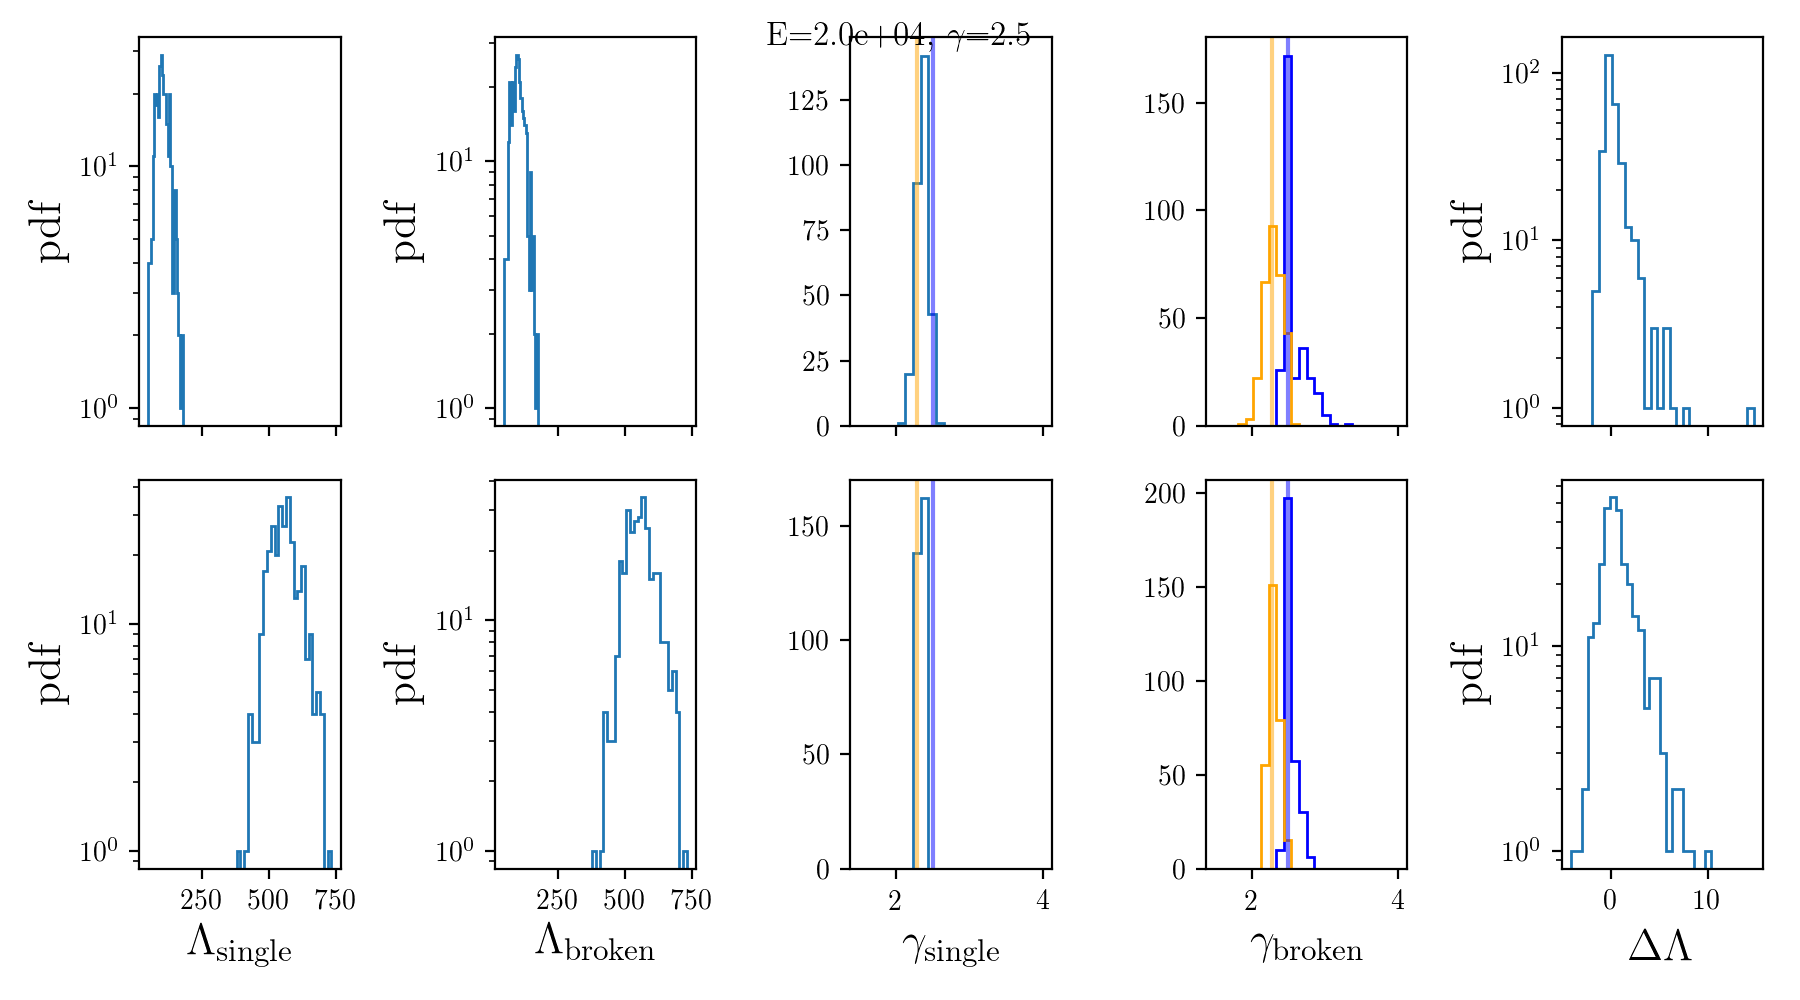

('icecube', 0.04611904148856638)
('plenum', 0.4814127526991001)
(20000.0, 2.55)


<IPython.core.display.Javascript object>


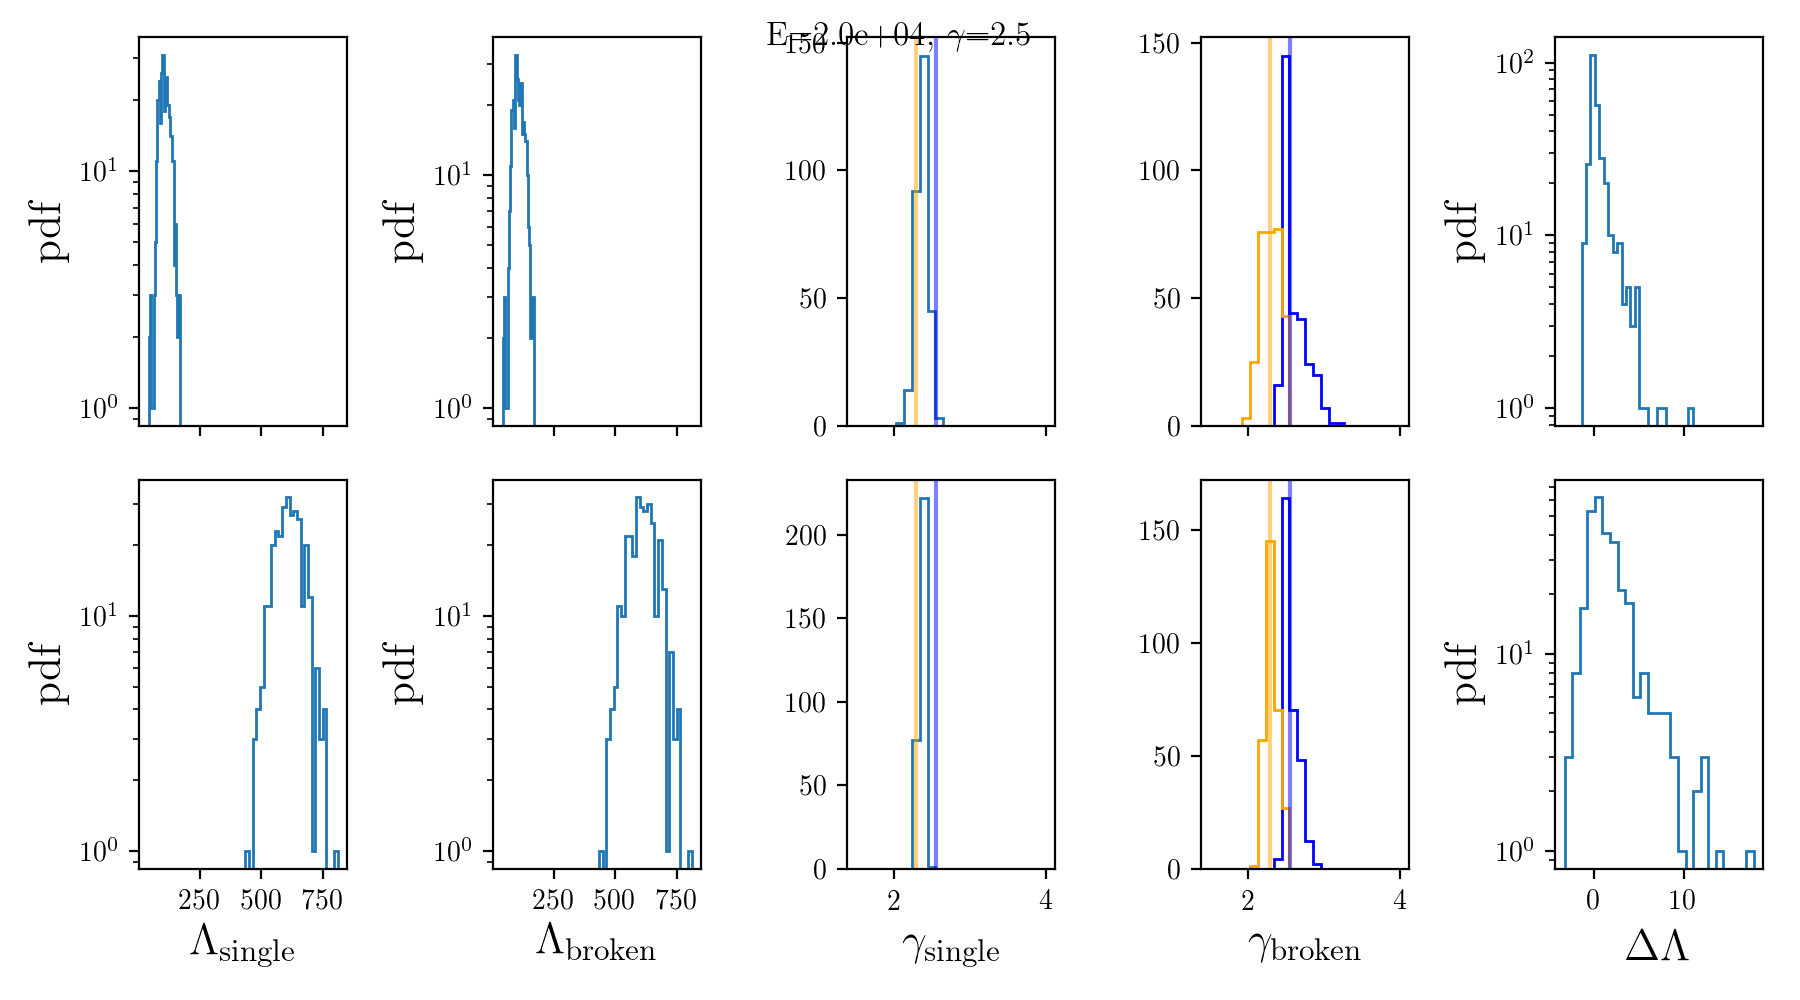

('icecube', 0.1669930341860848)
('plenum', 1.0733192890078271)
(20000.0, 2.5999999999999996)


<IPython.core.display.Javascript object>


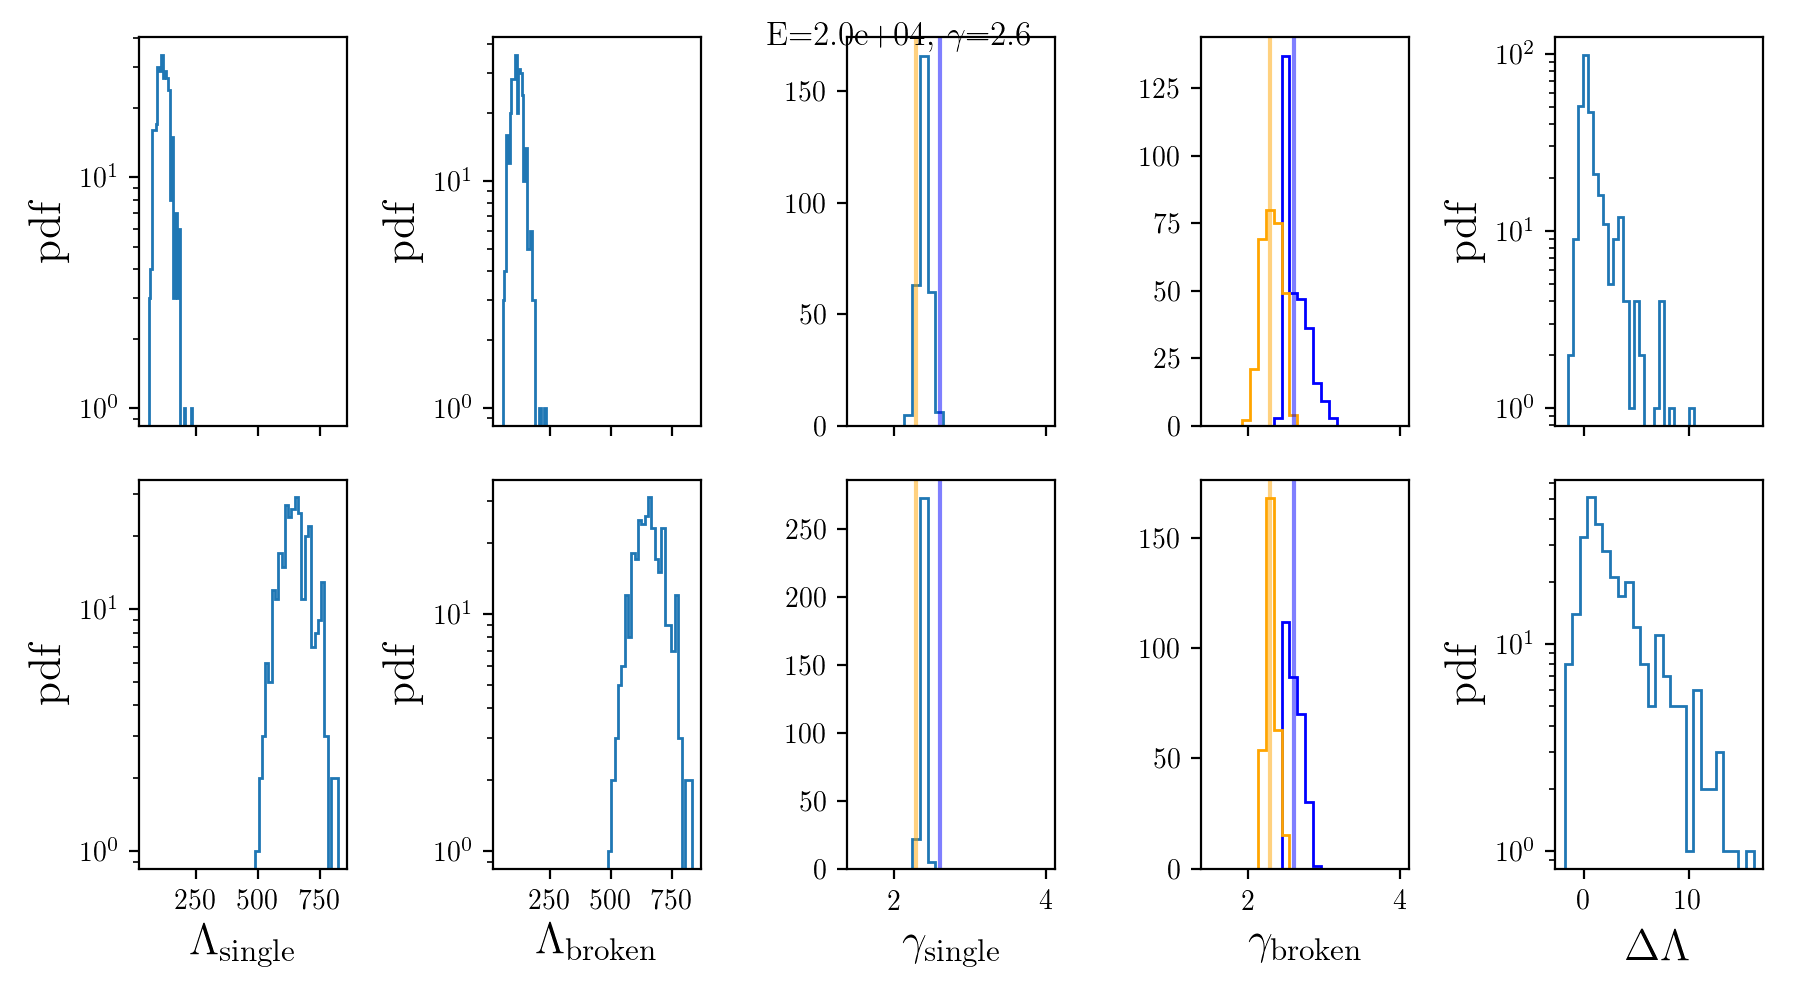

('icecube', 0.3155534051693323)
('plenum', 1.872538601442443)
(20000.0, 2.6499999999999995)


<IPython.core.display.Javascript object>


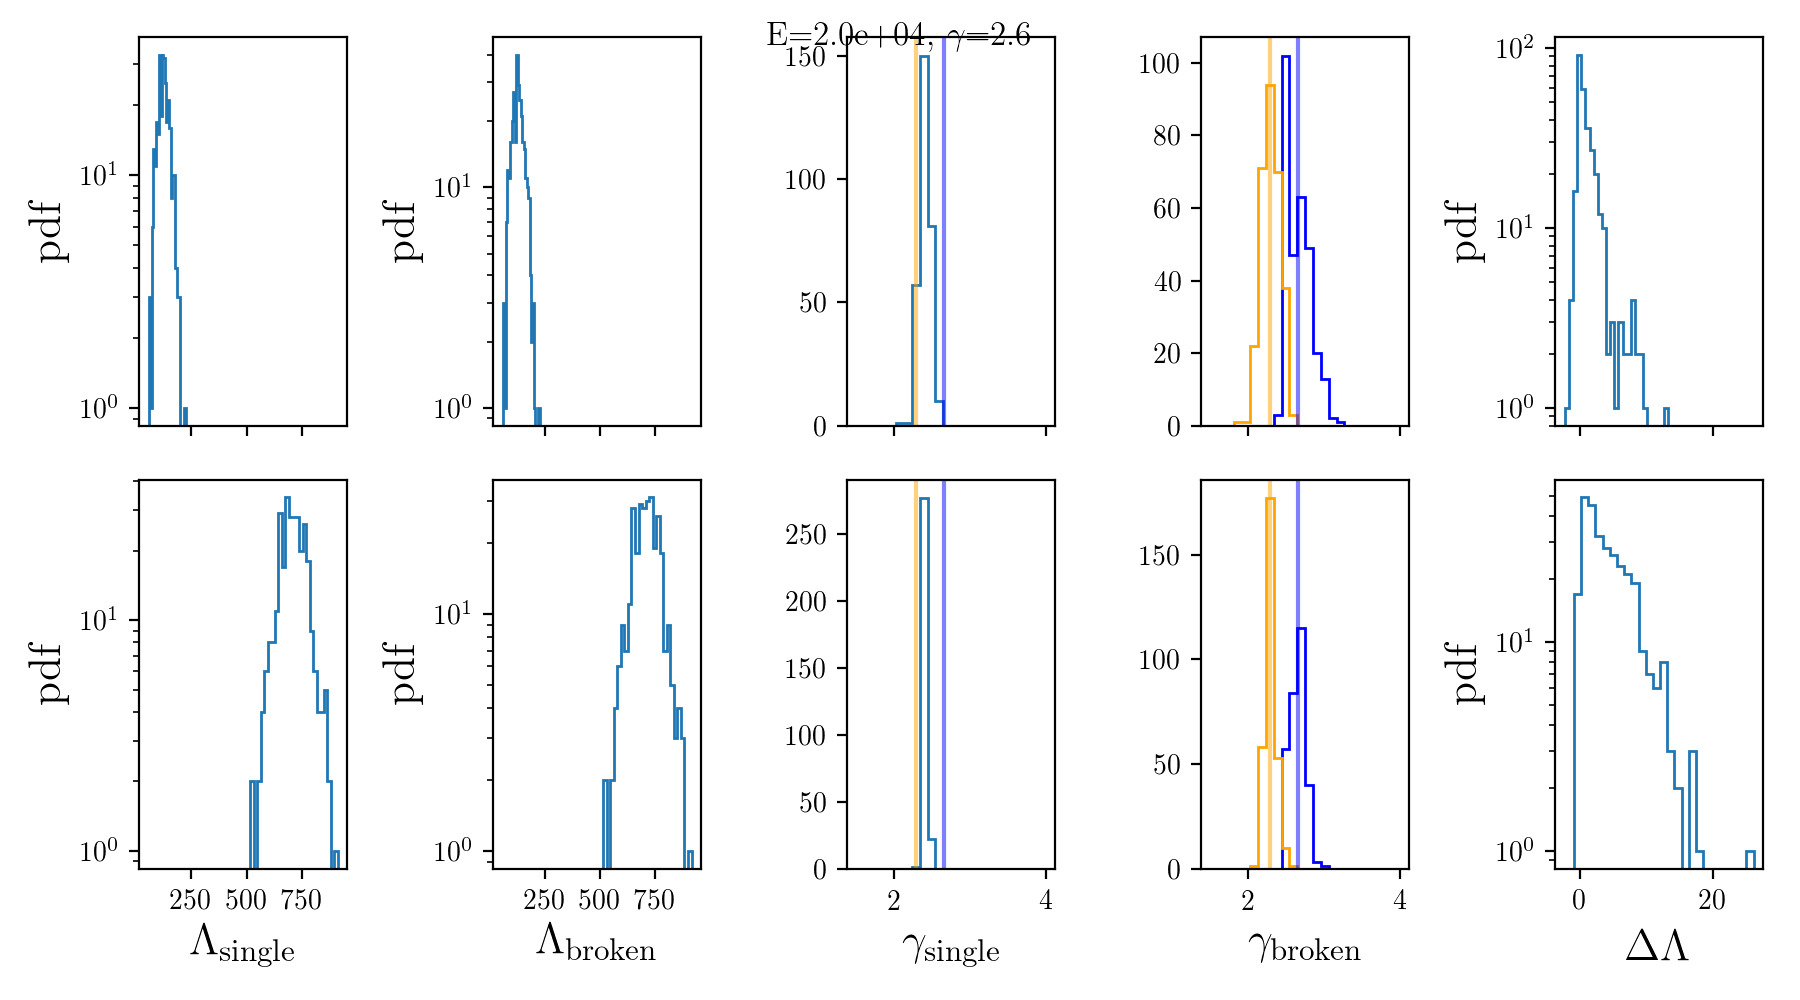

('icecube', 0.611715730530257)
('plenum', 3.8073340475662008)
(20000.0, 2.6999999999999993)


<IPython.core.display.Javascript object>


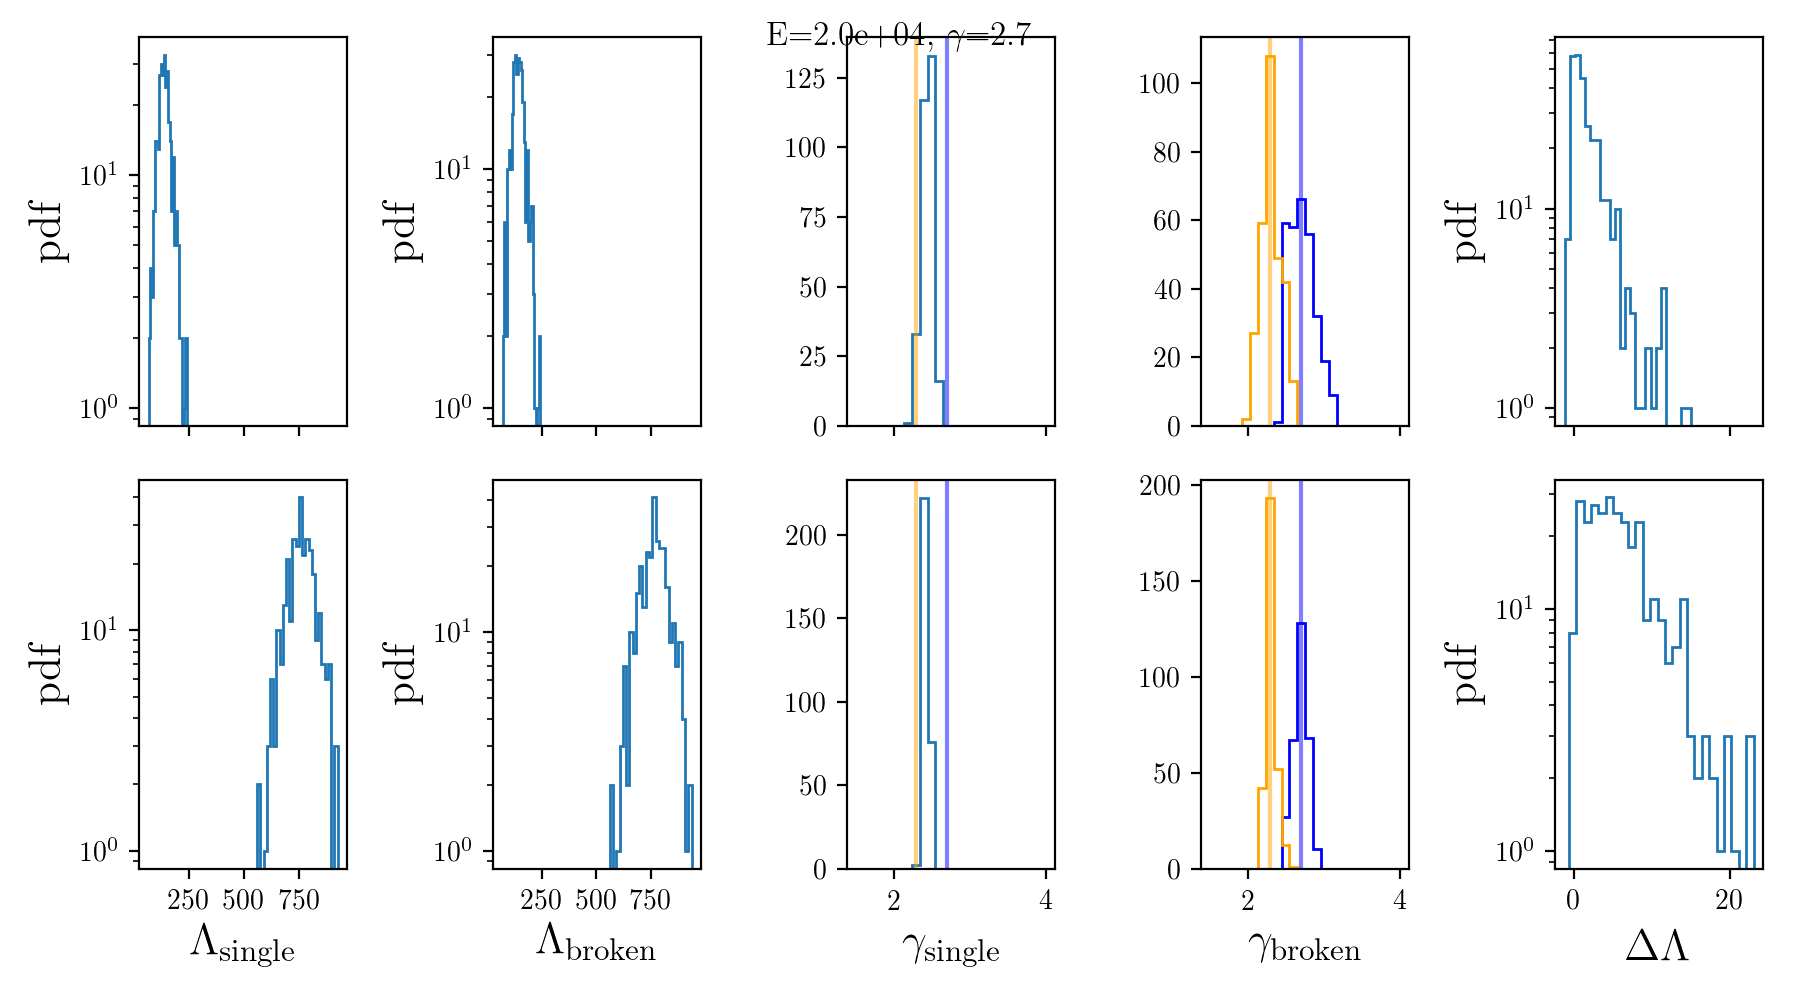

('icecube', 1.0748699592920374)
('plenum', 5.355247923465868)
(20000.0, 2.749999999999999)


<IPython.core.display.Javascript object>


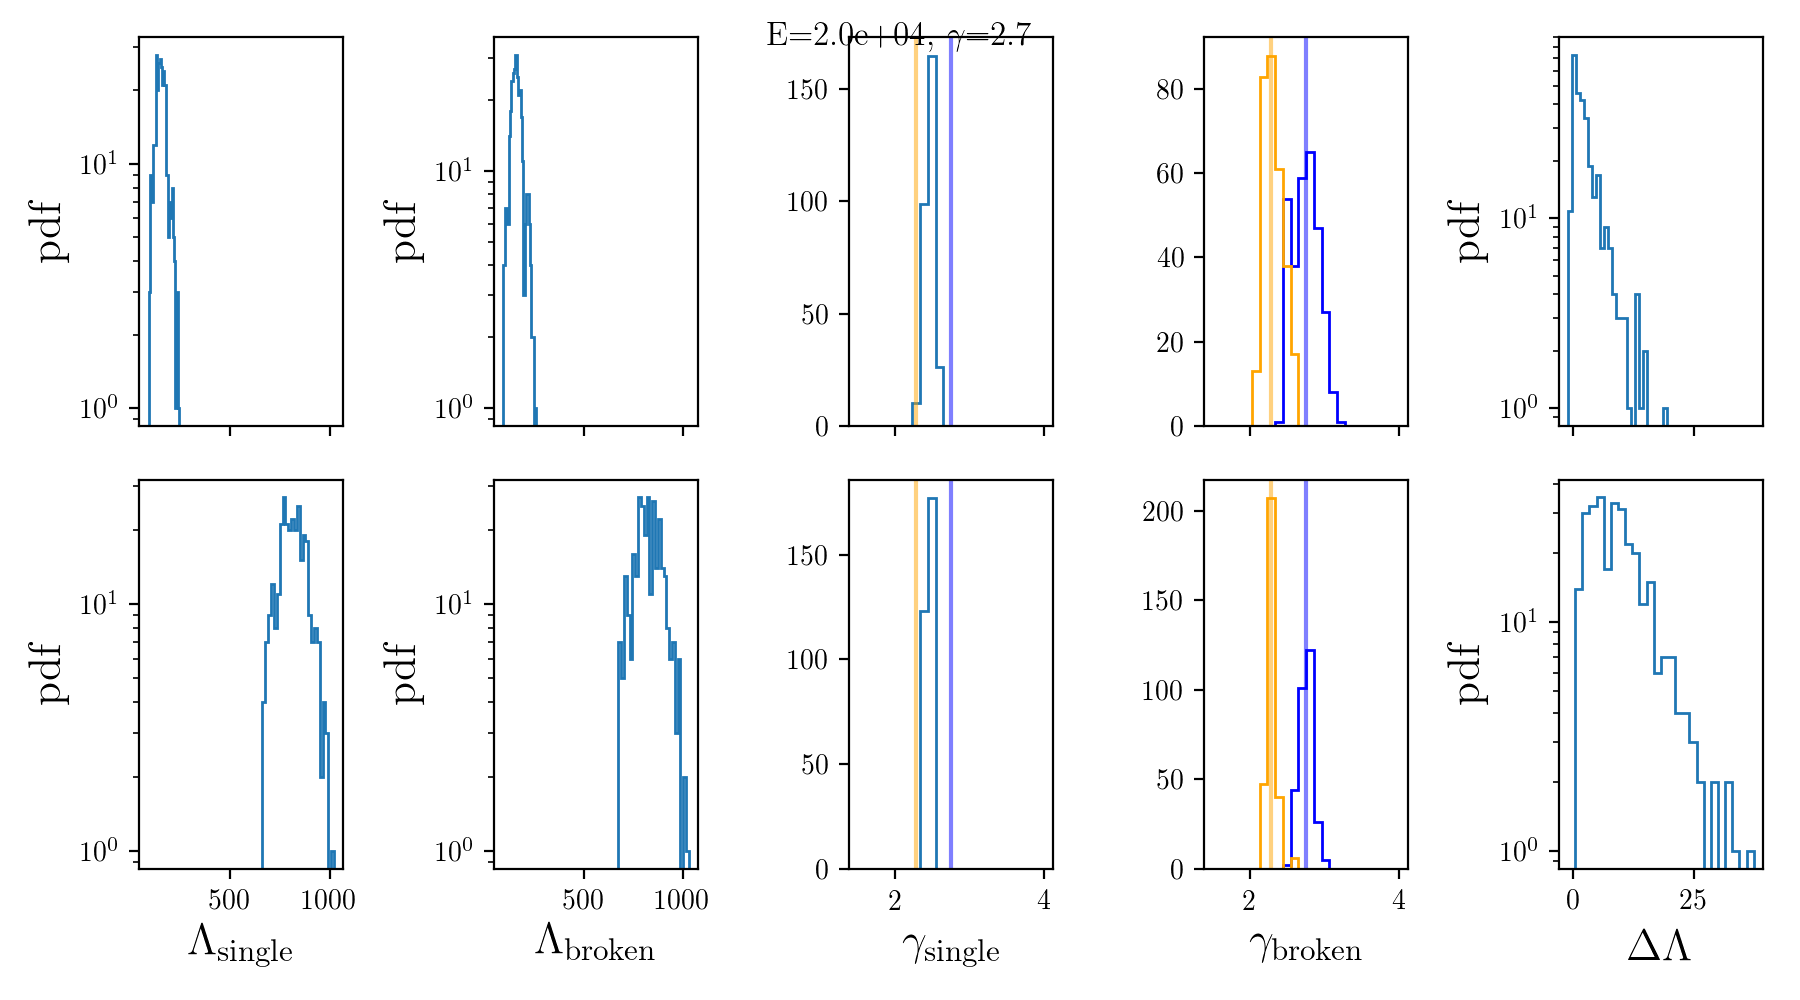

('icecube', 1.7790423244445819)
('plenum', 8.741475134240432)
(20000.0, 2.799999999999999)


<IPython.core.display.Javascript object>


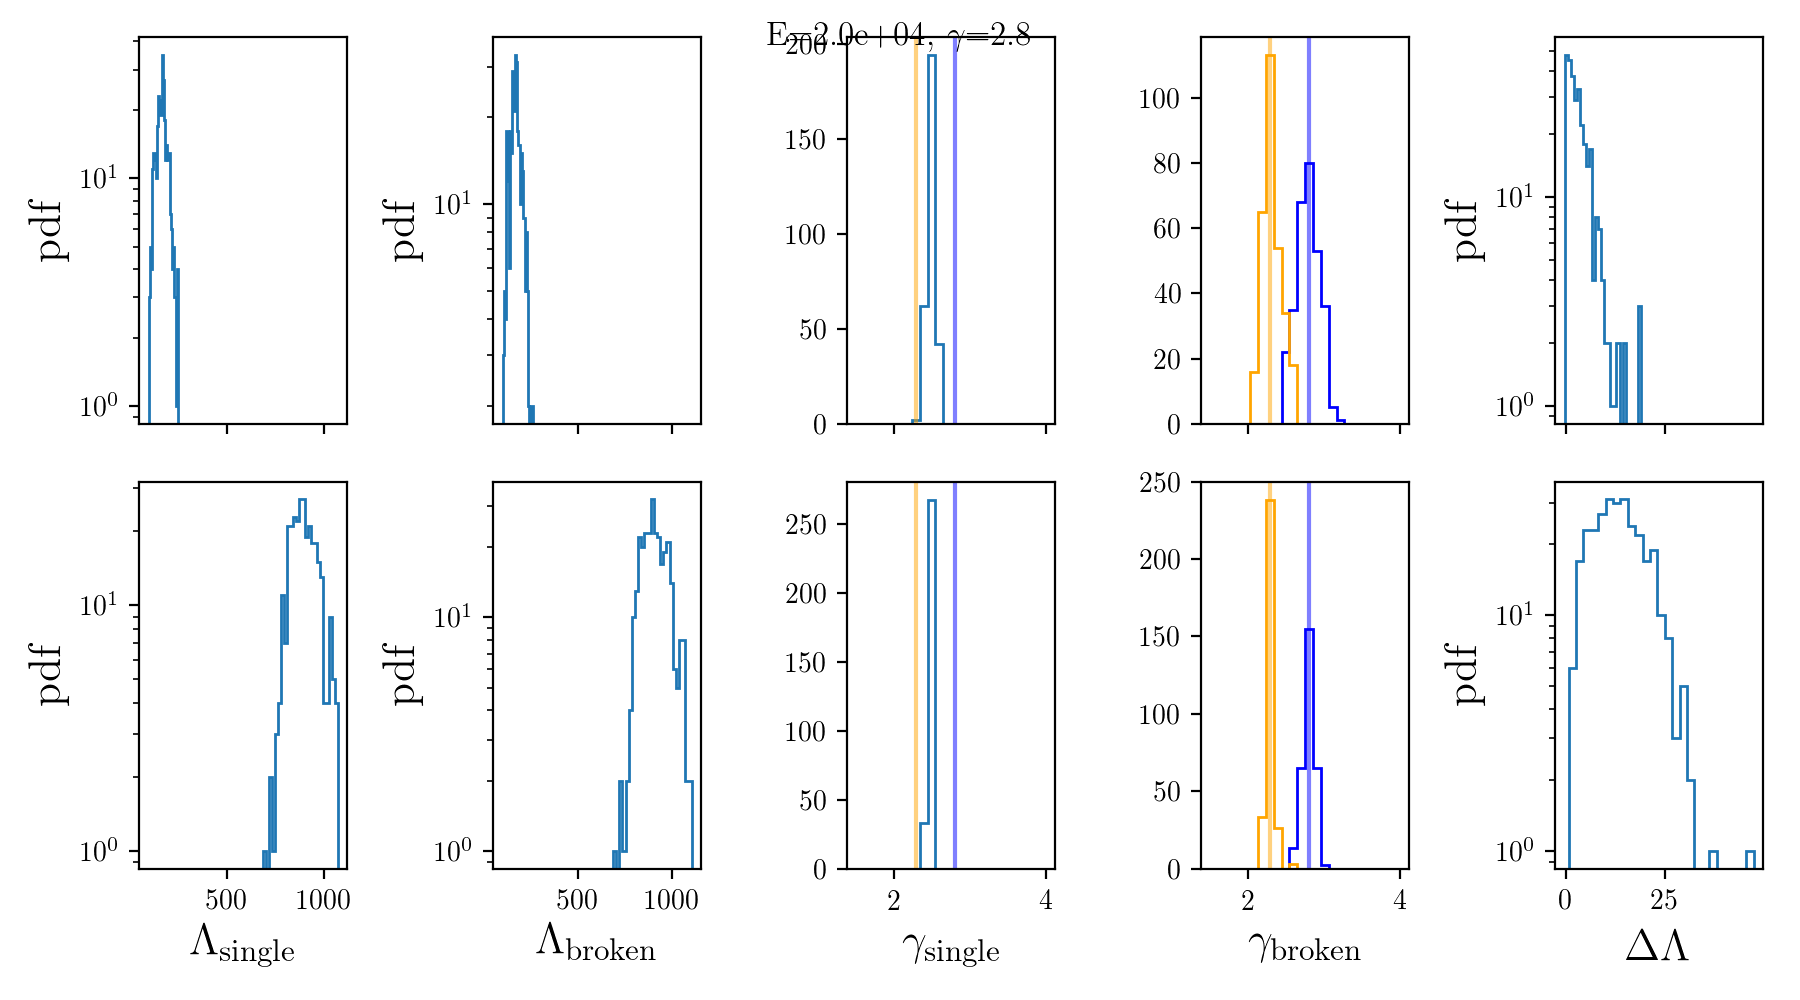

('icecube', 2.354702865470216)
('plenum', 13.24791564557762)
(20000.0, 2.8499999999999988)


<IPython.core.display.Javascript object>


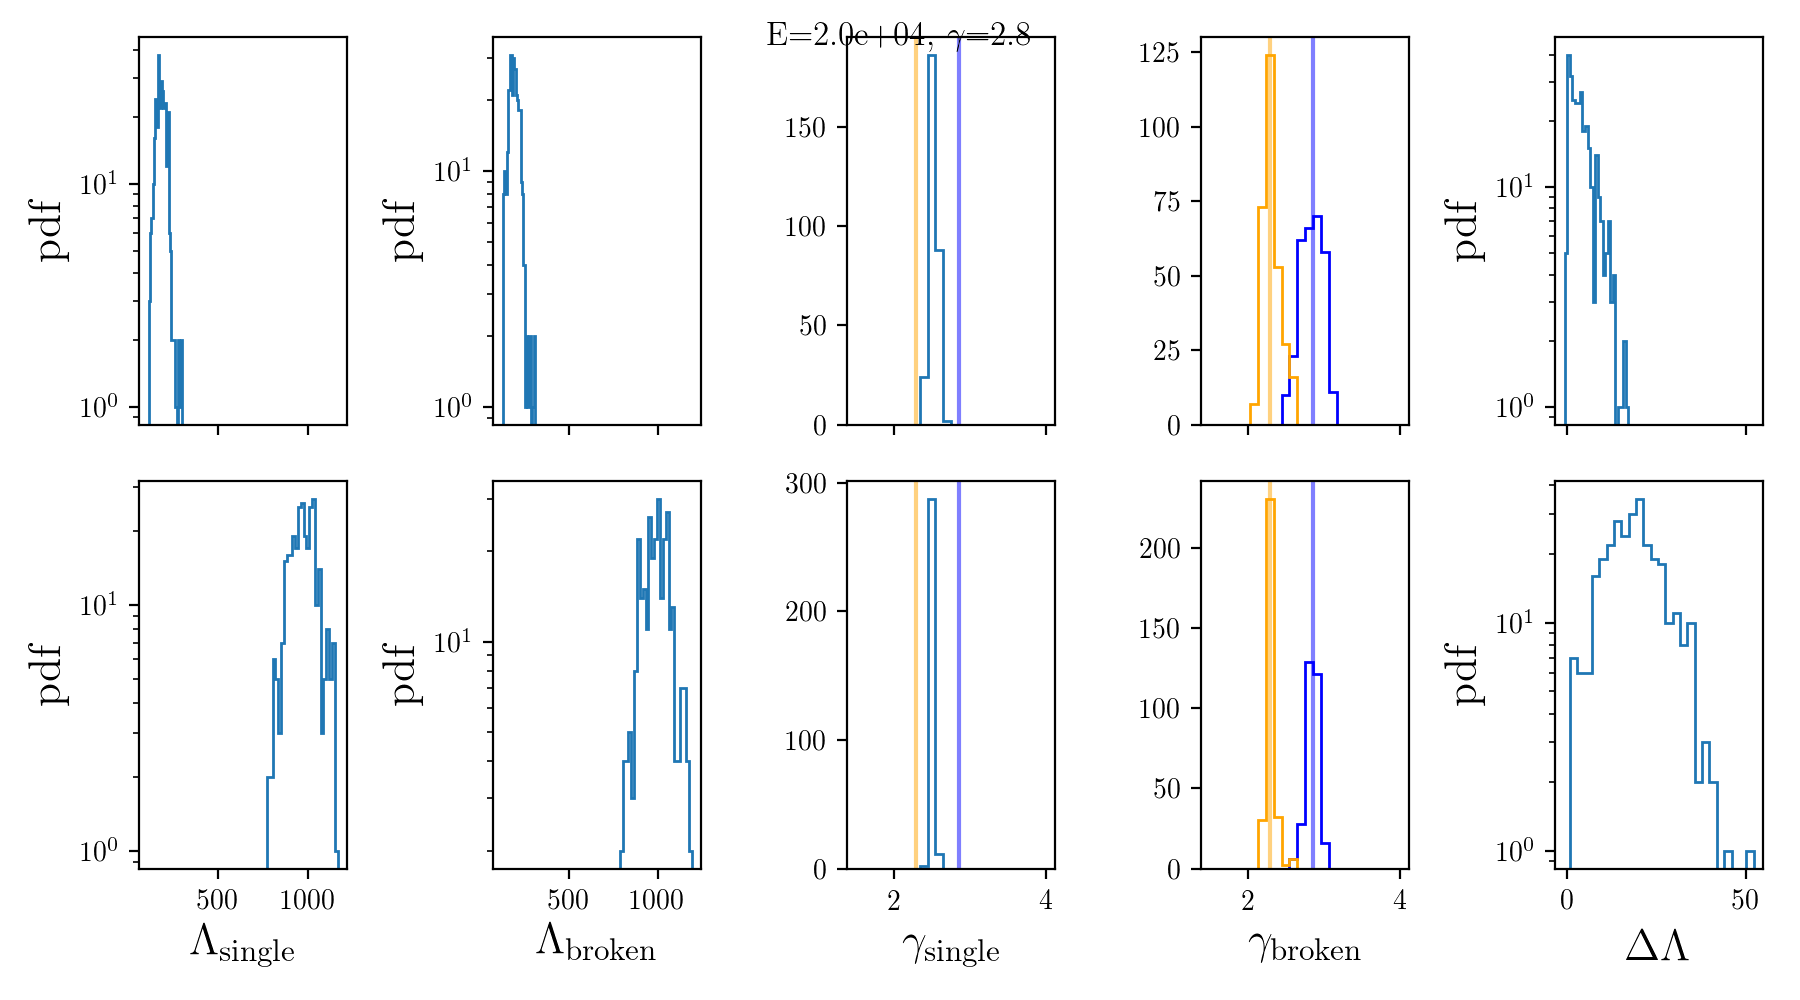

('icecube', 3.502556801084708)
('plenum', 18.610264545837538)
(100000.0, 2.5)


<IPython.core.display.Javascript object>


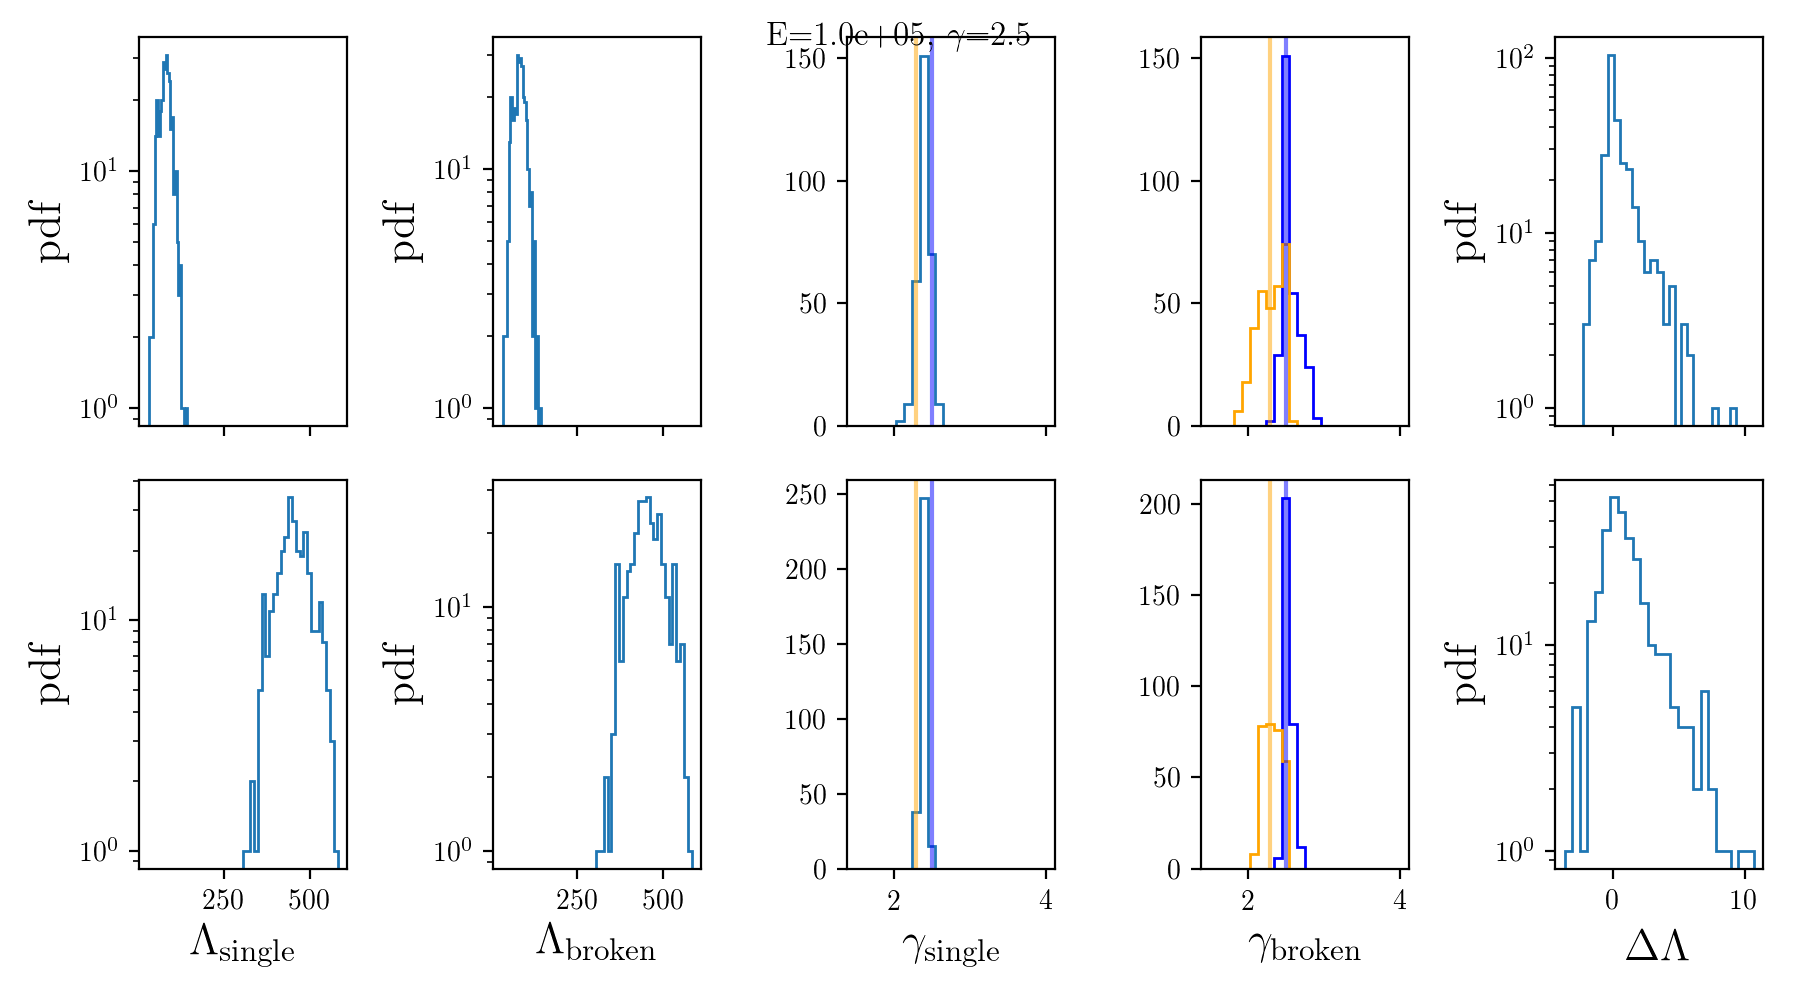

('icecube', 0.05933413676108046)
('plenum', 0.6035789277109984)
(100000.0, 2.55)


<IPython.core.display.Javascript object>


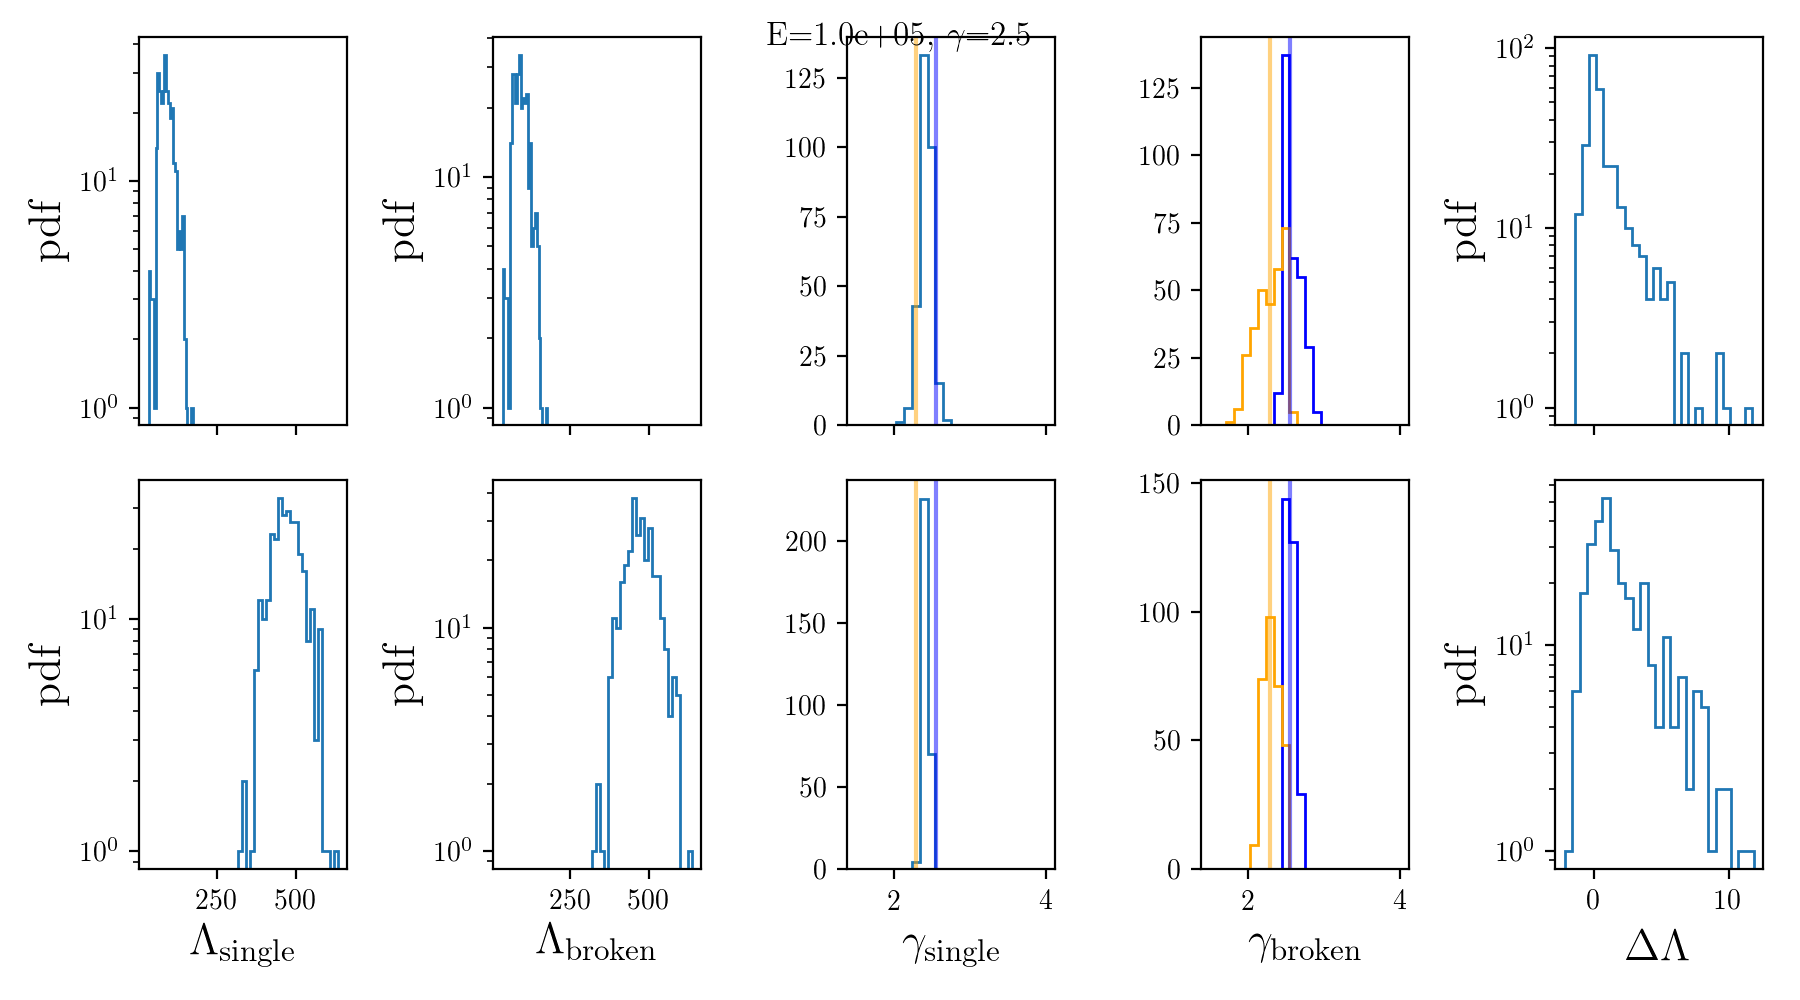

('icecube', 0.2894823417617616)
('plenum', 1.2657667851785277)
(100000.0, 2.5999999999999996)


<IPython.core.display.Javascript object>


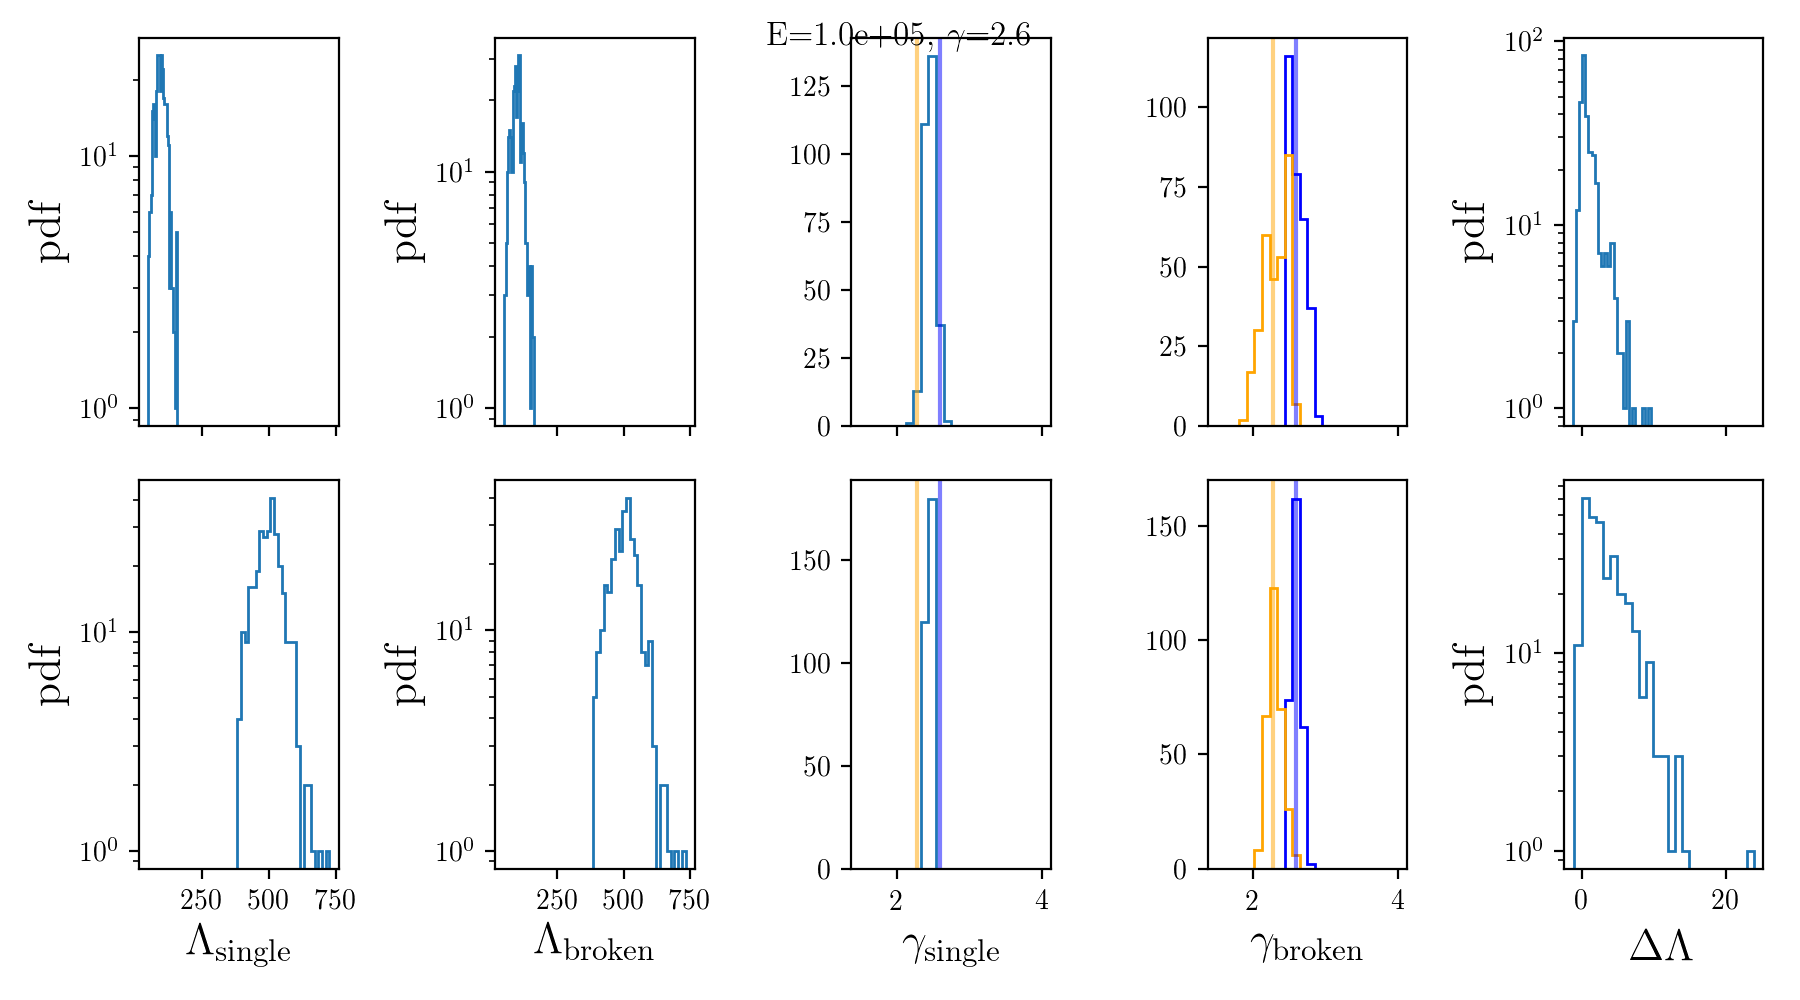

('icecube', 0.4442227505955785)
('plenum', 2.488305392855665)
(100000.0, 2.6499999999999995)


<IPython.core.display.Javascript object>


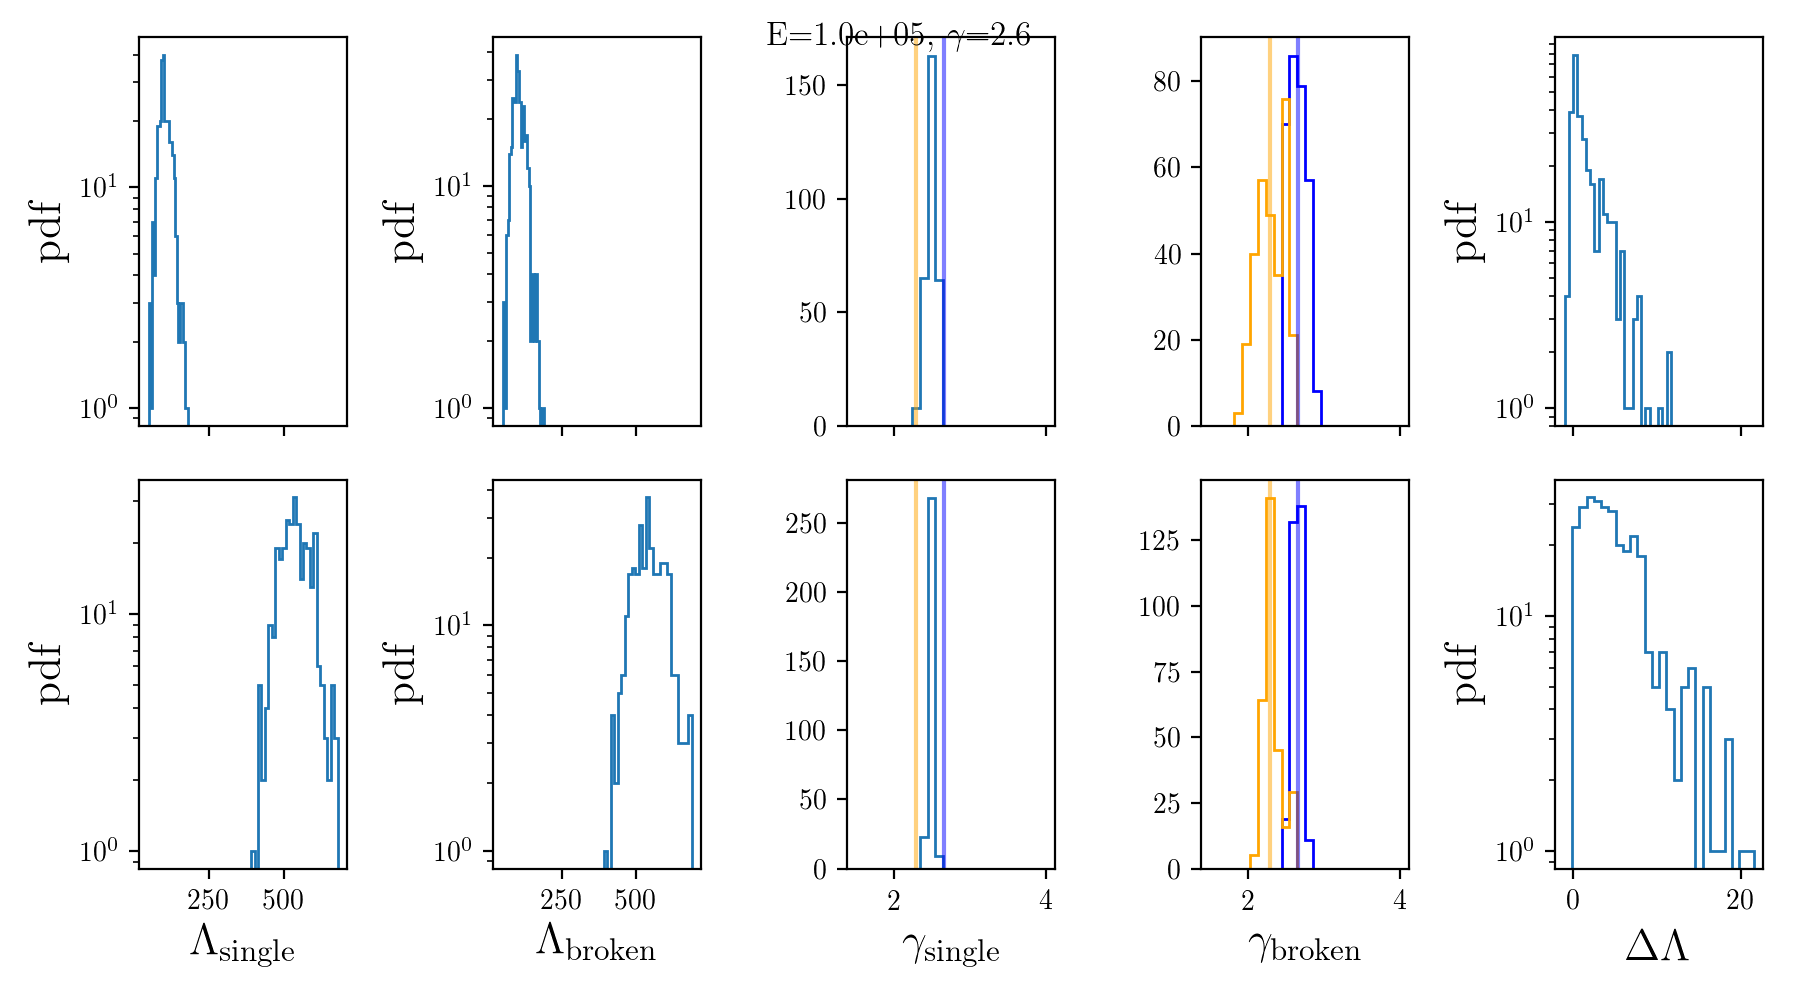

('icecube', 0.8446008608539657)
('plenum', 4.32739984329919)
(100000.0, 2.6999999999999993)


<IPython.core.display.Javascript object>


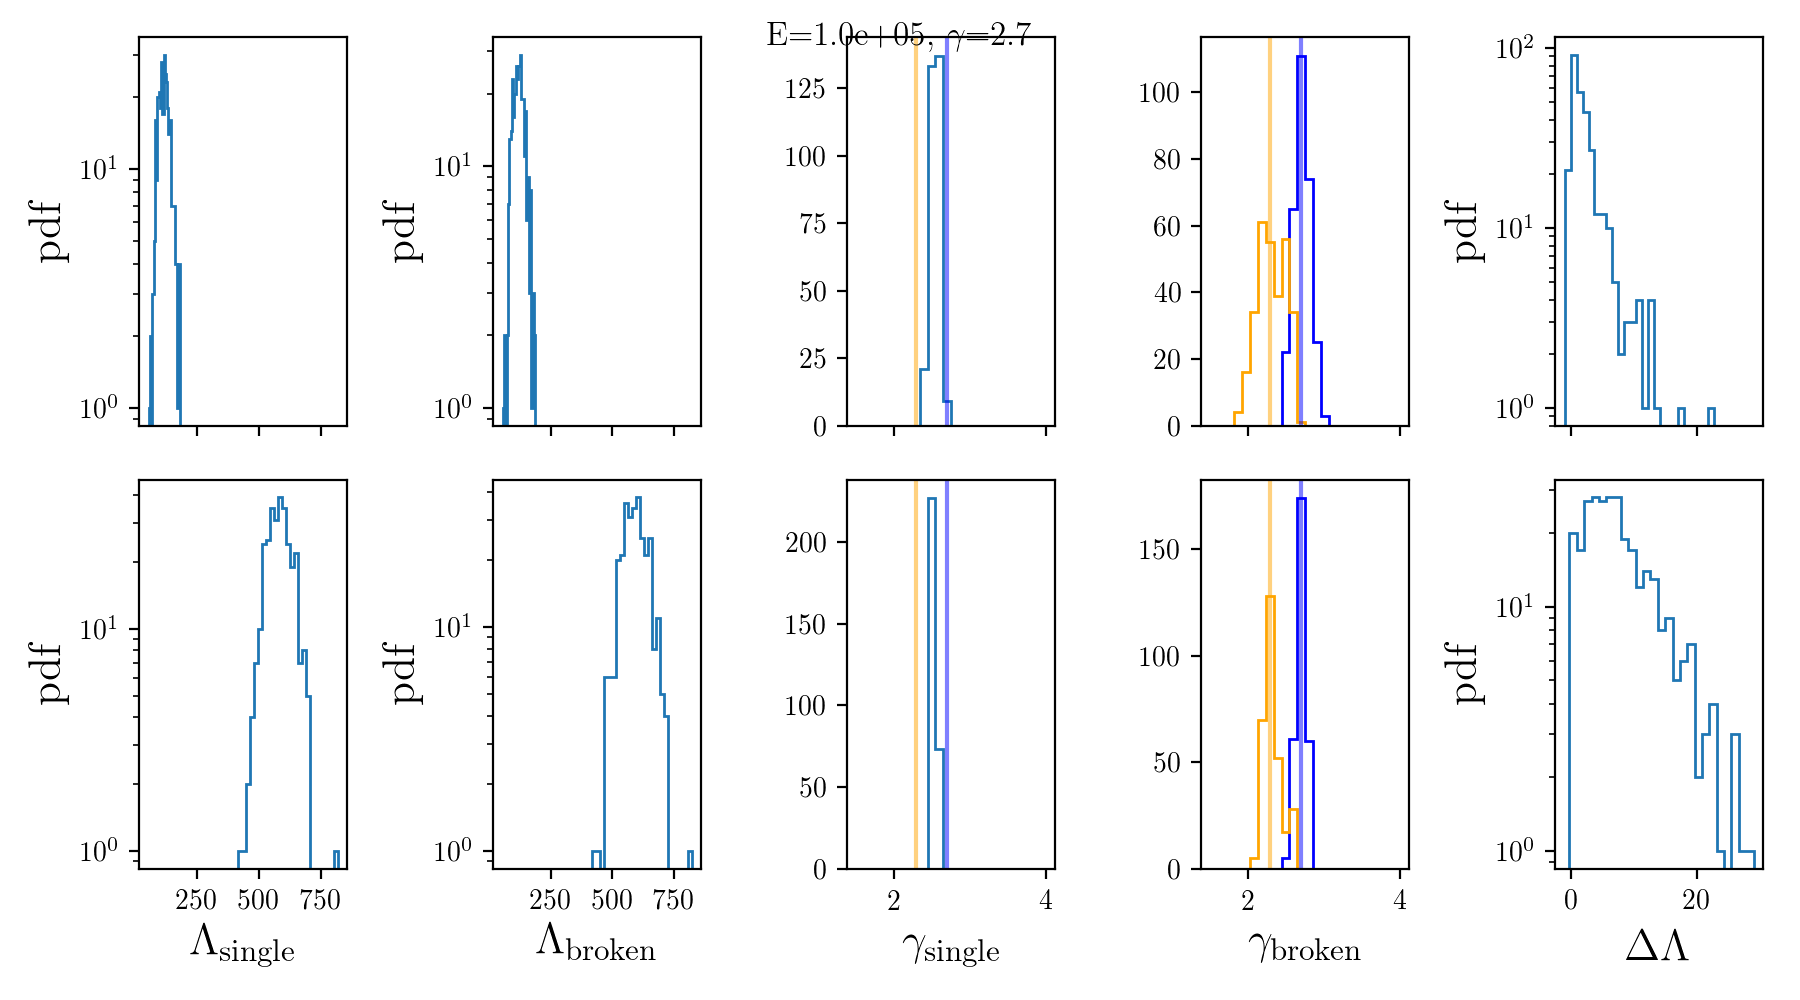

('icecube', 1.465153187108875)
('plenum', 6.972475692991736)
(100000.0, 2.749999999999999)


<IPython.core.display.Javascript object>


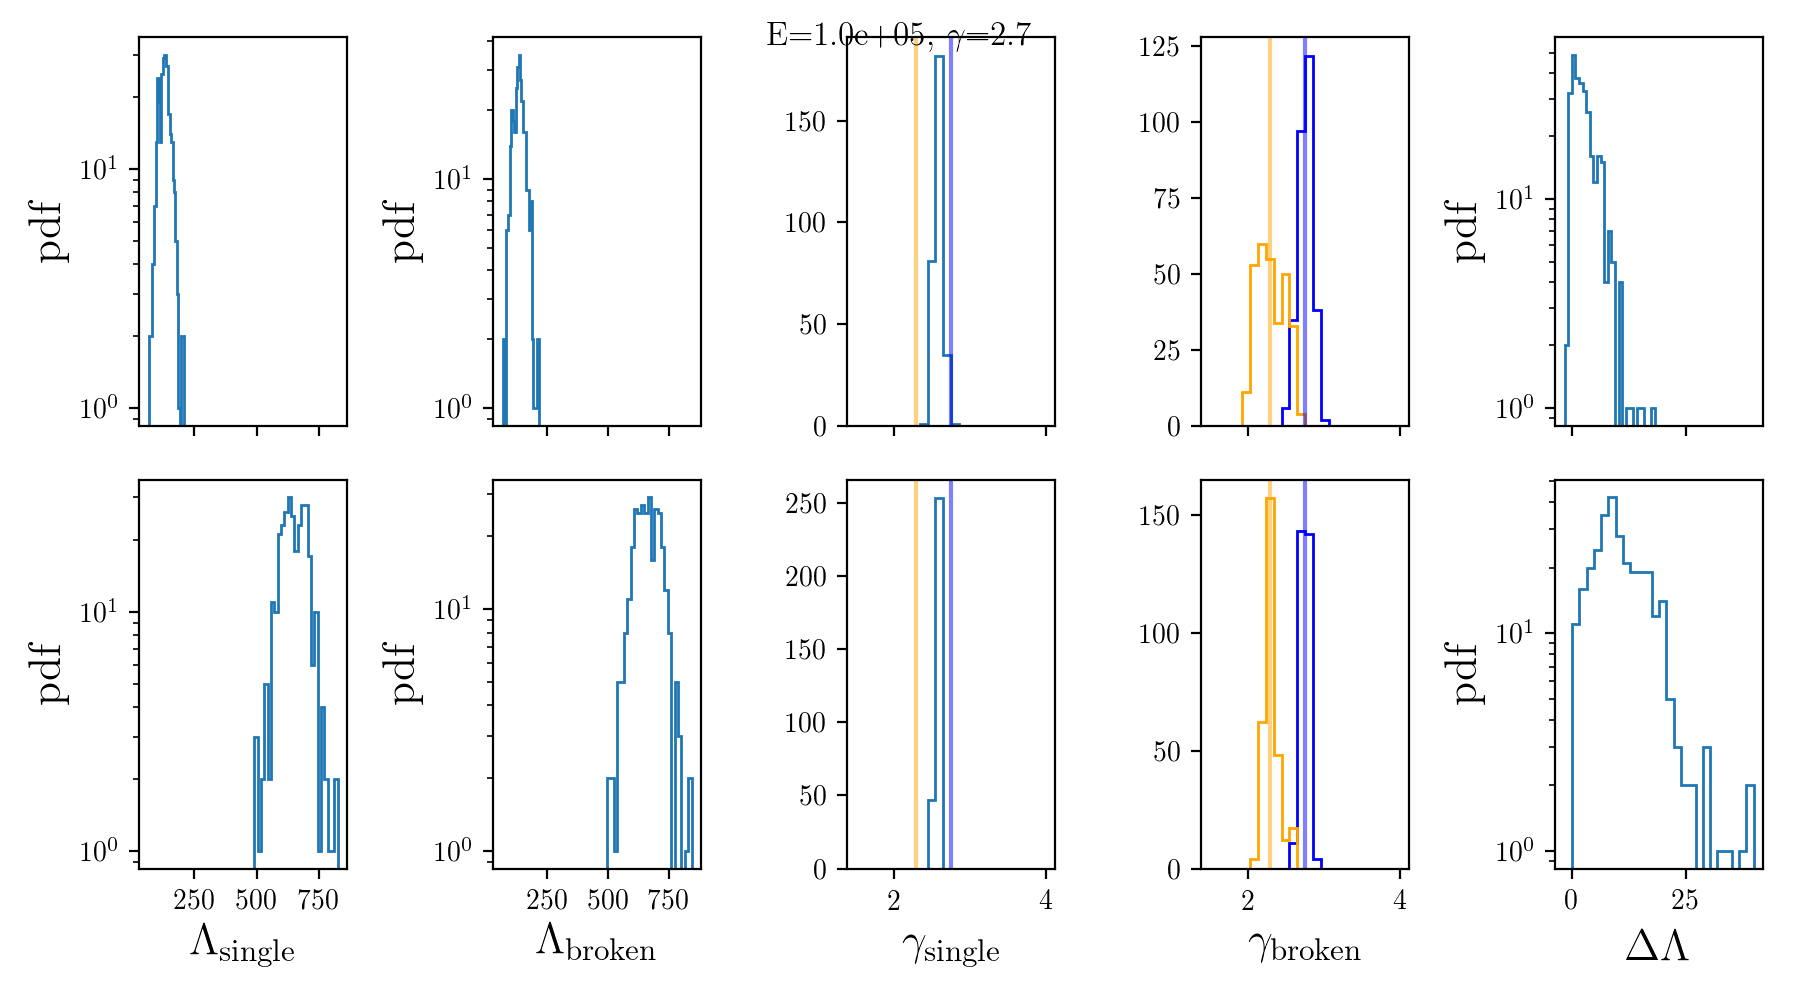

('icecube', 2.226820744152448)
('plenum', 9.893628782062194)
(100000.0, 2.799999999999999)


<IPython.core.display.Javascript object>


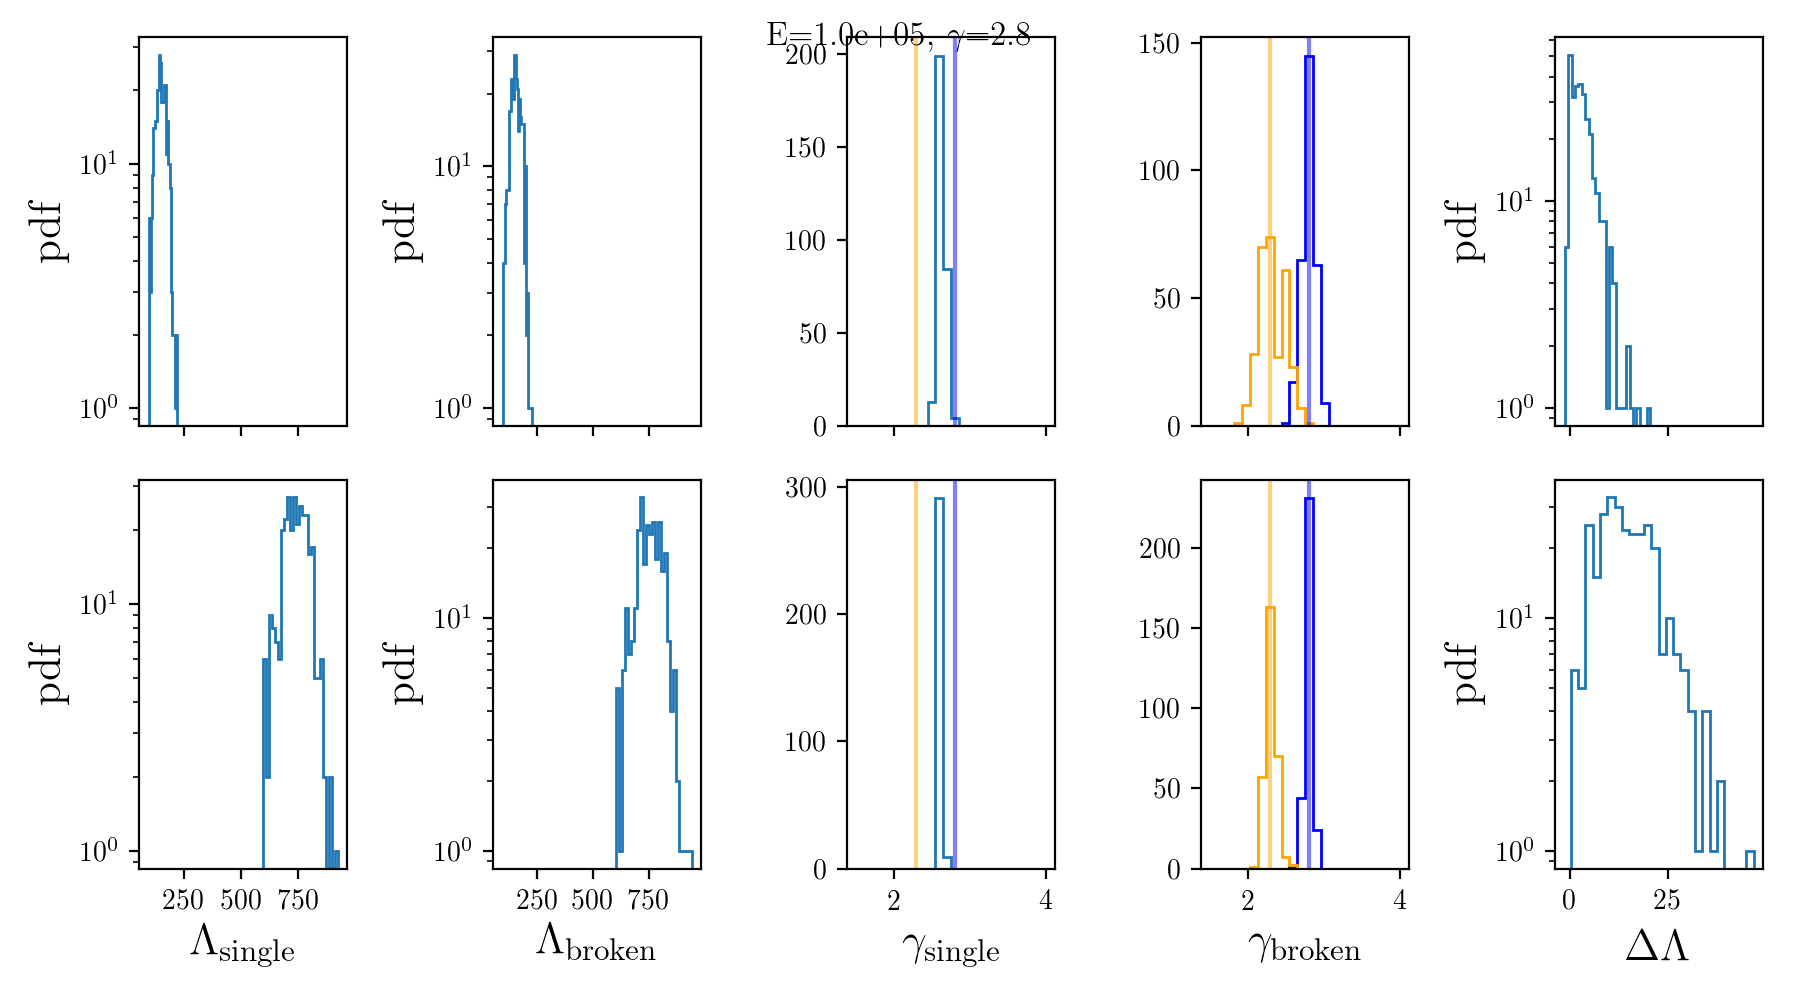

('icecube', 2.6188533583706004)
('plenum', 14.087215985453156)
(100000.0, 2.8499999999999988)


<IPython.core.display.Javascript object>


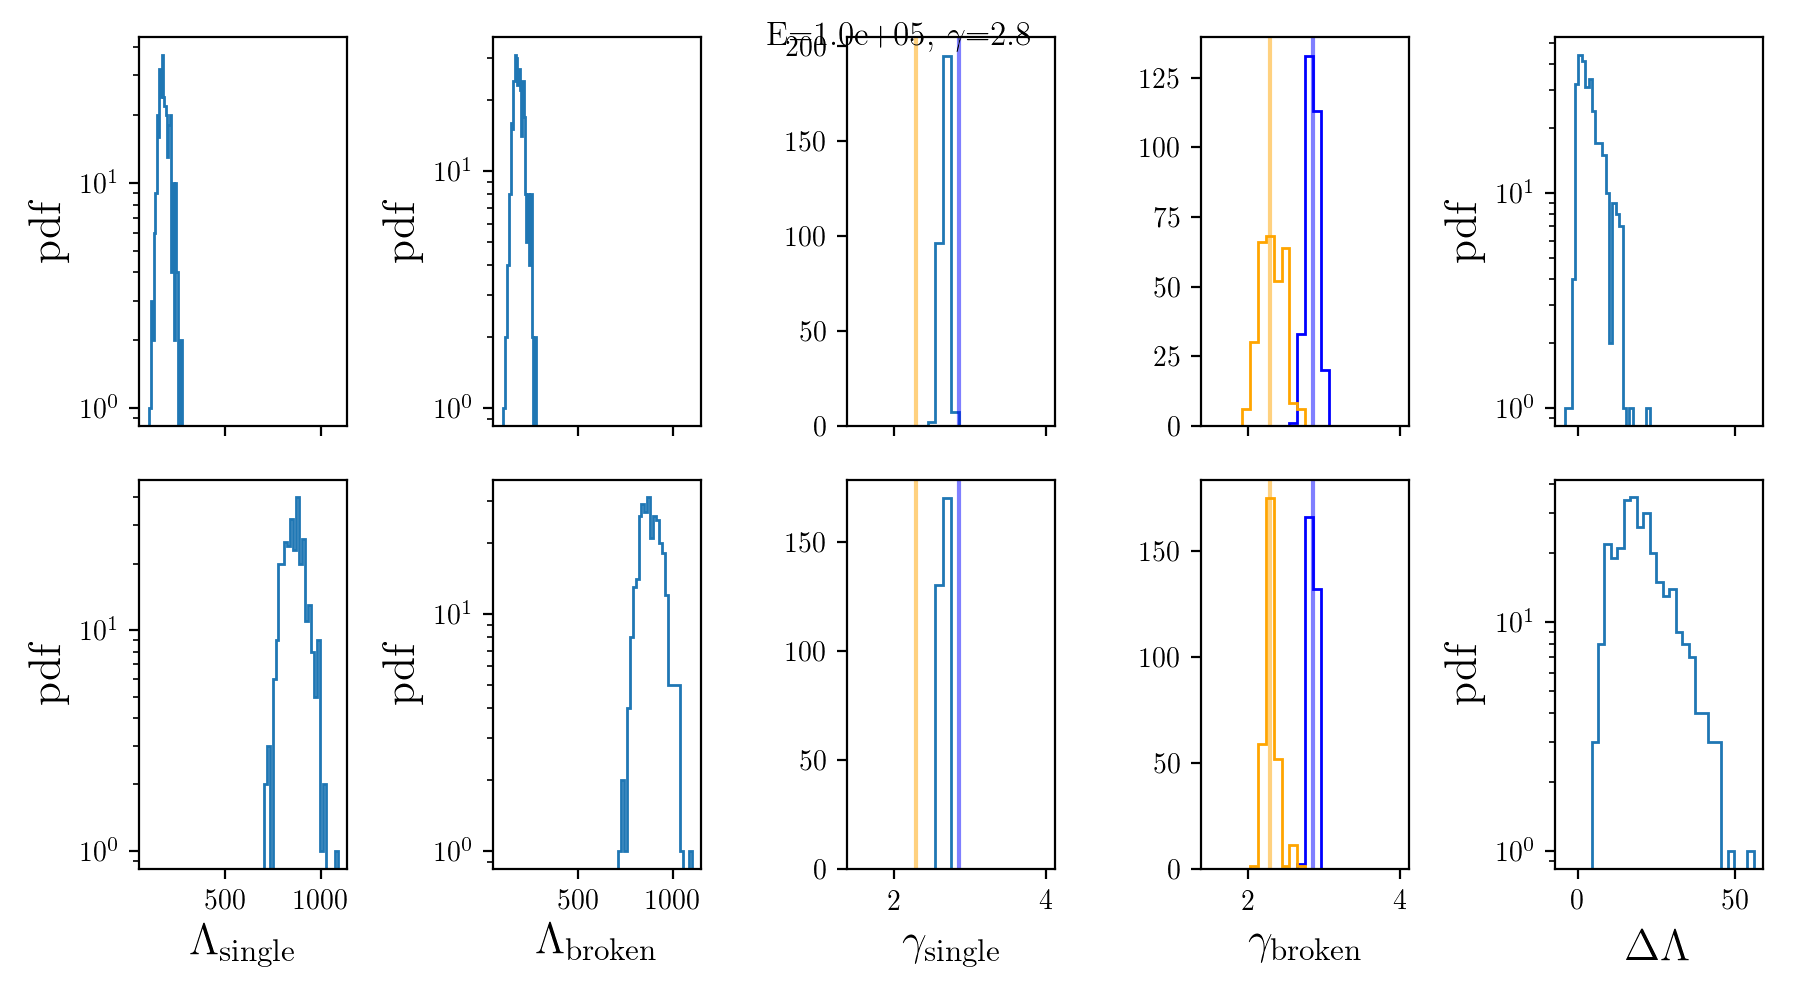

('icecube', 3.2709802127860854)
('plenum', 19.282502901831776)


In [53]:
#print(phi_inj, g_inj0, g_inj1)
fs=16
ts_vals_icecube = dict()
ts_vals_plenum = dict()

for ek, E_threshold in enumerate(E_thresholds):
    ts_vals_icecube[ek] = list()
    ts_vals_plenum[ek] = list()
    for gi, g_inji in enumerate(g_inj0s):
        print(E_threshold,g_inji)
        
        fig, axes = plt.subplots(ncols=5,nrows=2,  figsize=(9,5.), sharex='col')
        fig.suptitle(r'E={0:.1e}, $\gamma$={1:.1f}'.format(E_threshold, g_inji))
        for k, exp in enumerate(['icecube', 'plenum']):
            ax = axes[k, 0]
            bins = np.linspace(0,25, 35)
            ax.hist(RES_Recover[exp][(ek,gi)]['ts'], bins=25, histtype='step')
            ax.set_yscale('log')
            if k==1:
                ax.set_xlabel(r'$\Lambda_{\mathrm{single}}$', fontsize=fs)
            ax.set_ylabel(r'pdf', fontsize=fs)

            ax = axes[k, 1]
            bins = np.linspace(0,25, 35)
            ax.hist(RES_Recover_broken[exp][(ek,gi)]['ts'], bins=25, histtype='step')
            ax.set_yscale('log')


            if k==1:
                ax.set_xlabel(r'$\Lambda_{\mathrm{broken}}$', fontsize=fs)
            ax.set_ylabel(r'pdf', fontsize=fs)


            ax = axes[k, 3]
            bins = _gs #np.linspace(np.min(gammas), np.max(gammas), 30)
            ax.hist(RES_Recover_broken[exp][(ek,gi)]['gamma0'], bins=bins, histtype='step', color='blue')
            ax.axvline(g_inji, color='blue', alpha=0.5)

            ax.hist(RES_Recover_broken[exp][(ek,gi)]['gamma1'], bins=bins, histtype='step', color='orange')
            ax.axvline(g_inj1, color='orange', alpha=0.5)
            if k==1:
                ax.set_xlabel(r'$\gamma_{\mathrm{broken}}$', fontsize=fs)

            ax = axes[k, 2]
            bins = _gs #np.linspace(np.min(gammas), np.max(gammas), 30)
            ax.hist(RES_Recover[exp][(ek,gi)]['gamma'], bins=bins, histtype='step')
            ax.axvline(g_inji, color='blue', alpha=0.5)
            ax.axvline(g_inj1, color='orange', alpha=0.5)
            if k==1:
                ax.set_xlabel(r'$\gamma_{\mathrm{single}}$', fontsize=fs)


            ax = axes[k, 4]
            bins = np.linspace(0,25, 35)
            ax.hist(RES_Recover_broken[exp][(ek,gi)]['ts'] - RES_Recover[exp][(ek,gi)]['ts'] , bins=25, histtype='step')


            med = np.median(RES_Recover_broken[exp][(ek,gi)]['ts'] - RES_Recover[exp][(ek,gi)]['ts'])
            print(exp, med)
            if exp =='icecube':
                ts_vals_icecube[ek].append(med)
            else:
                ts_vals_plenum[ek].append(med)
            #bckg_res = Bckg_Recover_broken[exp]['ts'] - Bckg_Recover[exp]['ts']
            #bckg_res[bckg_res<0] = 0.
            #pvali = np.sum(bckg_res > med) / float(len(bckg_res)) 
            #print(exp, np.median(RES_Recover_broken[exp]['ts']), np.median(RES_Recover[exp]['ts']))
            #print(exp, med, pvali)
            ax.set_yscale('log')
            if k==1:
                ax.set_xlabel(r'$\Delta \Lambda$', fontsize=fs)
            ax.set_ylabel(r'pdf', fontsize=fs)



        fig.tight_layout()

In [54]:
from scipy.stats import norm 
def sigma2pval(sigma, one_sided=True):
    if one_sided:
        return norm.sf(sigma)
    else: 
        return 1.-(norm.cdf(sigma)-norm.cdf(-sigma))

<IPython.core.display.Javascript object>


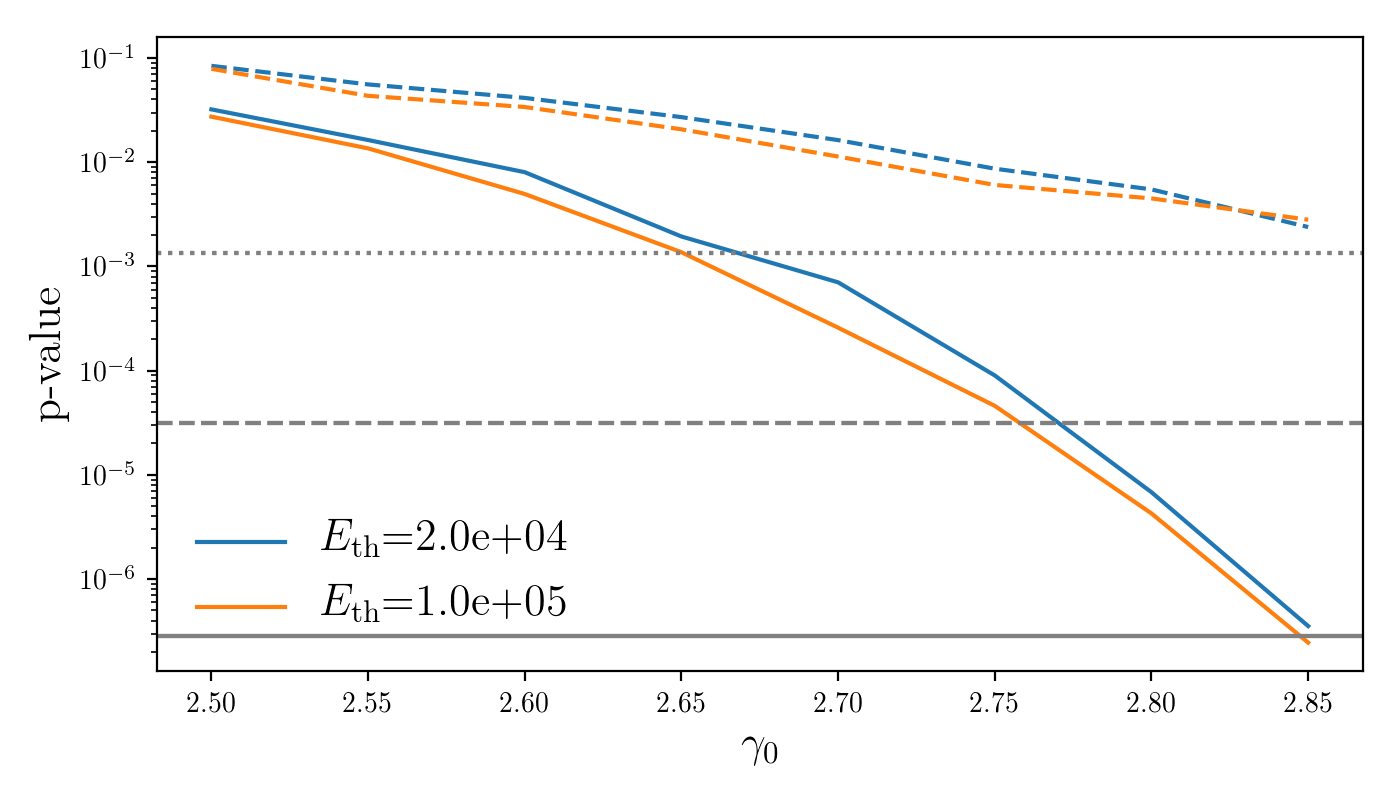

('ts icecube', [0.04611904148856638, 0.1669930341860848, 0.3155534051693323, 0.611715730530257, 1.0748699592920374, 1.7790423244445819, 2.354702865470216, 3.502556801084708])
('ts plenum', [0.4814127526991001, 1.0733192890078271, 1.872538601442443, 3.8073340475662008, 5.355247923465868, 8.741475134240432, 13.24791564557762, 18.610264545837538])
[False False False False False False False False]
[0.08414619 0.05582029 0.04143926 0.02709287 0.01630981 0.0086672
 0.00548458 0.00238893]
('2', array([0.04505203, 0.02887286, 0.02104217, 0.01347833, 0.00796378,
       0.00415742, 0.00260363, 0.00111683]))
[False False False False False False False False]
[False False False False False False False False]
('ts icecube', [0.05933413676108046, 0.2894823417617616, 0.4442227505955785, 0.8446008608539657, 1.465153187108875, 2.226820744152448, 2.6188533583706004, 3.2709802127860854])
('ts plenum', [0.6035789277109984, 1.2657667851785277, 2.488305392855665, 4.32739984329919, 6.972475692991736, 9.893628

In [59]:
from scipy.stats import chi2
fig, ax = plt.subplots( figsize=(7,4.))
for ek, E_threshold in enumerate(E_thresholds):
    print('ts icecube',  ts_vals_icecube[ek])
    print('ts plenum',  ts_vals_plenum[ek])
    print(pval_function( ts_vals_icecube[ek], df=0.2, x0=0.7))
    print('2',fit_func.sf(ts_vals_icecube[ek]))
    p=ax.plot(g_inj0s, pval_function( ts_vals_icecube[ek], df=0.2, x0=0.7), ls='dashed')
    ax.plot(g_inj0s, pval_function( ts_vals_plenum[ek], df=0.2, x0=0.7), ls='solid', color=p[0].get_color(),
           label=r'$E_{\mathrm{th}}$='+'{0:.1e}'.format(E_threshold))
    
    ax.axhline(sigma2pval(3), color='grey', ls='dotted')
    ax.axhline(sigma2pval(4), color='grey', ls='dashed')
    ax.axhline(sigma2pval(5), color='grey', ls='solid')
    
ax.legend(fontsize=fs, loc='lower left', frameon=False)
ax.set_yscale('log')
ax.set_xlabel(r'$\gamma_0$', fontsize=fs)
ax.set_ylabel('p-value', fontsize=fs)

fig.tight_layout()

fig.savefig('plots/diffuse_analysis_broken_pl_pvalues.pdf')
    

----
# Now we want to see if we can determine a power-law cut-off
----

In [62]:
def max_LambdaTS_cutoff(data, lambda_b, spline, initials=None, **kwargs):
    r'''
    data: observed number of events in each energy bin
    lambda_b: expected number of background events in each bin
    '''
    def func(*args):
        log10_phi100, gamma0, log_coff = args
        
        coff= 10**log_coff
        lambda_s = conv_func_cutoff(log10_phi100, gamma0, coff, spline)
        r = lambda_s / lambda_b #background expectation should not be 0
    
        _mask = (np.ones_like(lambda_s)*lambda_b) == 0
        r[_mask] = 0
        res = 2 * np.sum(np.log(1+r) * data - lambda_s)
        return -res
        
    
    if initials is None:
        initials = [np.log10(phi100s[5]), 2.5, 6]
    #print(initials)
    
    bounds = [(np.log10(phi100s[0])+0.1, np.log10(phi100s[-1])-0.1  ),
              (gammas[0]+0.1, gammas[-1]-0.1),
             (np.log10(cutoffs[0])+0.1, np.log10(cutoffs[-1])-0.1  )]

    #set initial values for the fitting parameters
    p_names = ['p{}'.format(_) for _ in range(len(initials))]
    fit_arg = dict(zip(p_names, initials))

    p_bounds = ['limit_p{}'.format(_) for _ in range(len(initials))]
    pbounds = [bounds[i] for i in range(len(p_bounds))]
    fit_arg.update(dict(zip(p_bounds, pbounds)))

    fit_min = Minuit(fcn=func,
                    forced_parameters=p_names,
                    pedantic=False,
                    print_level=0,
                    **fit_arg)

    fit_min.migrad(resume=False)
    ncalls = fit_min.ncalls
    for l in range(50):
        r = fit_min.migrad(resume=True)
        ncalls += fit_min.ncalls
        if r[0]['has_valid_parameters']:
            break

    xmin = fit_min.args
    fmin = fit_min.fval

    status = dict()
    status['warnflag'] = 0
    status['nit'] = ncalls

    return (xmin, fmin, status)

In [63]:
phi_inj = 1.44e-18
g_inj = 2.28#2.3
# we will fix the high energy part to the diffuse results 
# and fix phi0 such that it't always the same at 500TeV

Cutoff_vals = 10**np.arange(5,9,0.5)


<IPython.core.display.Javascript object>


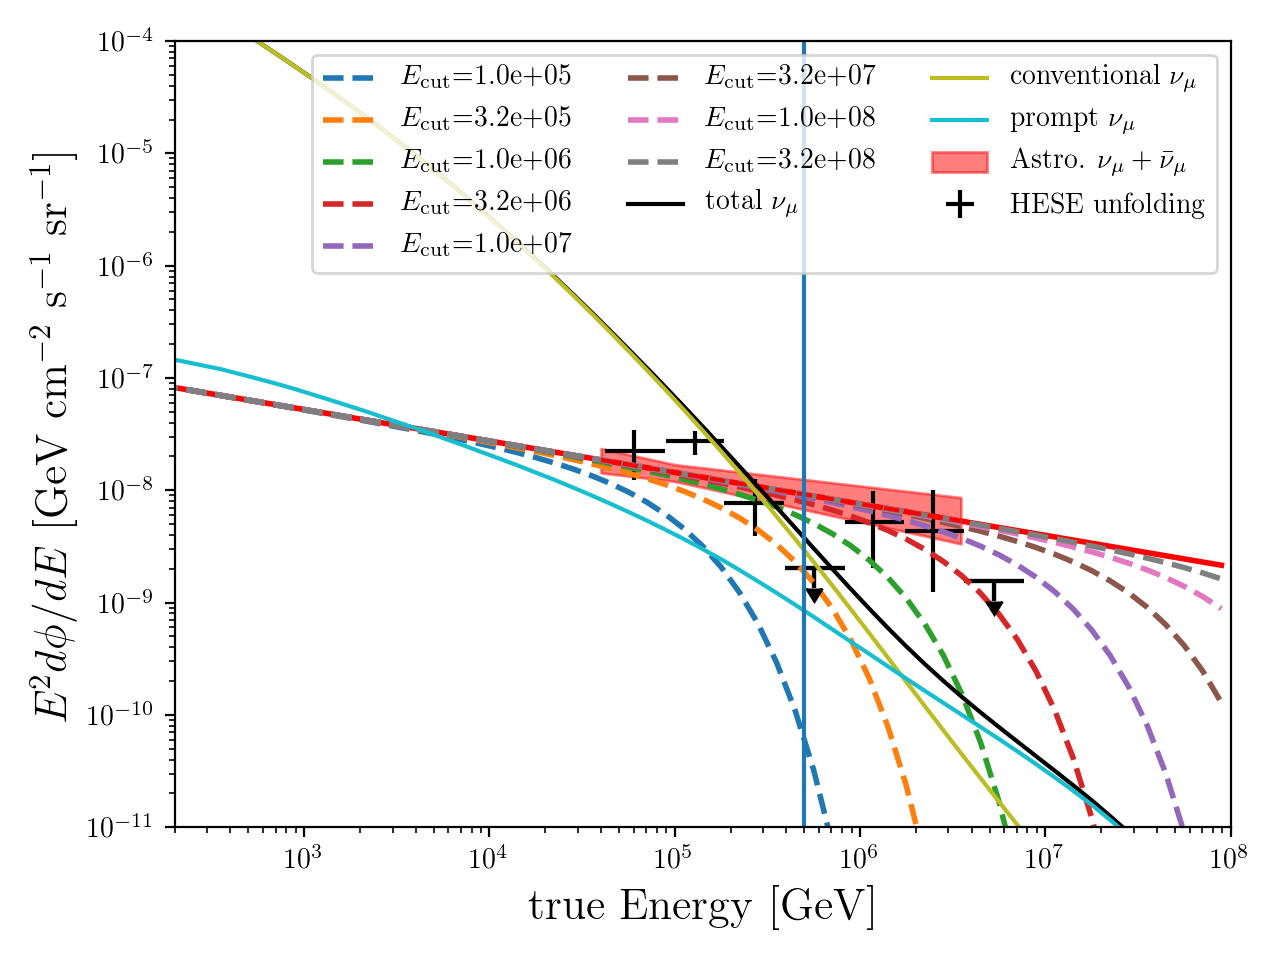

In [65]:
# show the spectrum compared to the diffuse
fig, ax = plt.subplots()

ax.plot(etrue_mids, etrue_mids**2 * phi_inj * (etrue_mids/1e5)**(-g_inj), c='red',lw=2)


for coffi in Cutoff_vals:
    ax.plot(etrue_mids, etrue_mids**2 * phi_inj * (etrue_mids/1e5)**(-g_inj) * np.exp(-etrue_mids/coffi), 
                    lw=2, ls='dashed', label=r'$E_{\mathrm{cut}}$='+'{0:.1e}'.format(coffi))
    
add_diffuse_10years(ax)
add_hese(ax)


for i,(pref, lab) in enumerate([('numu_',r'\nu_\mu')]):
    
    p0 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'total'], color='k', ls='solid', lw=1.5,
                  label=r'total ${0}$'.format(lab))
    p1 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'conv'],  ls='solid', lw=1.5,
               label=r'conventional ${0}$'.format(lab))
    p2 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'pr'], ls='solid', lw=1.5, 
               label='prompt ${0}$'.format(lab))

ax.set_xlim(2e2, 1e8)
ax.set_ylim(1e-11,1e-4)

ax.legend(ncol=3)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel('true Energy [GeV]', fontsize=fs)
ax.set_ylabel(r'$E^2 d\phi/dE$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]', fontsize=fs)

ax.axvline(5e5)
fig.tight_layout()
fig.savefig('plots/diffuse_analysis_cutoff_pl_illustration.pdf')

<IPython.core.display.Javascript object>


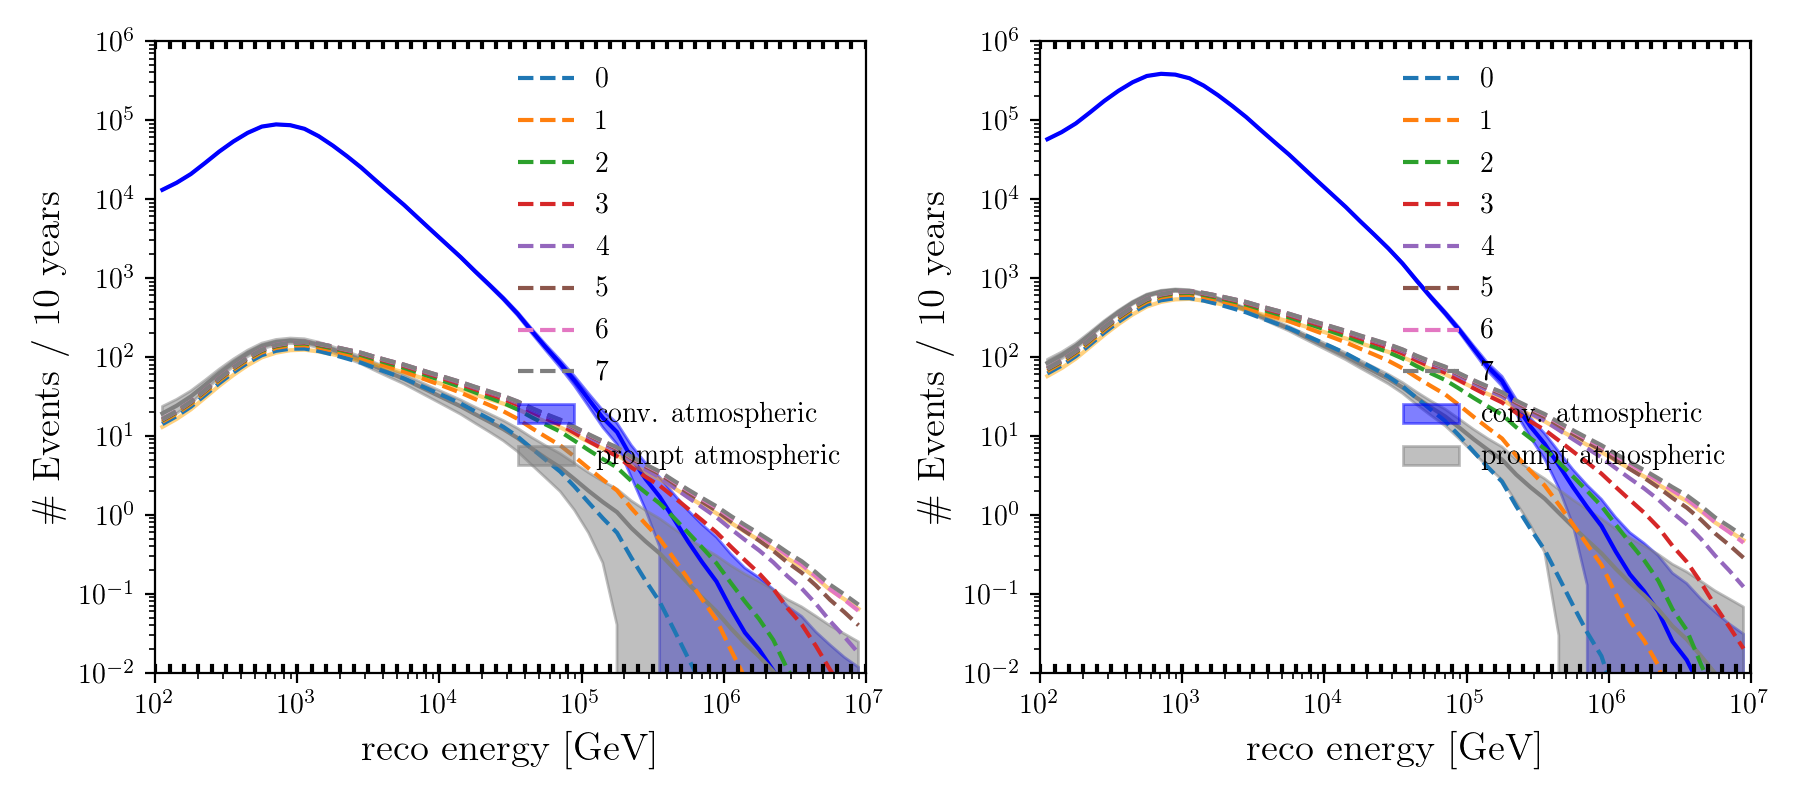

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))



for k, exp in enumerate(['icecube', 'plenum']):

    ax = axes[k]
    Bckg_vals = Background_values_reco[exp]
    Bckg_vals_pr = Background_values_prompt_reco[exp]
    

    Bckg_vals[Bckg_vals<=0] = 0
    yerr=np.sqrt(Bckg_vals)
    ax.plot(ereco_mids, Bckg_vals, color='blue')
    ax.fill_between(ereco_mids, Bckg_vals-yerr, Bckg_vals+yerr, alpha=0.5, color='blue',
                   label = r'conv. atmospheric')

    Bckg_vals_pr[Bckg_vals_pr<=0] = 0
    yerr=np.sqrt(Bckg_vals_pr)
    ax.plot(ereco_mids, Bckg_vals_pr, color='grey')
    ax.fill_between(ereco_mids, Bckg_vals_pr-yerr, Bckg_vals_pr+yerr, alpha=0.5, color='grey',
                   label = r'prompt atmospheric')

    # add all possible outcomes to the final plot jus to see if the calculation of F makes sense
    spline = Splines[exp]
    lambda_s = conv_func(np.log10(1.44e-18), 2.28, spline)[0]
    ax.plot(ereco_mids, lambda_s, color='orange', alpha=0.5)
    
    
    spline_co = Splines_cutoff[exp]
    for ci, coffi in enumerate(Cutoff_vals):
        lambda_s2 = conv_func_cutoff(np.log10(phi_inj), g_inj, coffi, spline_co)[0]
        ax.plot(ereco_mids, lambda_s2,  ls='dashed', label=str(ci))
    
    # indicate the binning in energy
    for ei in ereco_bins:
        ax.axvline(ei, ymin=0, ymax=0.01, color='black')
        ax.axvline(ei, ymin=0.99, ymax=1, color='black')


    ax.set_xlim(1e2,1e7)
    ax.set_ylim(1e-2,1.e6)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel('reco energy [GeV]', fontsize=14)
    ax.set_ylabel(r'\# Events / 10 years', fontsize=14)
    ax.legend(loc='upper right', frameon=False)

    

fig.tight_layout()

In [ ]:
print(Cutoff_vals)

# Get the background distribution 

In [68]:
N_trials = int(500)
n_trials =  int(50)

Bckg_Recover_v2 = dict()
Bckg_Recover_cutoff = dict()

#fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(9,5))

n_plot = 0
for k, exp in enumerate(['icecube', 'plenum']):
    
    n = 0
    start = time.clock()
    
    Res = None
    Res_single = None
    
    spline = Splines[exp]
    spline_co = Splines_cutoff[exp]
    start = time.clock()
    for _ in range(N_trials/n_trials):

        lambda_b = Background_values_reco[exp]
        _res = np.zeros((n_trials, ), dtype=[('ts', float), ('phi0',float), 
                                             ('gamma',float), ('cutoff',float)])
        _res_single = np.zeros((n_trials, ), dtype=[('ts', float), ('phi0',float), 
                                             ('gamma',float)])


        # generate a signal from a broken power law
        d_bckg = generate_bckg_data(lambda_b=lambda_b, n_trials=n_trials)
        
        d_tot = d_bckg

        
        ##################################################################################
        # get the broken pl results
        ##################################################################################
        _phis = 10**np.linspace(np.log10(np.min(phi100s))+0.1, np.log10(np.max(phi100s))-0.1, 60 )
        _gs0 = np.linspace(np.min(gammas)+0.1, np.max(gammas)-0.1, 40)
        _coffs = 10**np.linspace(np.log10(np.min(cutoffs))+0.1, np.log10(np.max(cutoffs))-0.1, 50 )
        

        xx, yy, zz = np.meshgrid(_phis, _gs0, _coffs, indexing='ij')
        
        
        
        llh_scan = LambdaTS_cutoff(np.log10(xx.flatten()), yy.flatten(),zz.flatten(), 
                                   d_tot, lambda_b ,spline_co)


        llh_scan = llh_scan.reshape((n_trials,)+xx.shape)
        
        max_vals = np.max(llh_scan, axis=(1,2,3))
        max_vals[max_vals<0] = 0
        _res['ts'] = max_vals

        llh_scani = llh_scan[0]
        llh_scani[llh_scani<0] = 0

        llh_scan = llh_scan.reshape((n_trials,)+(len(xx.flatten()),))

        _m = np.argmax(llh_scan, axis=1)
        _res['phi0'] = xx.flatten()[_m]
        _res['gamma'] = yy.flatten()[_m]
        _res['cutoff'] = zz.flatten()[_m]


        for ni in range(n_trials):
            _ints = [np.log10(_res['phi0'][ni]), _res['gamma'][ni], np.log10(_res['cutoff'][ni])]
            res_vals, res_ts, status = max_LambdaTS_broken(d_tot[ni], lambda_b, 
                                                           spline_co, initials=_ints)
            res_ts = -res_ts
            if res_ts<0:
                res_ts = 0

            if res_ts>=max_vals[ni]:
                _res['ts'][ni] = res_ts
                _res['phi0'][ni] = 10**res_vals[0]
                _res['gamma'][ni] = res_vals[1]
                _res['cutoff'][ni] = 10**res_vals[2]
                n+=1

        if Res is None:
            Res = _res
        else:
            Res = np.append(Res,_res)

            
        
        ##################################################################################
        # get the signle pl results
        ##################################################################################
        xx, yy = np.meshgrid(_phis, _gs0, indexing='ij')

        llh_scan = LambdaTS(np.log10(xx.flatten()), yy.flatten(), d_tot, lambda_b ,spline)
        llh_scan = llh_scan.reshape((n_trials,)+xx.shape)

        max_vals = np.max(llh_scan, axis=(1,2))
        max_vals[max_vals<0] = 0
        _res_single['ts'] = max_vals

        
        llh_scani = llh_scan[0]
        llh_scani[llh_scani<0] = 0
        
        
        
        llh_scan = llh_scan.reshape((n_trials,)+(len(xx.flatten()),))

        _m = np.argmax(llh_scan, axis=1)
        _res_single['phi0'] = xx.flatten()[_m]
        _res_single['gamma'] = yy.flatten()[_m]

        
        for ni in range(n_trials):
            _ints = [np.log10(_res_single['phi0'][ni]), _res_single['gamma'][ni]]
            res_vals, res_ts, status = max_LambdaTS(d_tot[ni], lambda_b, spline, initials=_ints)
            res_ts = -res_ts
            if res_ts<0:
                res_ts = 0
            
            
            if res_ts>=max_vals[ni]:
                #print('scan', max_vals[ni], np.log10(_res['phi0'][ni]), _res['gamma0'][ni], _res['gamma1'][ni])
                #print('minimizer',  res_ts, res_vals[0], res_vals[1], res_vals[2])
                #print(res_ts- max_vals[ni])
                
                _res_single['ts'][ni] = res_ts
                _res_single['phi0'][ni] = 10**res_vals[0]
                _res_single['gamma'][ni] = res_vals[1]
                n+=1
            
        
        if Res_single is None:
            Res_single = _res_single
        else:
            Res_single = np.append(Res_single, _res_single)
            
    
    

    
    Bckg_Recover_cutoff[exp] = Res
    Bckg_Recover_v2[exp] = Res_single        
    stop = time.clock()
    mins, secs = divmod(stop-start,60)
    hours,mins = divmod(mins,60)
    print("{3} trials finished after {0:3d}h {1:2d}' {2:4.2f}''".format(int(hours),int(mins),secs, 
                                                                            (_+1)*n_trials))
        
    print(exp, n)

500 trials finished after   0h  2' 22.60''
('icecube', 470)
500 trials finished after   0h  2' 10.66''
('plenum', 447)


<IPython.core.display.Javascript object>


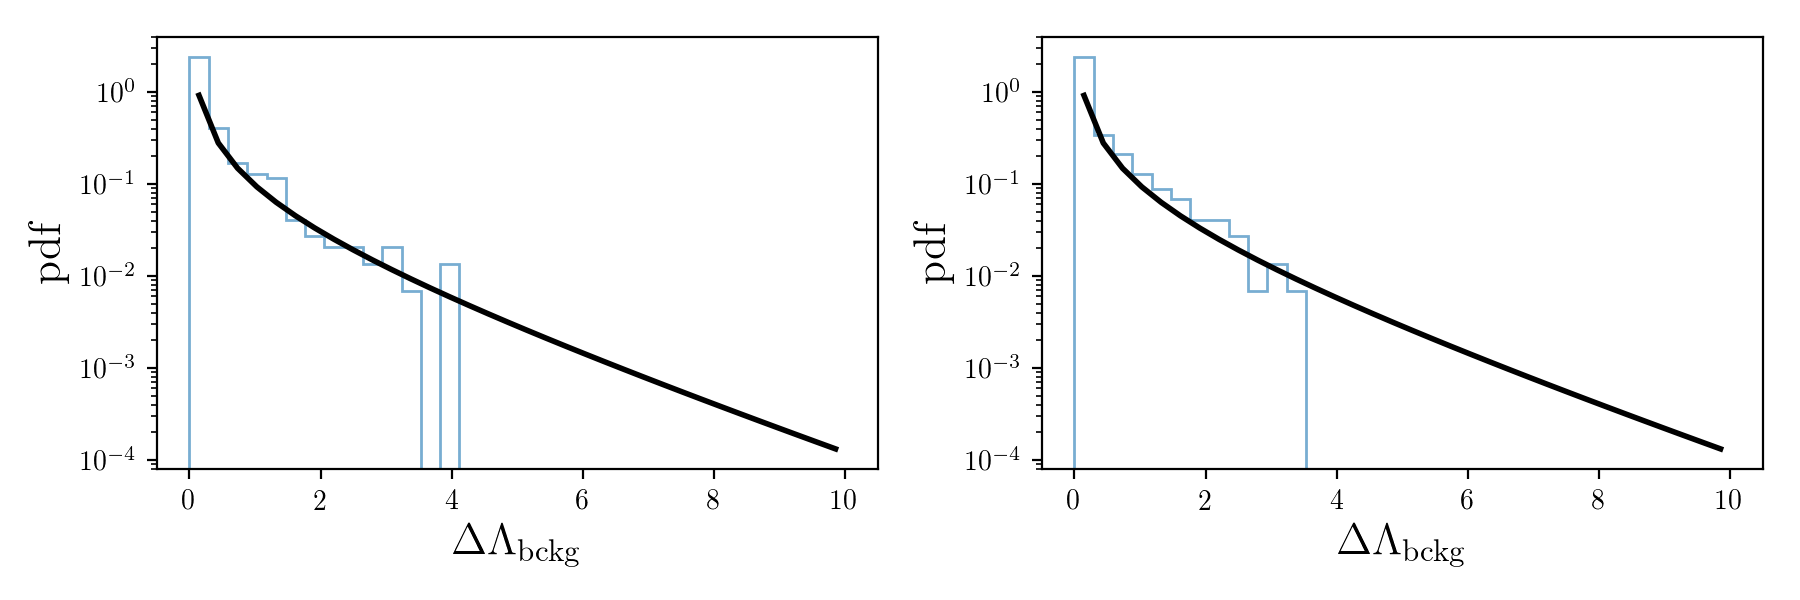

(0.096, -0.38012276587387284)
(0.272, 3.9416060427050166)
(0.092, -0.2199386749511767)
(0.23, 3.3550488938768366)


In [69]:

fig, axes = plt.subplots(ncols=2,  figsize=(9,3.), sharex='col')

for k, exp in enumerate(['icecube', 'plenum']):
    ax = axes[k]
    
    bins = np.linspace(-0.,10, 35)
    
    
        
    res_ts = Bckg_Recover_cutoff[exp]['ts'] - Bckg_Recover_v2[exp]['ts']
    print(np.sum(res_ts<0)/float(len(res_ts)), np.min(res_ts))
    res_ts[res_ts<0] = 0
    print(np.sum(res_ts==0)/float(len(res_ts)), np.max(res_ts))
    h=ax.hist(res_ts , bins=bins, histtype='step', alpha=0.6, normed=True)



    xvals = get_mids(bins)
    fit_func = delta_chi2(eta=0.5, df=.1)
    fit_vals = fit_func.pdf(xvals)
    fit_vals[:] /= (np.sum(fit_vals) /(fit_func.eta))
    ax.plot(xvals, fit_vals / np.diff(xvals)[0] , color='black', lw=2., 
            label=r'$0.50\cdot \chi^2$(dof=2)')
        
    ax.set_yscale('log')
   
    ax.set_xlabel(r'$\Delta \Lambda_{\mathrm{bckg}}$', fontsize=fs)
    ax.set_ylabel(r'pdf', fontsize=fs)
    
fig.tight_layout()

In [70]:
N_trials = int(300)
n_trials =  int(50)

RES_Recover_v2 = dict()
RES_Recover_cutoff = dict()

#fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(9,5))

n_plot = 0
for k, exp in enumerate(['icecube', 'plenum']):
    n = 0
    start = time.clock()
    print(exp)
    
    spline = Splines[exp]
    start = time.clock()
    
    RES_Recover_v2[exp] = dict()
    RES_Recover_cutoff[exp] = dict()
    
    
    spline_co = Splines_cutoff[exp]
    for ci, coffi in enumerate(Cutoff_vals):
        print(ci, coffi)
        Res = None
        Res_single = None
        for _ in range(N_trials/n_trials):
            lambda_b = Background_values_reco[exp]
            _res = np.zeros((n_trials, ), dtype=[('ts', float), ('phi0',float), 
                                                 ('gamma',float), ('cutoff',float)])
            _res_single = np.zeros((n_trials, ), dtype=[('ts', float), ('phi0',float), 
                                                 ('gamma',float)])


            # generate a signal from a broken power law
            d_bckg = generate_bckg_data(lambda_b=lambda_b, n_trials=n_trials)
            #d_sig = generate_signal_data(np.log10(phi_inj), g_inj, n_trials=n_trials, spline=spline)
            d_sig = generate_signal_data_cutoff(np.log10(phi_inj), g_inj, coffi, n_trials=n_trials, 
                                         spline=spline_co)

            d_tot = d_bckg+d_sig


            ##################################################################################
            # get the broken pl results
            ##################################################################################
            _phis = 10**np.linspace(np.log10(np.min(phi100s))+0.1, np.log10(np.max(phi100s))-0.1, 60 )
            _gs0 = np.linspace(np.min(gammas)+0.1, np.max(gammas)-0.1, 30)
            _coffs = 10**np.linspace(np.log10(np.min(cutoffs))+0.1, np.log10(np.max(cutoffs))-0.1, 50 )

            xx, yy, zz = np.meshgrid(_phis, _gs0, _coffs, indexing='ij')

            llh_scan = LambdaTS_cutoff(np.log10(xx.flatten()), yy.flatten(),zz.flatten(), 
                                       d_tot, lambda_b ,spline_co)


            llh_scan = llh_scan.reshape((n_trials,)+xx.shape)
            max_vals = np.max(llh_scan, axis=(1,2,3))
            max_vals[max_vals<0] = 0
            _res['ts'] = max_vals

            llh_scani = llh_scan[0]
            llh_scani[llh_scani<0] = 0

            llh_scan = llh_scan.reshape((n_trials,)+(len(xx.flatten()),))

            _m = np.argmax(llh_scan, axis=1)
            _res['phi0'] = xx.flatten()[_m]
            _res['gamma'] = yy.flatten()[_m]
            _res['cutoff'] = zz.flatten()[_m]


            for ni in range(n_trials):
                _ints = [np.log10(_res['phi0'][ni]), _res['gamma'][ni], np.log10(_res['cutoff'][ni])]
                res_vals, res_ts, status = max_LambdaTS_broken(d_tot[ni], lambda_b, spline_co, initials=_ints)
                res_ts = -res_ts
                if res_ts<0:
                    res_ts = 0

                if res_ts>=max_vals[ni]:
                    _res['ts'][ni] = res_ts
                    _res['phi0'][ni] = 10**res_vals[0]
                    _res['gamma'][ni] = res_vals[1]
                    _res['cutoff'][ni] = 10**res_vals[2]
                    n+=1



            ##################################################################################
            # get the signle pl results
            ##################################################################################
            xx, yy = np.meshgrid(_phis, _gs0, indexing='ij')

            llh_scan = LambdaTS(np.log10(xx.flatten()), yy.flatten(), d_tot, lambda_b ,spline)
            llh_scan = llh_scan.reshape((n_trials,)+xx.shape)

            max_vals = np.max(llh_scan, axis=(1,2))
            max_vals[max_vals<0] = 0
            _res_single['ts'] = max_vals


            llh_scani = llh_scan[0]
            llh_scani[llh_scani<0] = 0



            llh_scan = llh_scan.reshape((n_trials,)+(len(xx.flatten()),))

            _m = np.argmax(llh_scan, axis=1)
            _res_single['phi0'] = xx.flatten()[_m]
            _res_single['gamma'] = yy.flatten()[_m]


            for ni in range(n_trials):
                _ints = [np.log10(_res_single['phi0'][ni]), _res_single['gamma'][ni]]
                res_vals, res_ts, status = max_LambdaTS(d_tot[ni], lambda_b, spline, initials=_ints)
                res_ts = -res_ts
                if res_ts<0:
                    res_ts = 0


                if res_ts>=max_vals[ni]:
                    #print('scan', max_vals[ni], np.log10(_res['phi0'][ni]), _res['gamma0'][ni], _res['gamma1'][ni])
                    #print('minimizer',  res_ts, res_vals[0], res_vals[1], res_vals[2])
                    #print(res_ts- max_vals[ni])

                    _res_single['ts'][ni] = res_ts
                    _res_single['phi0'][ni] = 10**res_vals[0]
                    _res_single['gamma'][ni] = res_vals[1]
                    n+=1



            if Res is None:
                Res = _res
                Res_single = _res_single
            else:
                Res = np.append(Res,_res)
                Res_single = np.append(Res_single, _res_single)





        RES_Recover_cutoff[exp][ci] = Res
        RES_Recover_v2[exp][ci] = Res_single        
    stop = time.clock()
    mins, secs = divmod(stop-start,60)
    hours,mins = divmod(mins,60)
    print("{3} trials finished after {0:3d}h {1:2d}' {2:4.2f}''".format(int(hours),int(mins),secs, 
                                                                            (_+1)*n_trials))

    print(exp, n)

icecube
(0, 100000.0)
(1, 316227.7660168379)
(2, 1000000.0)
(3, 3162277.6601683795)
(4, 10000000.0)
(5, 31622776.60168379)
(6, 100000000.0)
(7, 316227766.01683795)
300 trials finished after   0h  8' 17.31''
('icecube', 2394)
plenum
(0, 100000.0)
(1, 316227.7660168379)
(2, 1000000.0)
(3, 3162277.6601683795)
(4, 10000000.0)
(5, 31622776.60168379)
(6, 100000000.0)
(7, 316227766.01683795)
300 trials finished after   0h  7' 49.97''
('plenum', 2400)


<IPython.core.display.Javascript object>


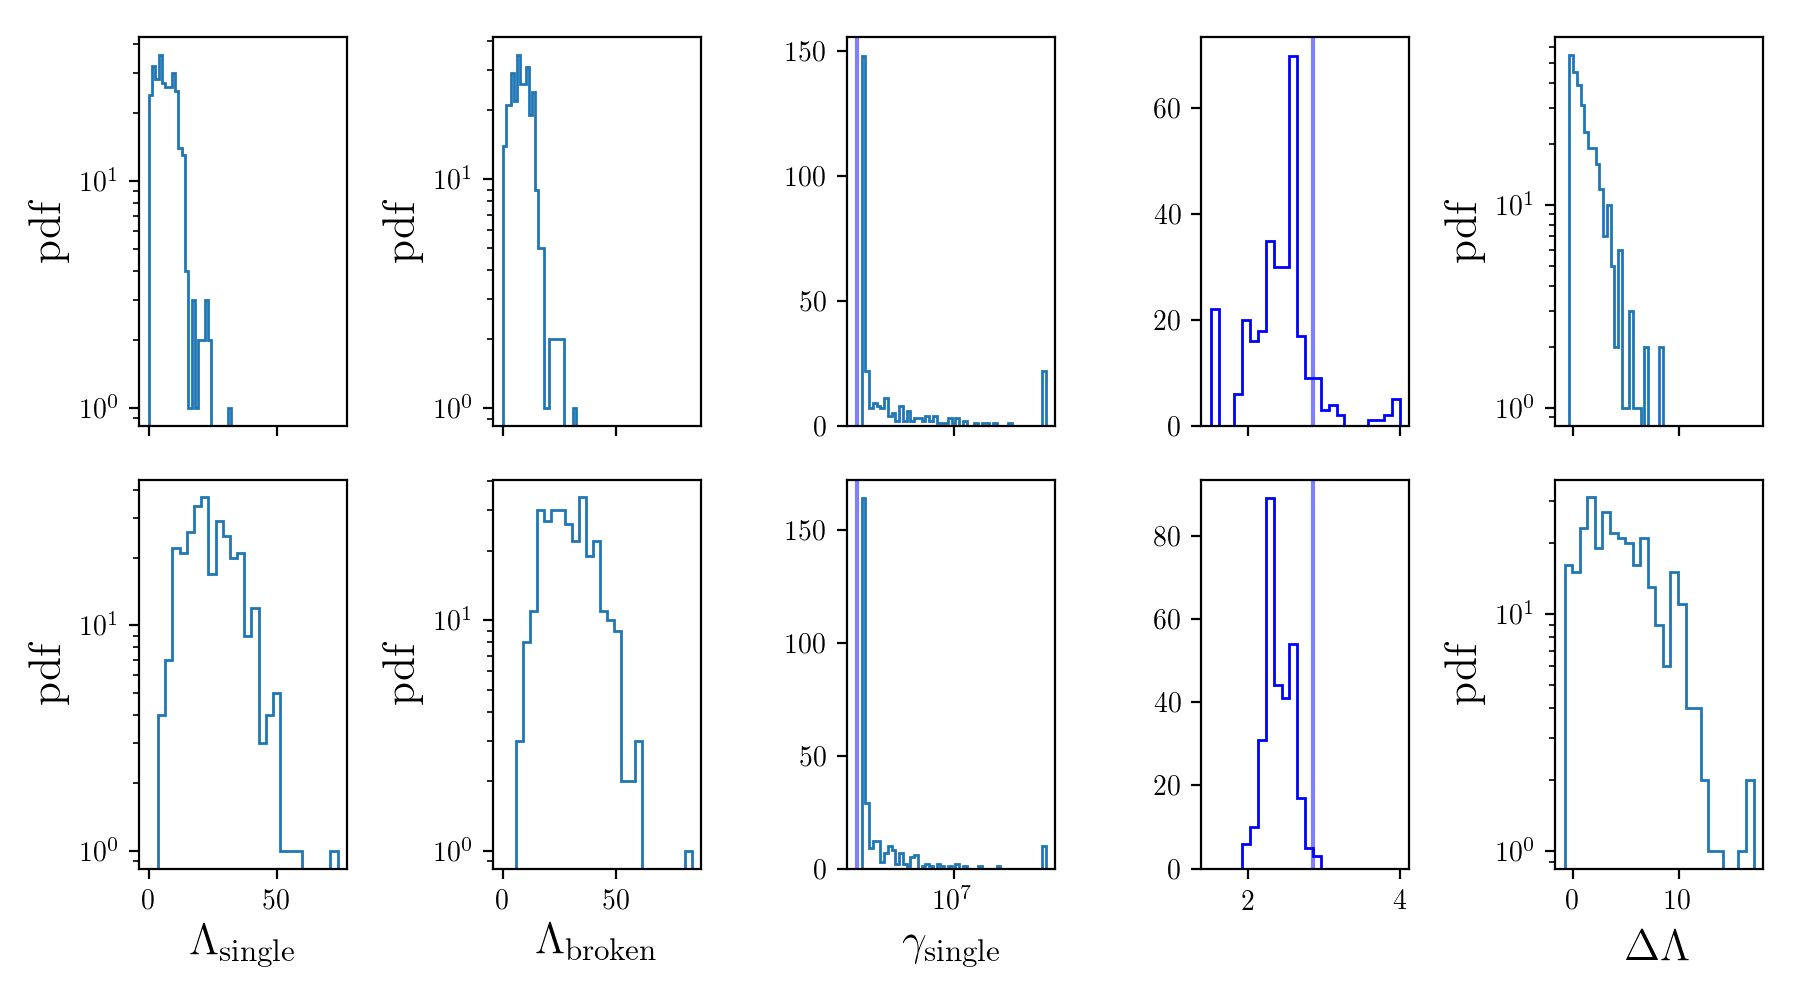

<IPython.core.display.Javascript object>


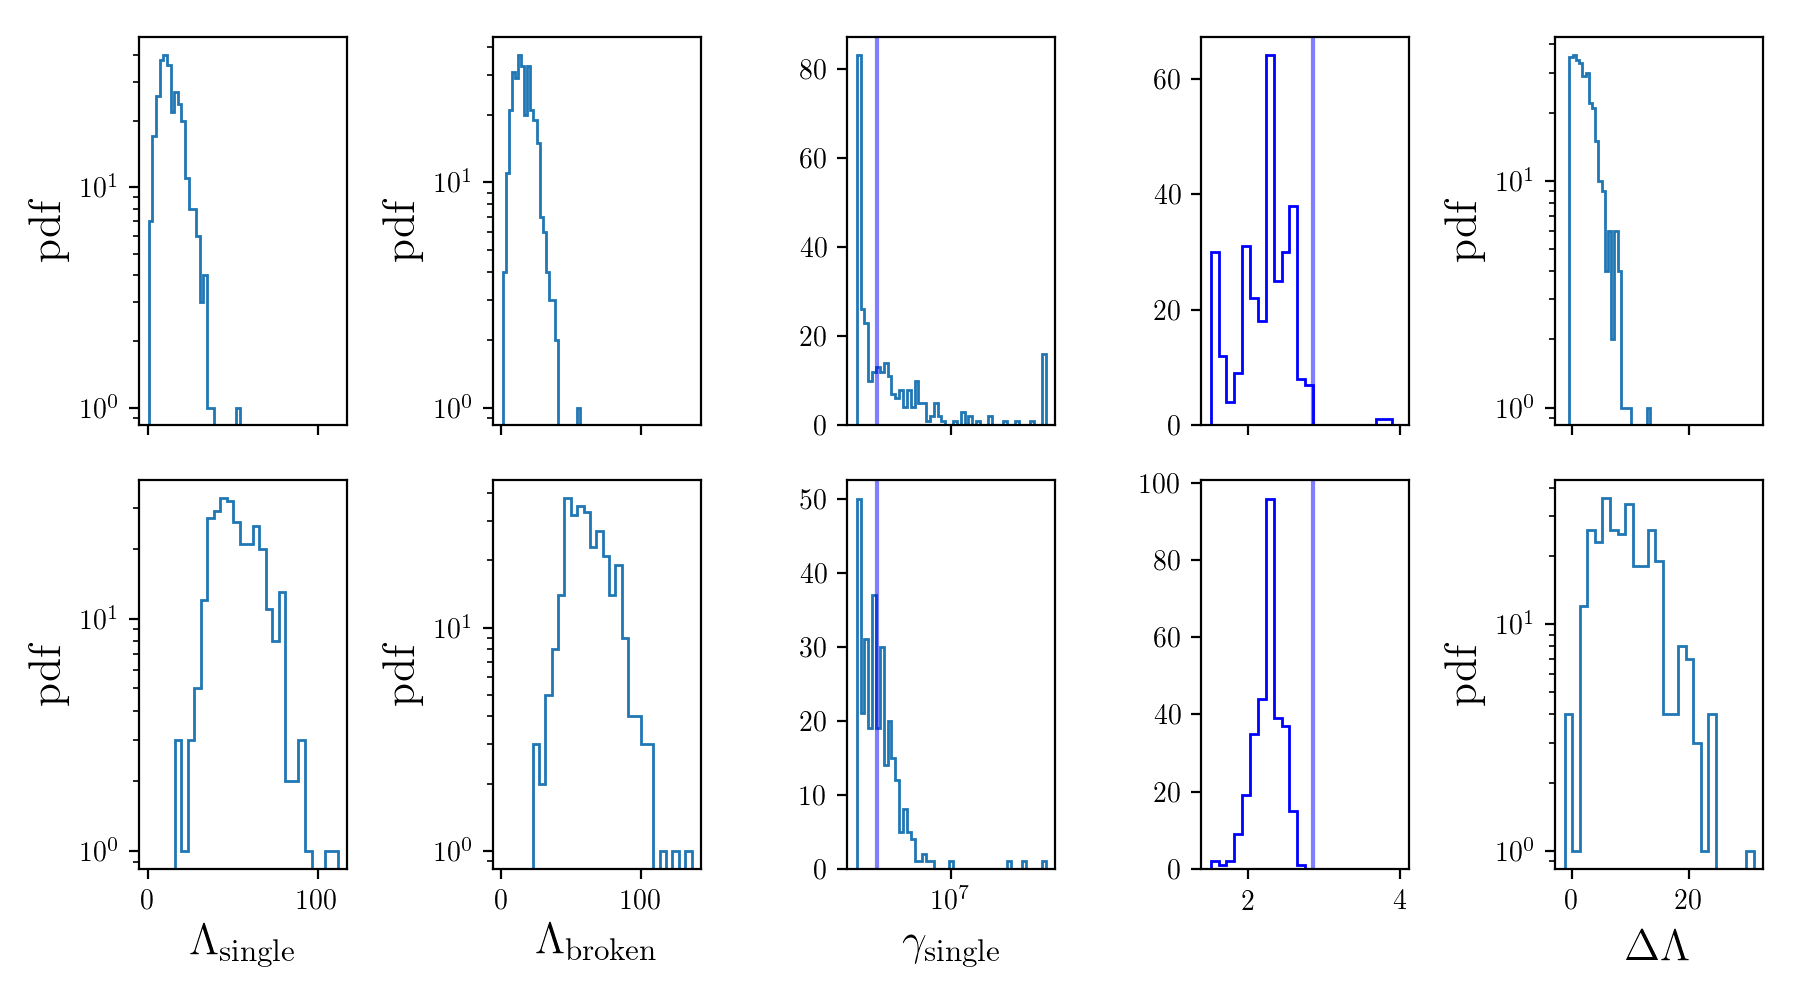

<IPython.core.display.Javascript object>


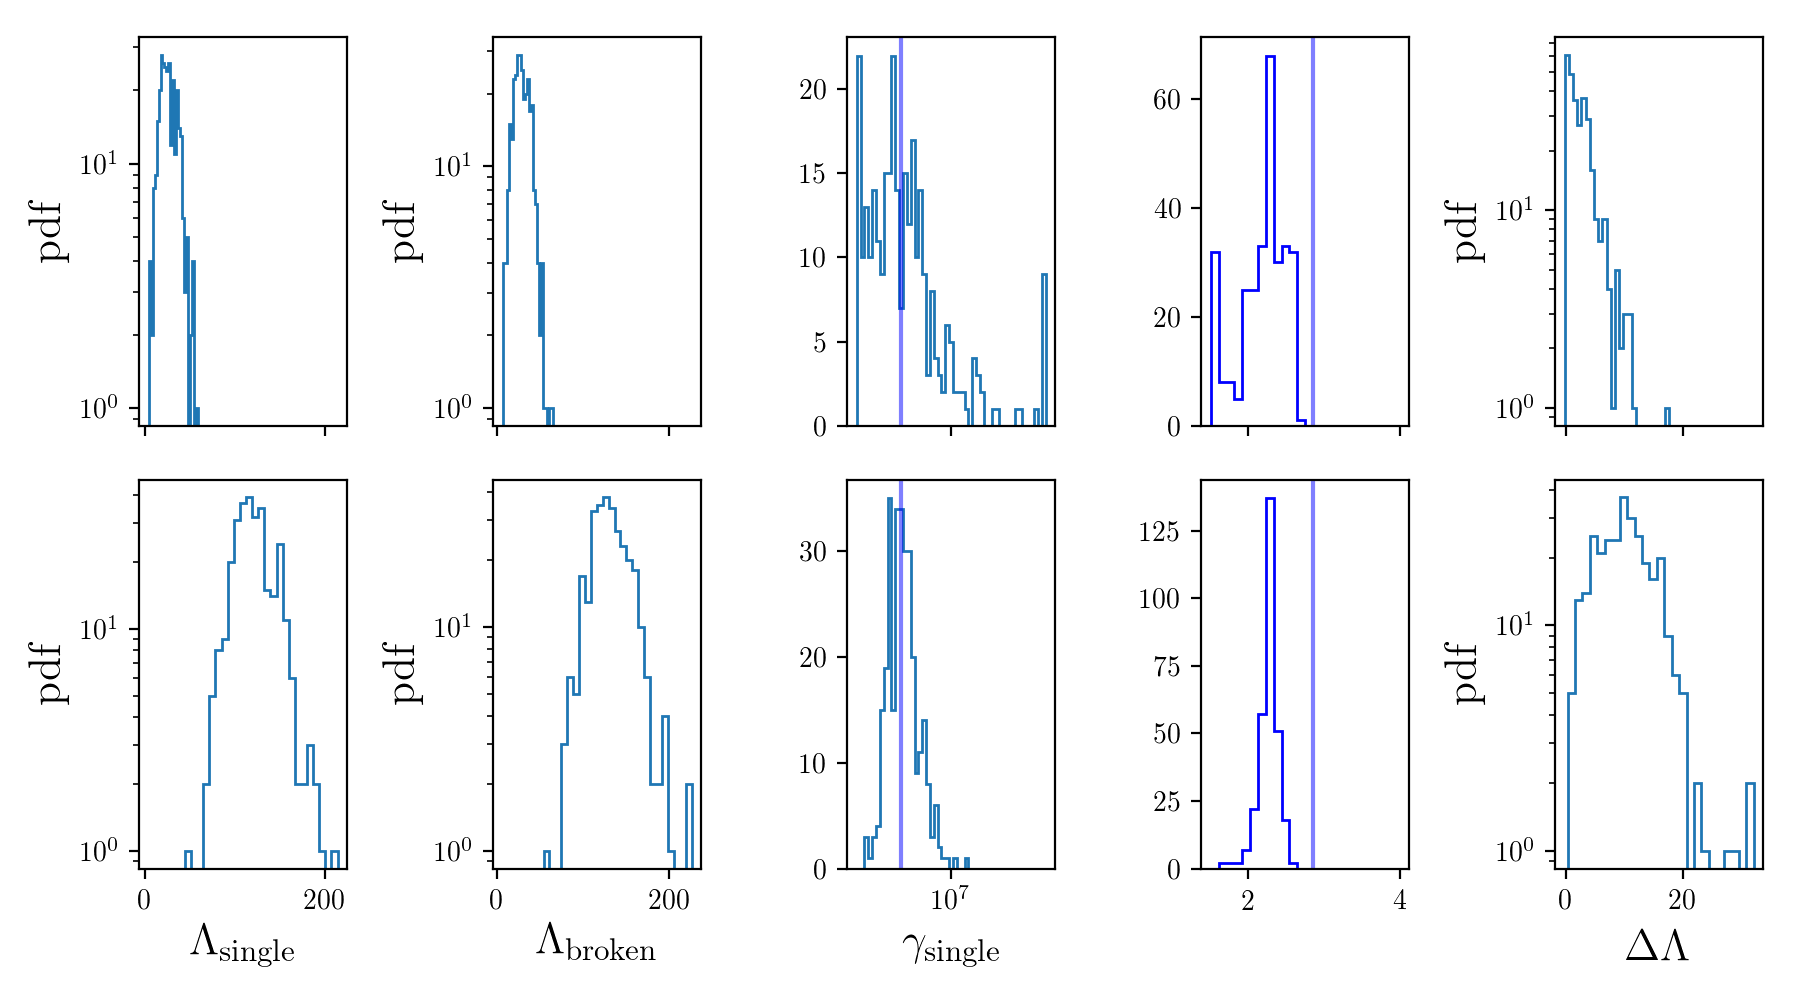

<IPython.core.display.Javascript object>


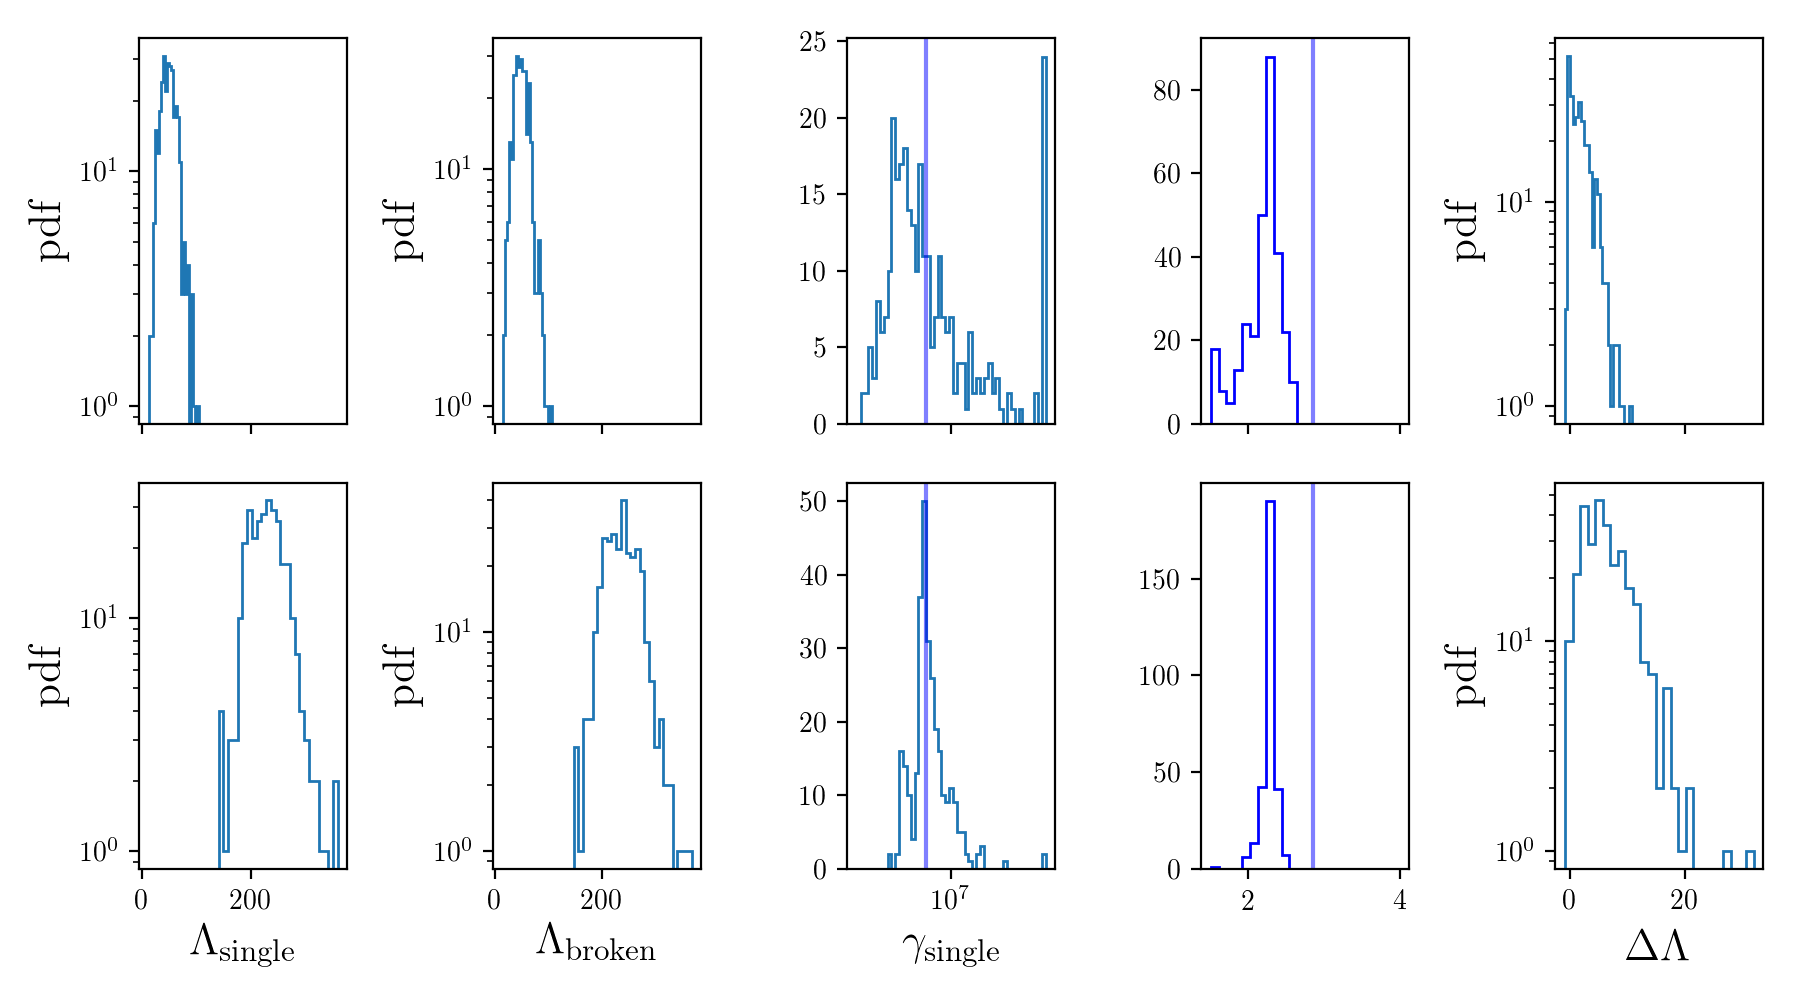

<IPython.core.display.Javascript object>


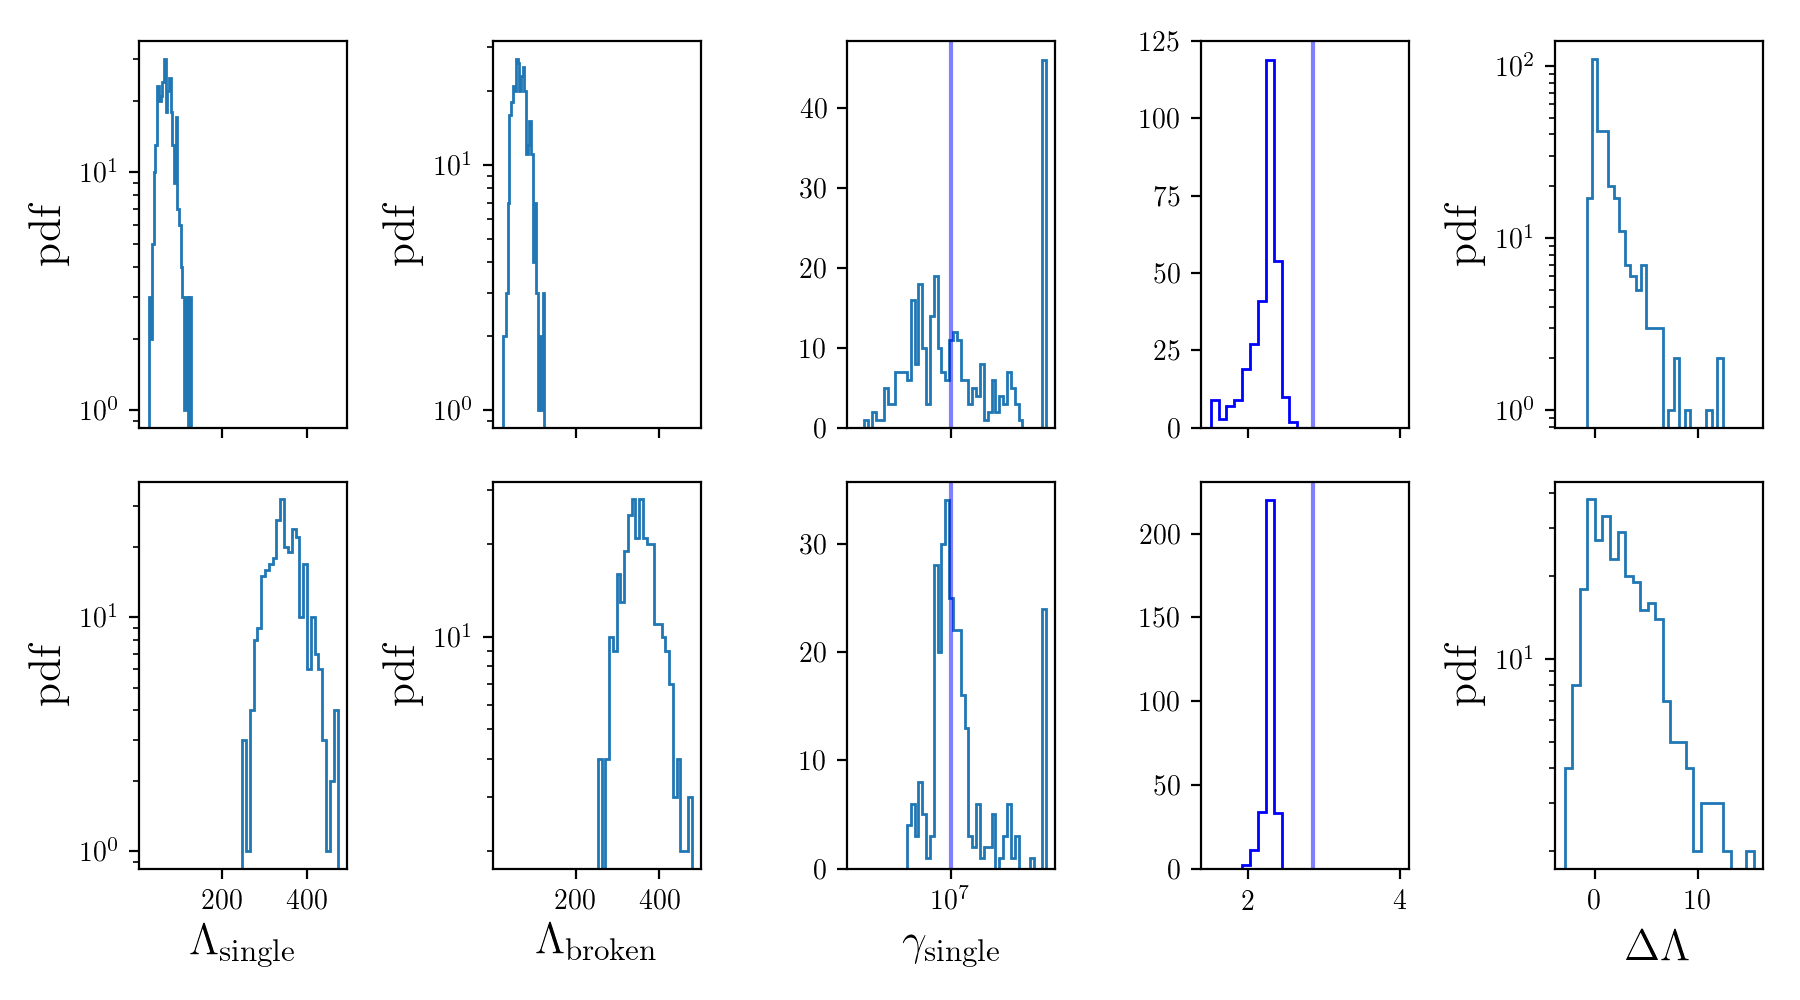

<IPython.core.display.Javascript object>


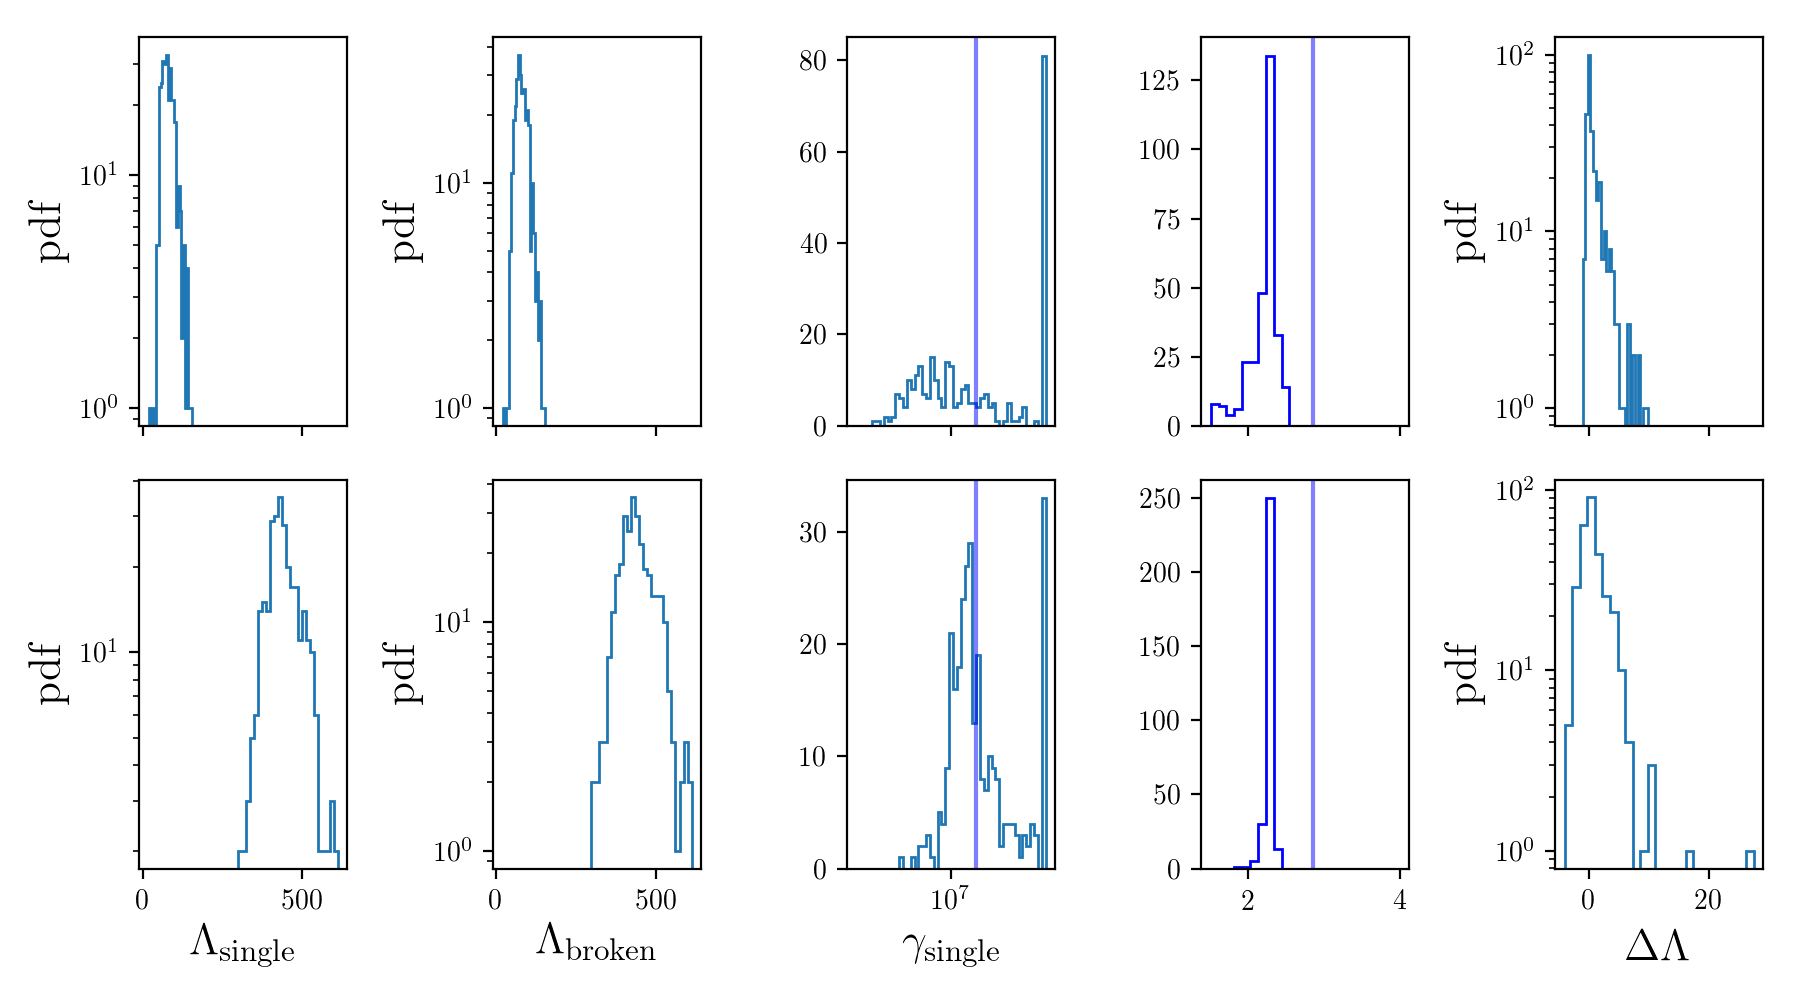

<IPython.core.display.Javascript object>


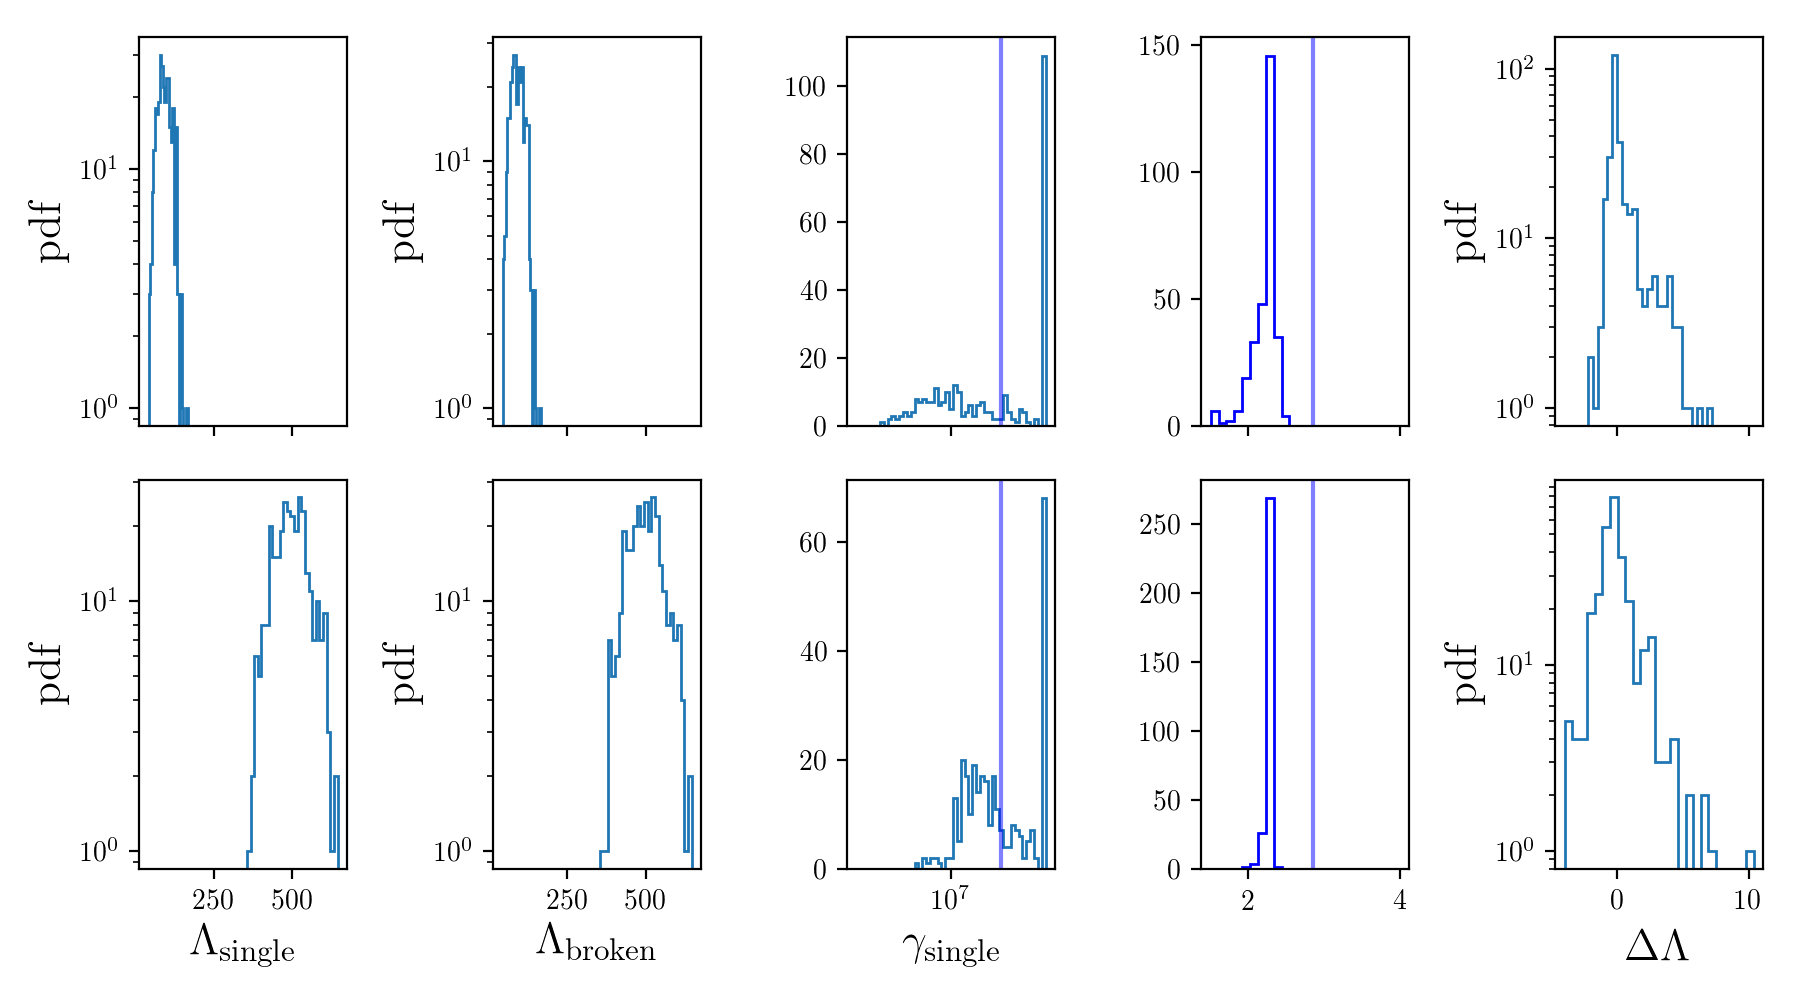

<IPython.core.display.Javascript object>


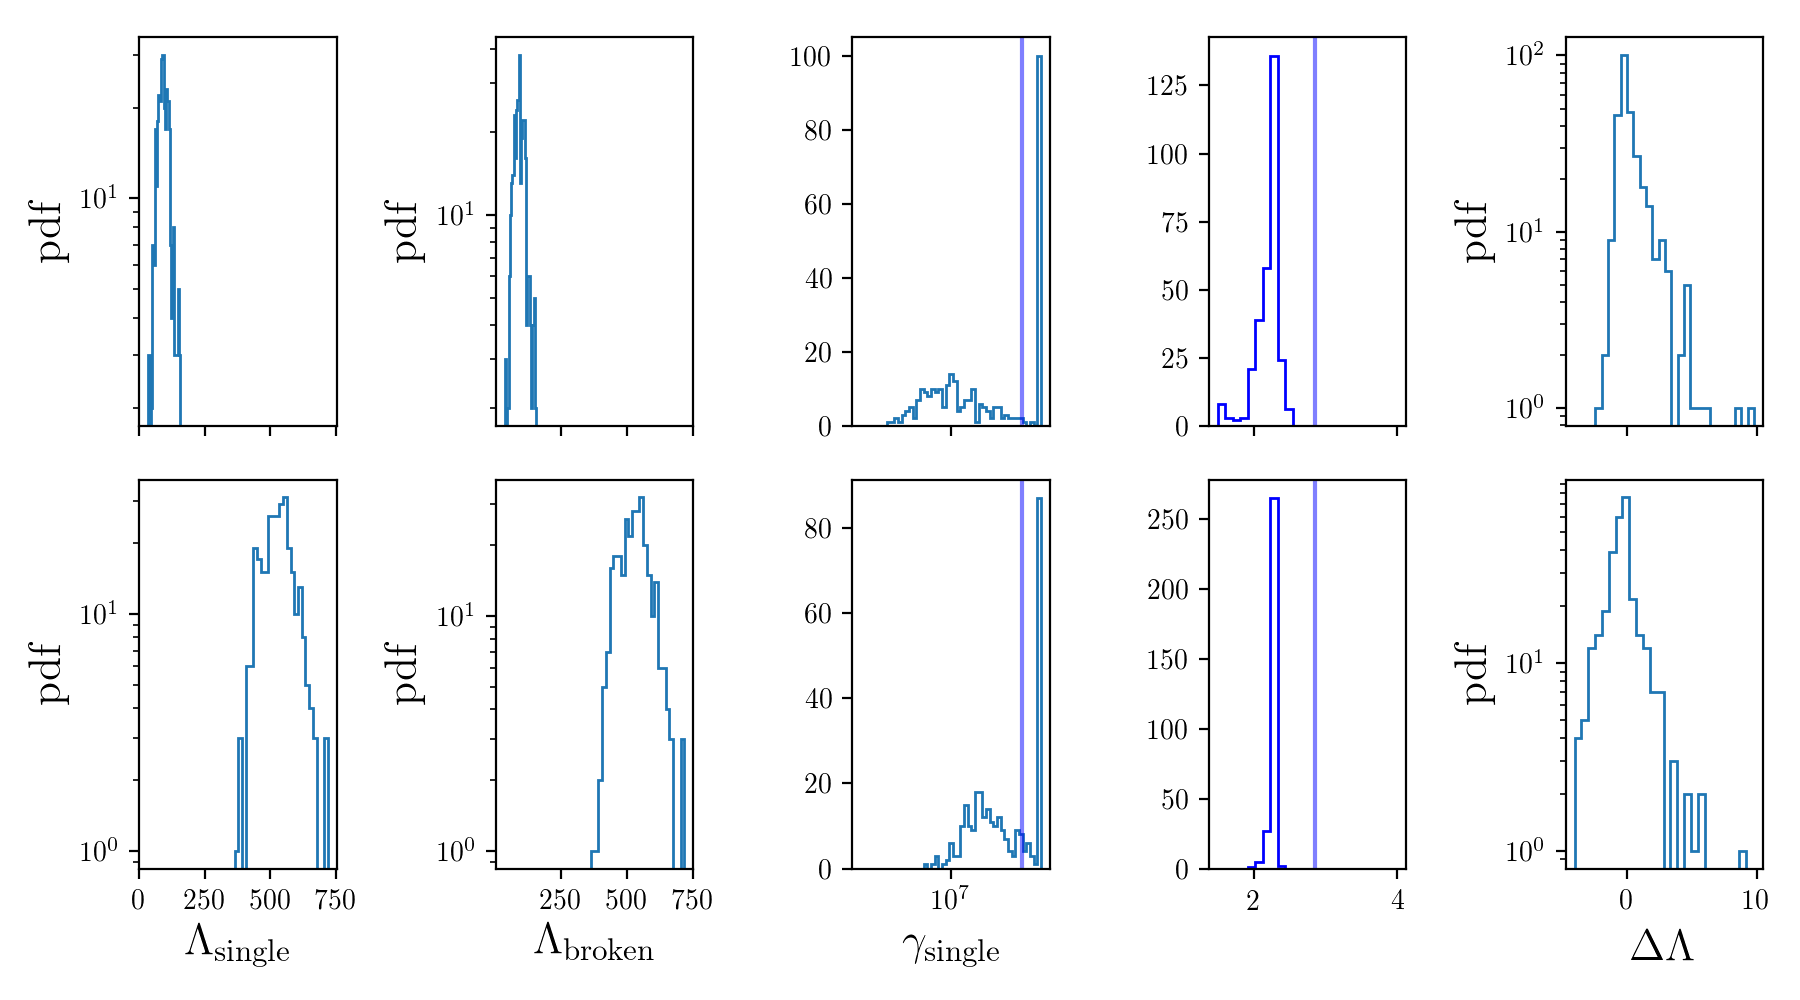

In [71]:
#print(phi_inj, g_inj0, g_inj1)
fs=16

for ci, coffi in enumerate(Cutoff_vals):
    fig, axes = plt.subplots(ncols=5,nrows=2,  figsize=(9,5.), sharex='col')
    fig.suptitle(r'E_c={0:.1e}'.format(coffi))
    for k, exp in enumerate(['icecube', 'plenum']):
        ax = axes[k, 0]
        bins = np.linspace(0,25, 35)
        ax.hist(RES_Recover_v2[exp][ci]['ts'], bins=25, histtype='step')
        ax.set_yscale('log')
        if k==1:
            ax.set_xlabel(r'$\Lambda_{\mathrm{single}}$', fontsize=fs)
        ax.set_ylabel(r'pdf', fontsize=fs)

        ax = axes[k, 1]
        bins = np.linspace(0,25, 35)
        ax.hist(RES_Recover_cutoff[exp][ci]['ts'], bins=25, histtype='step')
        ax.set_yscale('log')


        if k==1:
            ax.set_xlabel(r'$\Lambda_{\mathrm{broken}}$', fontsize=fs)
        ax.set_ylabel(r'pdf', fontsize=fs)


        ax = axes[k, 3]
        bins = _gs #np.linspace(np.min(gammas), np.max(gammas), 30)
        ax.hist(RES_Recover_cutoff[exp][ci]['gamma'], bins=bins, histtype='step', color='blue')
        ax.axvline(g_inji, color='blue', alpha=0.5)

        

        ax = axes[k, 2]
        bins = _coffs #np.linspace(np.min(gammas), np.max(gammas), 30)
        ax.hist(RES_Recover_cutoff[exp][ci]['cutoff'], bins=bins, histtype='step')
        ax.axvline(coffi, color='blue', alpha=0.5)
        ax.set_xscale('log')
        if k==1:
            ax.set_xlabel(r'$\gamma_{\mathrm{single}}$', fontsize=fs)


        ax = axes[k, 4]
        bins = np.linspace(0,25, 35)
        ax.hist(RES_Recover_cutoff[exp][ci]['ts'] - RES_Recover_v2[exp][ci]['ts'] , 
                bins=25, histtype='step')


        med = np.median(RES_Recover_cutoff[exp][ci]['ts'] - RES_Recover_v2[exp][ci]['ts'])
        low = np.percentile(RES_Recover_cutoff[exp][ci]['ts'] - RES_Recover_v2[exp][ci]['ts'],
                           (100-68.)/2.)
        up = np.percentile(RES_Recover_cutoff[exp][ci]['ts'] - RES_Recover_v2[exp][ci]['ts'],
                           100.-(100-68.)/2.)
        
        
        
        ax.set_yscale('log')
        if k==1:
            ax.set_xlabel(r'$\Delta \Lambda$', fontsize=fs)
        ax.set_ylabel(r'pdf', fontsize=fs)



    fig.tight_layout()

In [72]:
ts_vals_icecube_co = list()
ts_vals_plenum_co = list()
ts_ice_band = {'low': list(), 'up':list()}
ts_plenum_band = {'low': list(), 'up':list()}

for ci, coffi in enumerate(Cutoff_vals):
    for k, exp in enumerate(['icecube', 'plenum']):
        
        
        


        med = np.median(RES_Recover_cutoff[exp][ci]['ts'] - RES_Recover_v2[exp][ci]['ts'])
        low = np.percentile(RES_Recover_cutoff[exp][ci]['ts'] - RES_Recover_v2[exp][ci]['ts'],
                           (100-68.)/2.)
        up = np.percentile(RES_Recover_cutoff[exp][ci]['ts'] - RES_Recover_v2[exp][ci]['ts'],
                           100.-(100-68.)/2.)
        
        print(ci, coffi)
        print(exp, med, low, up)
        if exp =='icecube':
            ts_vals_icecube_co.append(med)
            ts_ice_band['low'].append(low)
            ts_ice_band['up'].append(up)
        else:
            ts_vals_plenum_co.append(med)
            ts_plenum_band['low'].append(low)
            ts_plenum_band['up'].append(up)
        
    


(0, 100000.0)
('icecube', 0.9014873343879303, 0.02706526727732676, 2.615599953074386)
(0, 100000.0)
('plenum', 4.081761687236592, 1.204829176659413, 8.418398233097589)
(1, 316227.7660168379)
('icecube', 1.9179370529091393, 0.19919821561035433, 4.335132816210988)
(1, 316227.7660168379)
('plenum', 9.025528805107328, 4.1564742424326, 14.389600912842115)
(2, 1000000.0)
('icecube', 1.9311479008937908, 0.2281518391617519, 4.553073550773944)
(2, 1000000.0)
('plenum', 10.015098013273999, 4.876718622312263, 15.325315867499132)
(3, 3162277.6601683795)
('icecube', 1.6390952503297918, -0.0026651512029427175, 4.206307906917859)
(3, 3162277.6601683795)
('plenum', 5.69401211663795, 2.3418463901626545, 10.834316483869308)
(4, 10000000.0)
('icecube', 0.5020040850796246, -0.12536419518640912, 2.546344418883423)
(4, 10000000.0)
('plenum', 2.1413750951249995, -0.4736114300722624, 5.923687633148086)
(5, 31622776.60168379)
('icecube', 0.1512396637448461, -0.2921507232174275, 2.249241871660614)
(5, 31622776.

<IPython.core.display.Javascript object>


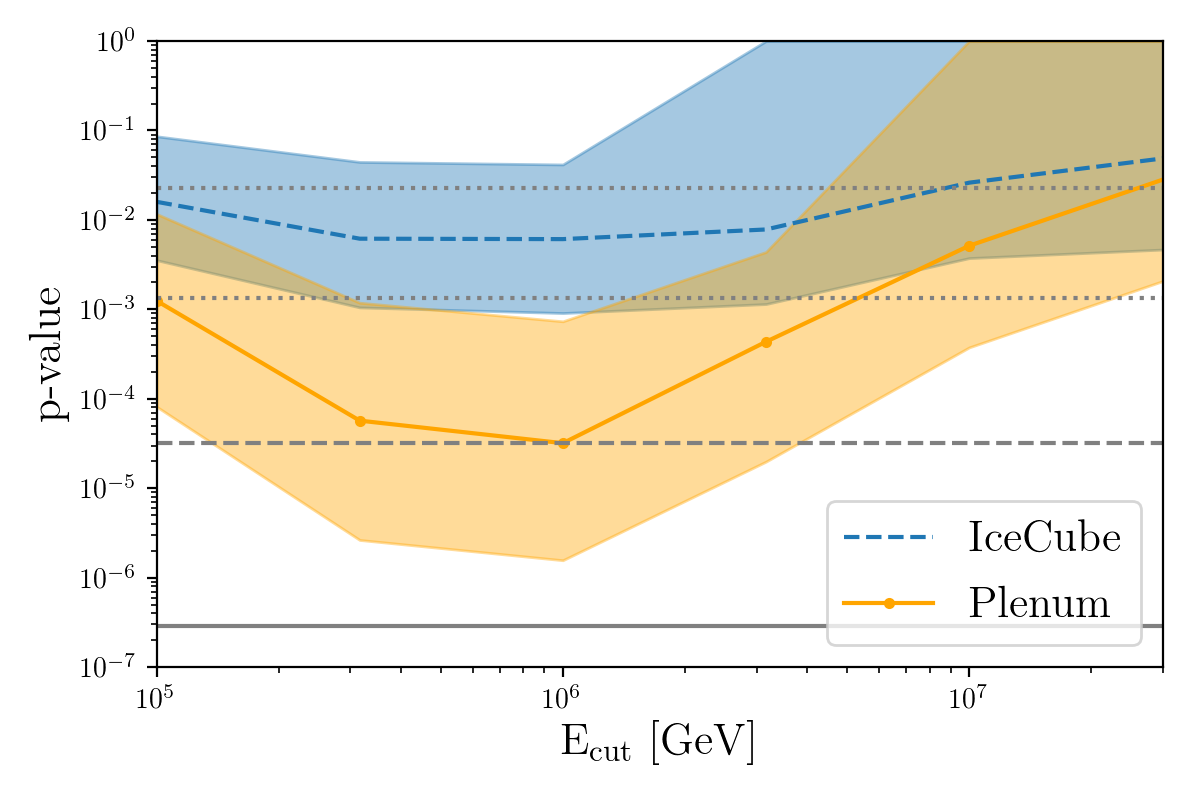

('ts icecube', array([0.90148733, 1.91793705, 1.9311479 , 1.63909525, 0.50200409,
       0.15123966, 0.        , 0.        ]))
[0.01593723 0.0061655  0.00609829 0.00781779 0.02607097 0.05019205]
(array([0.08607441, 0.04445439, 0.04165362, 1.        , 1.        ,
       1.        ]), array([0.00355064, 0.00105191, 0.0009097 , 0.00114706, 0.0037427 ,
       0.00471435]))
('ts plenum', array([ 4.08176169,  9.02552881, 10.01509801,  5.69401212,  2.1413751 ,
        0.3945775 ,  0.        ,  0.        ]))


In [74]:
from scipy.stats import chi2
fig, ax = plt.subplots( figsize=(6,4.))

print('ts icecube',  ts_vals_icecube_co)
print(fit_func.sf(ts_vals_icecube_co)[:-2])
print(fit_func.sf(ts_ice_band['low'][:-2]),fit_func.sf(ts_ice_band['up'][:-2]))
print('ts plenum',  ts_vals_plenum_co)
    
ts_vals_icecube_co = np.array(ts_vals_icecube_co)
ts_vals_plenum_co = np.array(ts_vals_plenum_co)
ts_vals_icecube_co[ts_vals_icecube_co<0] = 0
ts_vals_plenum_co[ts_vals_plenum_co<0] = 0

p=ax.plot(Cutoff_vals[:-2], fit_func.sf(ts_vals_icecube_co)[:-2], ls='dashed', label='IceCube')
ax.fill_between(Cutoff_vals[:-2], fit_func.sf(ts_ice_band['low'][:-2]),fit_func.sf(ts_ice_band['up'][:-2]), 
                color=p[0].get_color(),alpha=0.4)
p=ax.plot(Cutoff_vals[:-2], fit_func.sf(ts_vals_plenum_co)[:-2], ls='solid', color='orange',
       label='Plenum', marker='.')
ax.fill_between(Cutoff_vals[:-2], fit_func.sf(ts_plenum_band['low'][:-2]),fit_func.sf(ts_plenum_band['up'][:-2]), 
                color=p[0].get_color(),alpha=0.4)

ax.axhline(sigma2pval(2), color='grey', ls='dotted')
ax.axhline(sigma2pval(3), color='grey', ls='dotted')
ax.axhline(sigma2pval(4), color='grey', ls='dashed')
ax.axhline(sigma2pval(5), color='grey', ls='solid')
 
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(fontsize=fs, loc='lower right')
ax.set_xlim(1e5,0.3e8)
ax.set_ylim(1e-7,1)

ax.set_xlabel(r'E$_{\mathrm{cut}}$ [GeV]', fontsize=fs)
ax.set_ylabel(r'p-value', fontsize=fs)

fig.tight_layout()
fig.savefig('plots/diffuse_analysis_cutoff_pl_pvalues.pdf')